# Notebook that does product and customer segmentation, customer value measure and recommender system. 

Originally written by F. Daniel (September 2017).

Improved (2020) by Juno Wen, Jenny Shang, Kefan Lu, Donny Yang, Yura Shakhnazarian, Rachel Yan, Andrew Zhao, Lingrou Wang

Improved (2021) by Shuyuan Hu, Haoyan Zhang

This notebook aims at analyzing the content of an E-commerce database that lists purchases made by about 4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). 

The main applications in this notebook are 

(1) product segmentation using NLP (didn't work that well, but good example of doing a product segmentation)

(2) customer segmentation using what products they tend to purchase (works pretty well)

(3) Customer Value Measures (works fine)

(4) recommender system (works fine)

(5) models to predict somehting about the customer behavior (doesn't work very well)

These are the main business analytics applications in this notebook, and even though some didn't provide much value thay are all very good examples of how to do these tasks.

The most important business use tasks performed in this notebook are the segmentations for products and customers. The predictive models done in the last section are not that useful.

___
**1. Read and Explore Data**

**2. Remove cancelled Orders and Look at Remaining Records**

**3. Make Product Categories**
   
**4. Make Customer Categories**

**5. Make Customer Value Measure**
   
**6. Examine Item Co-occurence and Make Recommendations**

**7. Classification of Customers**

# 1. Read and Explore Data

In [7]:
import pandas as pd
from datetime import datetime
start_time = datetime.now()

# need to install these libraries the first time you run the notebook
# %pip install --user -U nltk
# %pip install pandas-profiling
# %pip install mlxtend
# %pip install surprise
# %pip install spotlight
# %pip install scipy == 1.1.0
# %pip install lifetimes
# %pip install plotly
# %pip install wordcloud
    
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
from lifetimes import BetaGeoFitter
from scipy.special import logsumexp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.cm as cm
import itertools
# import pandas_profiling
import plotly.graph_objs as go
import math

# from spotlight.interactions import Interactions
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from scipy.spatial.distance import cdist
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
from datetime import datetime
from plotly.offline import init_notebook_mode,iplot
from sklearn.manifold import TSNE
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
# plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
print('LOAD TIME: ',datetime.now() - start_time) # Load duration about 2 minutes

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tommy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Tommy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tommy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LOAD TIME:  0:00:01.314221


Then, I load the data. Once done, I also give some basic informations on the content of the dataframe: the type of the various fields, the number of null values and their percentage with respect to the total number of entries:

In [8]:
# read the datafile
df_initial = pd.read_csv('ecommerce data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
#______
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
df_initial['Country'] = df_initial['Country'].str.replace('EIRE','Ireland')
#____________________________________________________________
# gives some info on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
#__________________
# show first lines
display(df_initial[:5])

Dataframe dimensions: (541909, 8)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0        1454        0               0   
null values (%)        0.0       0.0    0.268311      0.0             0.0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0     135080       0  
null values (%)        0.0  24.926694     0.0

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

In [3]:
df_initial.head(5)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

In [4]:
# Output a profile of the original, raw data
# profile = pandas_profiling.ProfileReport(df_initial)
# profile.to_file('Initial data profile.html')

While looking at the number of null values in the dataframe, it is interesting to note that $\sim$25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So I delete them from the dataframe:

This is a lot of orders to just drop/ignore. Before deleting the entries that are not assigned to a particular customer, it is worth taking a look at these entries and explore reasons on why they are not associated with any customers.

In [5]:
## Look at entries with no customer ID
no_cust = df_initial[df_initial["CustomerID"].isnull() == True]
no_cust.head()

InvoiceNo StockCode                      Description  Quantity  \
622     536414     22139                              NaN        56   
1443    536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444    536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445    536544     21786               POLKADOT RAIN HAT          4   
1446    536544     21787            RAIN PONCHO RETROSPOT         2   

             InvoiceDate  UnitPrice CustomerID         Country  
622  2010-12-01 11:52:00       0.00        NaN  United Kingdom  
1443 2010-12-01 14:32:00       2.51        NaN  United Kingdom  
1444 2010-12-01 14:32:00       2.51        NaN  United Kingdom  
1445 2010-12-01 14:32:00       0.85        NaN  United Kingdom  
1446 2010-12-01 14:32:00       1.66        NaN  United Kingdom

In [6]:
no_cust.tail()

InvoiceNo StockCode                     Description  Quantity  \
541536    581498    85099B         JUMBO BAG RED RETROSPOT         5   
541537    581498    85099C  JUMBO  BAG BAROQUE BLACK WHITE         4   
541538    581498     85150   LADIES & GENTLEMEN METAL SIGN         1   
541539    581498     85174               S/4 CACTI CANDLES         1   
541540    581498       DOT                  DOTCOM POSTAGE         1   

               InvoiceDate  UnitPrice CustomerID         Country  
541536 2011-12-09 10:26:00       4.13        NaN  United Kingdom  
541537 2011-12-09 10:26:00       4.13        NaN  United Kingdom  
541538 2011-12-09 10:26:00       4.96        NaN  United Kingdom  
541539 2011-12-09 10:26:00      10.79        NaN  United Kingdom  
541540 2011-12-09 10:26:00    1714.17        NaN  United Kingdom

In [7]:
no_cust["Country"].value_counts()

United Kingdom    133600
Ireland              711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
Name: Country, dtype: int64

From the exploration, although there is no particular invoice or product associated with no Customer ID, majority of the entry is from the UK. I think dropping the entries without investigating is a rushed decision because one possible reason that these entries don't have an associated Customer ID is because the customer is a new customer (i.e. not assigned an ID yet). I think a more reasonable choice would be to assign an independent Customer ID such as the InvoiceNo (since items with the same InvoiceNo would be assumed to be purchased by the same customer).

In [8]:
## Check to make sure that the CustomerIDs don't go as high as the InvoiceNo.
pd.DataFrame(df_initial["CustomerID"].value_counts().reset_index().sort_values(by = "index",ascending = False))

index  CustomerID
1529  18287          70
31    18283         756
3563  18282          13
3938  18281           7
3767  18280          10
...     ...         ...
3282  12350          17
1473  12349          73
2521  12348          31
526   12347         182
4249  12346           2

[4372 rows x 2 columns]

In [9]:
pd.DataFrame(df_initial["InvoiceNo"].value_counts().reset_index().sort_values(by = "index",ascending = False))

index  InvoiceNo
18574  C581569          2
21811  C581568          1
21818  C581499          1
18586  C581490          2
21782  C581484          1
...        ...        ...
21805   536369          1
17081   536368          4
11690   536367         12
19768   536366          2
14726   536365          7

[25900 rows x 2 columns]

In [10]:
# Add a column to indicate one-time purchaser
df_initial["OneTimePurchaser"] = df_initial["CustomerID"].isna()
df_initial[df_initial["OneTimePurchaser"]].head()

InvoiceNo StockCode                      Description  Quantity  \
622     536414     22139                              NaN        56   
1443    536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444    536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445    536544     21786               POLKADOT RAIN HAT          4   
1446    536544     21787            RAIN PONCHO RETROSPOT         2   

             InvoiceDate  UnitPrice CustomerID         Country  \
622  2010-12-01 11:52:00       0.00        NaN  United Kingdom   
1443 2010-12-01 14:32:00       2.51        NaN  United Kingdom   
1444 2010-12-01 14:32:00       2.51        NaN  United Kingdom   
1445 2010-12-01 14:32:00       0.85        NaN  United Kingdom   
1446 2010-12-01 14:32:00       1.66        NaN  United Kingdom   

      OneTimePurchaser  
622               True  
1443              True  
1444              True  
1445              True  
1446              True

In [11]:
# Create a dataframe consisting only customers with ID's
w_cust = df_initial[df_initial["OneTimePurchaser"]==False]

## Two choice of what to do with the orders with no Customer number. Use one or the other below:

In [12]:
# 1. replace the empty Customer IDs with a unique number, the invoice number:
df_initial["CustomerID"] = df_initial["CustomerID"].fillna(df_initial.InvoiceNo)
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (541909, 9)


In [13]:
# or, 2. alternatively, just drop the orders with no customer ID:
# df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
# print('Dataframe dimensions:', df_initial.shape)

In [14]:
# df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
# ____________________________________________________________
# gives some info on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (541909, 9)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0        1454        0               0   
null values (%)        0.0       0.0    0.268311      0.0             0.0   

                 UnitPrice CustomerID Country OneTimePurchaser  
column type        float64     object  object             bool  
null values (nb)         0          0       0                0  
null values (%)        0.0        0.0     0.0              0.0

In [15]:
## Look at entries with no description
no_desc = df_initial[df_initial["Description"].isnull() == True]
no_desc.head()

InvoiceNo StockCode Description  Quantity         InvoiceDate  UnitPrice  \
622     536414     22139         NaN        56 2010-12-01 11:52:00        0.0   
1970    536545     21134         NaN         1 2010-12-01 14:32:00        0.0   
1971    536546     22145         NaN         1 2010-12-01 14:33:00        0.0   
1972    536547     37509         NaN         1 2010-12-01 14:33:00        0.0   
1987    536549    85226A         NaN         1 2010-12-01 14:34:00        0.0   

     CustomerID         Country  OneTimePurchaser  
622      536414  United Kingdom              True  
1970     536545  United Kingdom              True  
1971     536546  United Kingdom              True  
1972     536547  United Kingdom              True  
1987     536549  United Kingdom              True

In [16]:
# Check if all entries are from one-time purchasers (CustomerID = InvoiceNo)
(no_desc["InvoiceNo"] == no_desc["CustomerID"]).all()

True

In [17]:
# Check if all entries have 0 UnitPrice
(no_desc["UnitPrice"] == 0).all()

True

In [18]:
# Check if every entry is the only product in a transaction
invoice_no_desc = no_desc["InvoiceNo"].tolist() # list of InvoiceNo of no-description entries
df_initial[df_initial["InvoiceNo"].isin(invoice_no_desc)].value_counts("InvoiceNo")

InvoiceNo
536414    1
560403    1
560401    1
560400    1
560399    1
         ..
548683    1
548682    1
548681    1
548680    1
581408    1
Length: 1454, dtype: int64

We can see that all entries with no description are from one-time purchasers, have a UnitPrice of 0, and don't have other products in the same transaction. I delete them for easier future analysis:

In [19]:
df_initial.dropna(axis = 0, subset = ['Description'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
# ____________________________________________________________
# gives some info on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (540455, 9)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)        0.0       0.0         0.0      0.0             0.0   

                 UnitPrice CustomerID Country OneTimePurchaser  
column type        float64     object  object             bool  
null values (nb)         0          0       0                0  
null values (%)        0.0        0.0     0.0              0.0

OK, therefore, we end up with a dataframe filled at 100% for all variables! Finally, I check for duplicate entries and delete them:

In [20]:
# drop duplicate entries. Is this the right thing to do?
print('Duplicate entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate entries: 5268


___
## Exploring the content of fields

This dataframe contains 8 fields that correspond to: 

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

___
### Field Statistics

For numeric fields, I look at the distribution of values. For categorical fields, look at the top 15 most occurring values. 

In [21]:
# 1. InvoiceNo. - who made the biggest orders
df_initial["InvoiceNo"].value_counts()

573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
C551348       1
C551386       1
C572187       1
C551388       1
C559309       1
Name: InvoiceNo, Length: 24446, dtype: int64

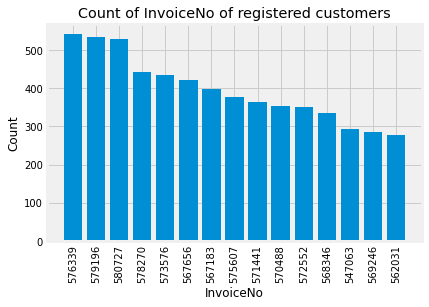

In [22]:
plt.figure()
temp = pd.DataFrame(w_cust["InvoiceNo"].value_counts())
plt.bar(temp.index[:15], temp.InvoiceNo[:15])
plt.xticks(rotation = 90)
plt.xlabel("InvoiceNo")
plt.ylabel("Count")
plt.title("Count of InvoiceNo of registered customers")
plt.show()

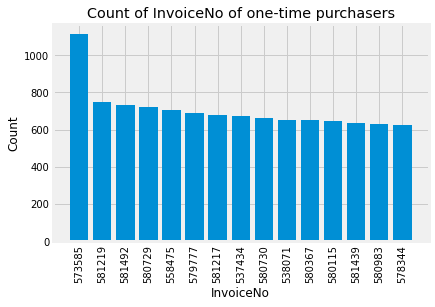

In [23]:
plt.figure()
temp = pd.DataFrame(no_cust["InvoiceNo"].value_counts())
plt.bar(temp.index[:15], temp.InvoiceNo[:15])
plt.xticks(rotation = 90)
plt.xlabel("InvoiceNo")
plt.ylabel("Count")
plt.title("Count of InvoiceNo of one-time purchasers")
plt.show()

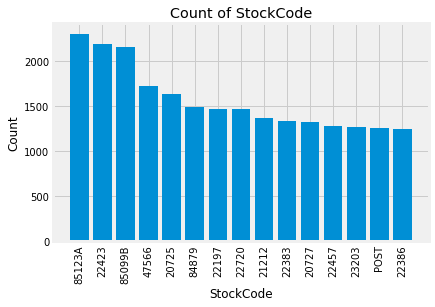

In [24]:
# StockCode
plt.figure()
temp = pd.DataFrame(df_initial["StockCode"].value_counts())
plt.bar(temp.index[:15], temp.StockCode[:15])
plt.xticks(rotation = 90)
plt.xlabel("StockCode")
plt.ylabel("Count")
plt.title("Count of StockCode")
plt.show()

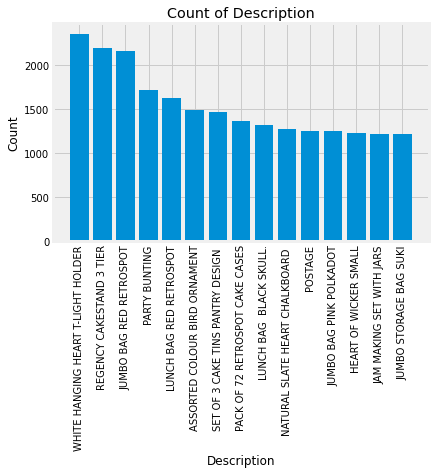

In [25]:
# 3. Description
plt.figure()
temp = pd.DataFrame(df_initial["Description"].value_counts())
plt.bar(temp.index[:15], temp.Description[:15])
plt.xticks(rotation = 90)
plt.xlabel("Description")
plt.ylabel("Count")
plt.title("Count of Description")
plt.show()

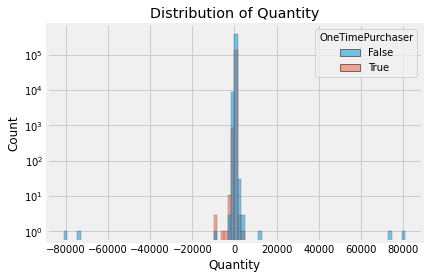

In [26]:
# 4. Quantity
plt.figure()
sns.histplot(data=df_initial, x="Quantity", bins=100, hue="OneTimePurchaser")
plt.yscale("log")
plt.title("Distribution of Quantity")
plt.show()

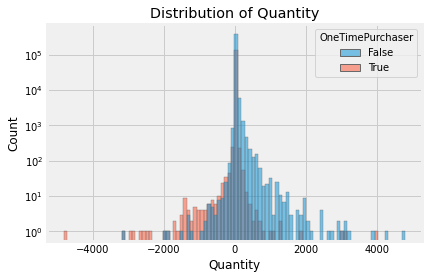

In [27]:
# Zoom in on the area between -5000 to 5000
temp = df_initial[(df_initial["Quantity"]<5000) & (df_initial["Quantity"]>-5000)]
plt.figure()
sns.histplot(data=temp, x="Quantity", bins=100, hue="OneTimePurchaser")
plt.yscale("log")
plt.title("Distribution of Quantity")
plt.show()

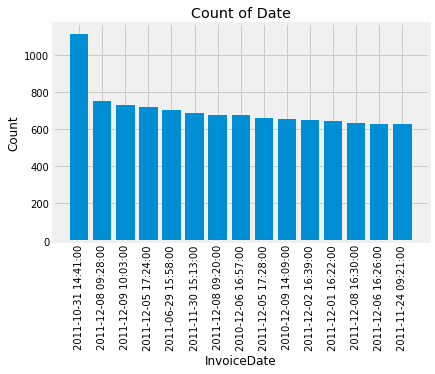

In [28]:
# 5. InvoiceDate
plt.figure()
temp = pd.DataFrame(df_initial["InvoiceDate"].value_counts()).reset_index()
plt.bar(temp["index"][:15].astype(str), temp.InvoiceDate[:15])
plt.xticks(rotation = 90)
plt.xlabel("InvoiceDate")
plt.ylabel("Count")
plt.title("Count of Date")
plt.show()

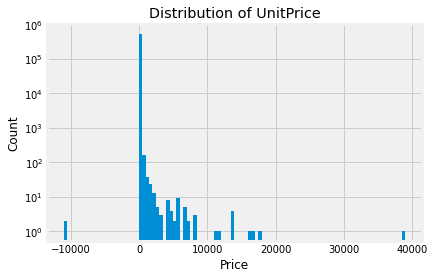

In [29]:
# 6. UnitPrice
plt.figure()
plt.hist(df_initial["UnitPrice"], bins = 100)
#plt.xticks(rotation = 90)
#plt.xlim(-200,200)
plt.yscale("log")
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of UnitPrice")
plt.show()

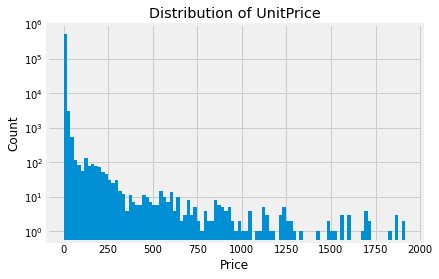

In [30]:
# Zoom in on the area between 0 to 2000
temp = df_initial[(df_initial["UnitPrice"]<2000) & (df_initial["UnitPrice"]>0)]
plt.figure()
plt.hist(temp["UnitPrice"], bins = 100)
plt.yscale("log")
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of UnitPrice")
plt.show()

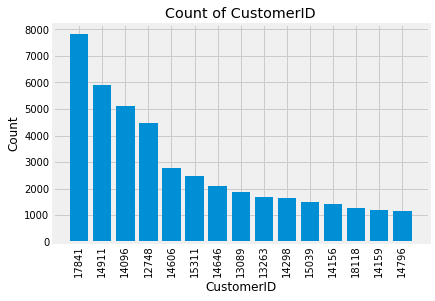

In [31]:
# 7. CustomerID
plt.figure()
temp = pd.DataFrame(df_initial["CustomerID"].value_counts())
plt.bar(temp.index[:15], temp.CustomerID[:15])
plt.xticks(rotation = 90)
plt.xlabel("CustomerID")
plt.ylabel("Count")
plt.title("Count of CustomerID")
plt.show()

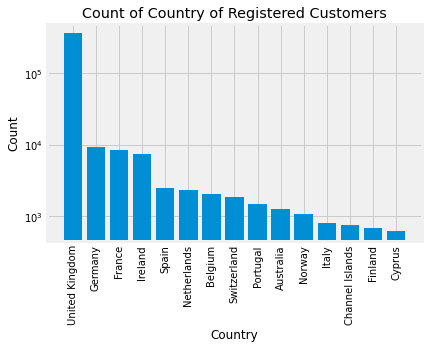

In [32]:
# 8. Country
plt.figure()
temp = pd.DataFrame(w_cust["Country"].value_counts())
plt.bar(temp.index[:15], temp.Country[:15])
plt.yscale("log")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Count of Country of Registered Customers")
plt.show()

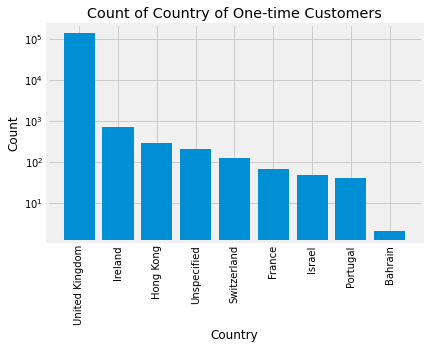

In [33]:
plt.figure()
temp = pd.DataFrame(no_cust["Country"].value_counts())
plt.bar(temp.index, temp.Country)
plt.yscale("log")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Count of Country of One-time Customers")
plt.show()

### Look at Countries

Here, I quickly look at the countries from which orders were made:

In [34]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of countries in the data: {}'.format(len(countries)))

Number of countries in the data: 38


and show the result on a chloropleth map:

In [35]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [36]:
# I also explored which countries accounted for the most unique customers
# For all customers
forhist = temp.groupby('Country')['CustomerID'].nunique().reset_index().sort_values('CustomerID', ascending = False)
forhist.reset_index(inplace = True)
forhist.drop('index', axis = 1, inplace = True)
display(forhist.head(10))

Country  CustomerID
0  United Kingdom        6133
1         Germany          95
2          France          90
3         Ireland          44
4           Spain          31
5         Belgium          25
6     Switzerland          24
7        Portugal          20
8           Italy          15
9       Hong Kong          15

In [37]:
# One-time purchasers
temp = df_initial[df_initial['OneTimePurchaser']][['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
forhist = temp.groupby('Country')['CustomerID'].nunique().reset_index().sort_values('CustomerID', ascending = False)
forhist.reset_index(inplace = True)
forhist.drop('index', axis = 1, inplace = True)
display(forhist.head(10))

Country  CustomerID
0  United Kingdom        2183
1         Ireland          41
2       Hong Kong          15
3     Unspecified           5
4          France           3
5          Israel           3
6     Switzerland           3
7         Bahrain           2
8        Portugal           1

In [38]:
# Registered customers
temp = df_initial[df_initial['OneTimePurchaser']==False][['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
forhist = temp.groupby('Country')['CustomerID'].nunique().reset_index().sort_values('CustomerID', ascending = False)
forhist.reset_index(inplace = True)
forhist.drop('index', axis = 1, inplace = True)
display(forhist.head(10))

Country  CustomerID
0  United Kingdom        3950
1         Germany          95
2          France          87
3           Spain          31
4         Belgium          25
5     Switzerland          21
6        Portugal          19
7           Italy          15
8         Finland          12
9         Austria          11

We see that most customers from Ireland and all customers from Hong Kong are one-time purchasers.

We see that the dataset is largely dominated by orders made from the UK.

___
### Look at Customers and products

The dataframe contains $\sim$500,000 entries. What are the number of users and products in these entries ?

In [39]:
# String to be searched in start of string  
search ="C"
# boolean series returned 
df_initial[df_initial["InvoiceNo"].str.startswith(search)]

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice CustomerID         Country  \
141    2010-12-01 09:41:00      27.50      14527  United Kingdom   
154    2010-12-01 09:49:00       4.65      15311  United Kingdom   
235    2010-12-01 10:24:00       1.65      17548  United Kingdom   
236    2010-12-01 10:24:00       0.29      17548  United Kingdom   
237    2010-12-01 10:24:00       0.29      17548  United Kingdom   
...                    ...        ...        ...             ...   
540449 2011-12-09 09:57:00       0.83      14397  United Kingdom   
541541 2011-12-09 10:28:00     224.69      15498  United Kingdom   
541715 2011-12-09 11:57:00      10.95      15311  United Kingdom   
541716 2011-12-09 11:58:00       1.25      17315  United Kingdom   
541717 2011-12-09 11:58:00       1.25      17315  United Kingdom   

        OneTimePurchaser  
141                False  
154                False  
235                False  
236                False  
237                False  
...                  ...  
540449             False  
541541             False  
541715             False  
541716             False  
541717             False  

[9251 rows x 9 columns]

In [40]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

products  transactions  customers
quantity      3958         24446       6628

It can be seen that the data has 6628 users and that they bought 3958 different products. The total number of transactions carried out is of the order of $\sim$24'000.

Now I will determine the number of products purchased in every transaction:

In [41]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12347    562032                  22
7      12347    573511                  47
8      12347    581180                  11
9      12348    539318                  17

The first lines of this list shows several things worthy of interest:
- the existence of entries with the prefix C for the **InvoiceNo** variable: this indicates transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. nº12346)
- the existence of frequent users that buy a large number of items at each order

# 2. Remove Cancelled Orders and Look at Remaining Records

First of all, I count the number of transactions corresponding to canceled orders:

In [42]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of cancellation transactions among all orders: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

CustomerID InvoiceNo  Number of products  order_canceled
0      12346    541431                   1               0
1      12346   C541433                   1               1
2      12347    537626                  31               0
3      12347    542237                  29               0
4      12347    549222                  24               0

Number of cancellation transactions among all orders: 3836/24446 (15.69%) 


We note that the number of cancellations is quite large ($\sim$16% of the total number of transactions).
Now, let's look at the first lines of the dataframe:

In [43]:
display(df_initial.sort_values('CustomerID')[:5])

InvoiceNo StockCode                          Description  Quantity  \
61624    C541433     23166       MEDIUM CERAMIC TOP STORAGE JAR    -74215   
61619     541431     23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
148289    549222     20665                 RED RETROSPOT PURSE          6   
14943     537626     22772   PINK DRAWER KNOB ACRYLIC EDWARDIAN        12   
14944     537626     22773  GREEN DRAWER KNOB ACRYLIC EDWARDIAN        12   

               InvoiceDate  UnitPrice CustomerID         Country  \
61624  2011-01-18 10:17:00       1.04      12346  United Kingdom   
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom   
148289 2011-04-07 10:43:00       2.95      12347         Iceland   
14943  2010-12-07 14:57:00       1.25      12347         Iceland   
14944  2010-12-07 14:57:00       1.25      12347         Iceland   

        OneTimePurchaser  
61624              False  
61619              False  
148289             False  
14943              False  
14944              False

On these few lines, we see that when an order is canceled, we have another transaction in the dataframe, mostly identical except for the **Quantity** and **InvoiceDate** variables. I decide to check if this is true for all the entries.
To do this, I decide to locate the entries that indicate a negative quantity and check if there is *systematically* an order indicating the same quantity (but positive), with the same description (**CustomerID**, **Description** and **UnitPrice**):

In [44]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


We see that the initial hypothesis is not fulfilled because of the existence of a  '_Discount_' entry. I check again the hypothesis but this time discarding the '_Discount_' entries:

In [45]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new field in the dataframe that indicates if part of the order has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before December 2010 (the point of entry of the database). Below, I make a census of the canceled orders and check for the existence of counterparts:

In [46]:
# try to match all cancellation orders with all previous purchase orders
cancels=df_initial[(df_initial['Description']!='Discount')&(df_initial['Quantity']<0)].copy()
cancels['cancel_idx']=cancels.index
df_match=df_initial.copy()
df_match['match_idx']=df_match.index
df_match=df_match[df_match['Quantity']>0]
mg=cancels.merge(df_match[['InvoiceDate','CustomerID','StockCode','Quantity','match_idx']],how='left',
              left_on=['CustomerID','StockCode'],right_on=['CustomerID','StockCode'])
matched=mg[mg['InvoiceDate_x']>mg['InvoiceDate_y']]
matched['match_idx']=matched['match_idx'].astype(int)
matched['Quantity_y']=matched['Quantity_y'].astype(int)
# sort data to make sure matching starts with the latest purchase order
matched=matched.sort_values(['cancel_idx','InvoiceDate_y'],ascending=[1,0])

In [47]:
# since one purchase order can be matched to multiple cancellation orders,
# it can happen that one purchase order is accounted for too many cancellation orders
# e.g. the purchase order only listed 8 units in quantity, 
# but is used to match multiple cancallation orders of which the quantities sum up to more than 8
# in other words, this purchase order is double counted
# the following codes handle this problem
count=1
while True:
    # if a customer returns items that were bought through multiple purchases
    # start accounts for the returned quantity from the latest order
    # until all returned/canceled quantity is accounted for and linked to a purchase order
    # it is possible that not all the canceled quantity can be accounted for
    matched['tot_bought']=matched.groupby('cancel_idx')['Quantity_y'].cumsum()
    matched['tot_bought_lag1']=matched.groupby('cancel_idx')['tot_bought'].shift(1).fillna(0)
    matched['QuantityCanceled']=matched[['Quantity_x','Quantity_y','tot_bought','tot_bought_lag1']].\
                                 apply(lambda x: min(-x[0],x[1]) if x[3]==0 else \
                                       (x[1] if x[2]<=-x[0] else \
                                       (0 if x[3]>=-x[0] else -x[0]-x[3])), axis=1).astype(int)
    # add a column to track the total quantity a given purchae order has been used to account for a cancellation
    # if the total quantity counted exceeds the number of units that were bought in this order
    # remove this purchase order from the candidate lists of all cancellation orders from this point on
    # iterate one more time to link cancellations to purchases
    matched['tot_QuantityCanceled']=matched.groupby('match_idx')['QuantityCanceled'].cumsum()
    double_count=len(matched[matched['tot_QuantityCanceled']>matched['Quantity_y']])
    print('Iteration {} double counted: {} times'.format(count, double_count))
    if double_count>0:
        matched=matched[matched['tot_QuantityCanceled']<=matched['Quantity_y']]
        count+=1
    else:
        print('End iteration')
        break

Iteration 1 double counted: 96 times
Iteration 2 double counted: 10 times
Iteration 3 double counted: 4 times
Iteration 4 double counted: 3 times
Iteration 5 double counted: 2 times
Iteration 6 double counted: 0 times
End iteration


In [48]:
tot_canceled=matched.groupby('cancel_idx')['Quantity_x'].mean()*(-1)
tot_bought=matched.groupby('cancel_idx')['Quantity_y'].sum()
# some but not all units of the cancellation are accounted for and linked to purchase orders
partial_doubtful_entry=tot_canceled[tot_canceled>tot_bought].index.tolist()
# all units of the cancellation are accounted for and linked to purchase orders
entry_to_remove=tot_canceled[tot_canceled<=tot_bought].index.tolist()
# no previous purchase that match the cancellation can be found
doubtful_entry=list(set(mg['cancel_idx'].unique())-set(partial_doubtful_entry)-set(entry_to_remove))

In [49]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned=df_cleaned.merge(pd.DataFrame(matched[['match_idx','tot_QuantityCanceled']].groupby('match_idx').max()),
                            how='left',left_index=True, right_index=True)
df_cleaned.rename(columns={'tot_QuantityCanceled':'QuantityCanceled'},inplace=True)
df_cleaned['QuantityCanceled']=df_cleaned['QuantityCanceled'].fillna(0).astype(int)

In [50]:
df_cleaned.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  OneTimePurchaser  \
0 2010-12-01 08:26:00       2.55      17850  United Kingdom             False   
1 2010-12-01 08:26:00       3.39      17850  United Kingdom             False   
2 2010-12-01 08:26:00       2.75      17850  United Kingdom             False   
3 2010-12-01 08:26:00       3.39      17850  United Kingdom             False   
4 2010-12-01 08:26:00       3.39      17850  United Kingdom             False   

   QuantityCanceled  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [51]:
print(f"Entry_to_remove: {len(entry_to_remove)} ({len(entry_to_remove)/len(df_initial)*100:.2f}%)")
print(f"Doubtful_entry: {len(doubtful_entry)} ({len(doubtful_entry)/len(df_initial)*100:.2f}%)")
print(f"Partial_doubtful_entry: {len(partial_doubtful_entry)} ({len(partial_doubtful_entry)/len(df_initial)*100:.2f}%)")

Entry_to_remove: 7476 (1.40%)
Doubtful_entry: 2120 (0.40%)
Partial_doubtful_entry: 52 (0.01%)


Among all the cancellation entries, the lines listed in the `entry_to_remove` list are the cancellation orders in which all the units canceled are fully accounted for. The lines listed in the `doubtful_entry` list correspond to the cancellations that no matching purchase order beforehand can be found. The lines listed in the ` partial_doubtful_entry` list represent cancellation orders in which the units canceled are partially accounted. In practice, I decide to delete all of these entries, which count respectively for  $\sim$1.4%, 0.4% and 0.01% of the dataframe entries.

Now all transactions that are not discount but have negative quantities have been removed.

In [52]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtful_entry, axis = 0, inplace = True)
df_cleaned.drop(partial_doubtful_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("number of entries to delete: {}".format(remaining_entries.shape[0]))

number of entries to delete: 0


We see that the quantity canceled is greater than the sum of the previous purchases.

In [53]:
# Output a profile of the cleaned data
# profile = pandas_profiling.ProfileReport(df_cleaned)
# profile.to_file('Cleaned data profile.html')

In [54]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month)
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)

In [55]:
df_cleaned['Month'].value_counts()

11    82091
12    65985
10    58573
9     48931
7     38416
5     36009
6     35762
3     35542
8     34319
1     34074
4     28897
2     26940
Name: Month, dtype: int64

In [56]:
df_cleaned['Weekday'].value_counts()

3    100316
1     98957
0     92561
2     91594
4     79765
6     62346
Name: Weekday, dtype: int64

In [57]:
df_cleaned['Day'].value_counts()

8     23905
6     23217
17    22354
7     22340
5     21448
10    19314
4     19008
20    18589
21    18580
18    18492
11    17879
13    17841
9     17632
14    17484
23    17285
1     17016
28    16637
24    16314
2     16223
25    15785
22    15768
15    15323
16    15206
30    15059
27    14432
3     14032
12    13606
19    12749
29    11654
26    10232
31    10135
Name: Day, dtype: int64

In [58]:
df_cleaned['Hour'].value_counts()

12    76047
15    75741
13    70026
14    65310
11    55551
16    53020
10    47620
9     33705
17    27442
8      8802
18     7686
19     3429
20      778
7       379
6         3
Name: Hour, dtype: int64

<AxesSubplot:xlabel='Month', ylabel='Count'>

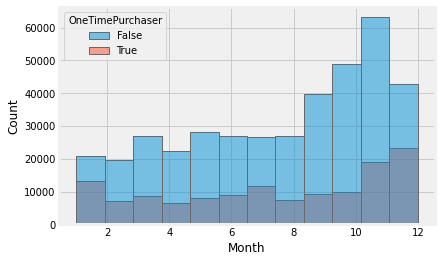

In [59]:
sns.histplot(data=df_cleaned, x='Month', bins=12, hue='OneTimePurchaser')

<AxesSubplot:xlabel='Weekday', ylabel='Count'>

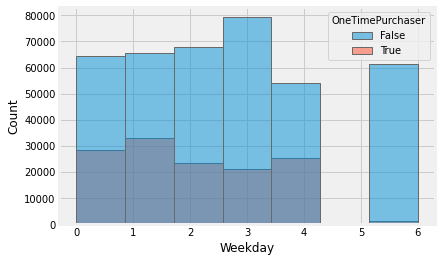

In [60]:
sns.histplot(data=df_cleaned, x='Weekday', bins=7, hue='OneTimePurchaser')

<AxesSubplot:xlabel='Day', ylabel='Count'>

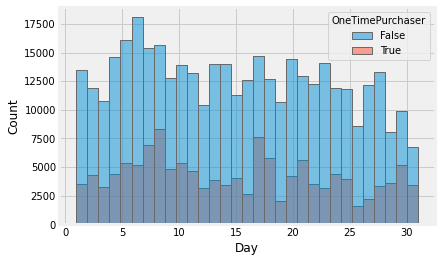

In [61]:
sns.histplot(data=df_cleaned, x='Day', bins=31, hue='OneTimePurchaser')

<AxesSubplot:xlabel='Hour', ylabel='Count'>

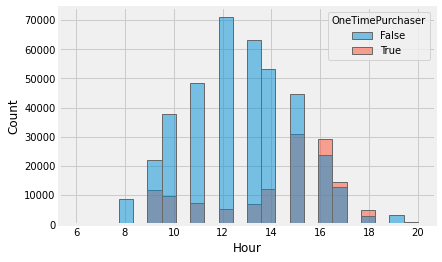

In [62]:
sns.histplot(data=df_cleaned, x='Hour', bins=24, hue='OneTimePurchaser')

#### Look at StockCode

Above, it has been seen that some values of the ** StockCode ** field indicate a particular transaction (i.e. D for _Discount_). I check the contents of this field by looking for the set of codes that would contain only letters:

In [63]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0069',
       'DCGSSBOY', 'DCGSSGIRL', 'gift_0001_10', 'S', 'PADS', 'DCGS0004',
       'B'], dtype=object)

In [64]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
DOT             -> DOTCOM POSTAGE                
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
AMAZONFEE       -> AMAZON FEE                    
DCGS0076        -> SUNJAR LED NIGHT NIGHT LIGHT  
DCGS0003        -> BOXED GLASS ASHTRAY           
gift_0001_40    -> Dotcomgiftshop Gift Voucher £40.00
DCGS0070        -> CAMOUFLAGE DOG COLLAR         
m               -> Manual                        
gift_0001_50    -> Dotcomgiftshop Gift Voucher £50.00
gift_0001_30    -> Dotcomgiftshop Gift Voucher £30.00
gift_0001_20    -> Dotcomgiftshop Gift Voucher £20.00
DCGS0069        -> OOH LA LA DOGS COLLAR         
DCGSSBOY        -> BOYS PARTY BAG                
DCGSSGIRL       -> GIRLS PARTY BAG               
gift_0001_10    -> Dotcomgiftshop Gift Voucher £10.00
S               -> SAMPLES    

In [65]:
print("{} entries removed".format(len(df_cleaned[df_cleaned['StockCode'].isin(list_special_codes)])))
df_cleaned=df_cleaned[-df_cleaned['StockCode'].isin(list_special_codes)]

2463 entries removed


We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges. For better product segmentation, I will remove such transactions.


___
#### Basket Price

I create a new field that indicates the total price of every purchase:

In [66]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

InvoiceNo StockCode                     Description  Quantity  \
61619     541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
72274     542237    84558A    3D DOG PICTURE PLAYING CARDS        12   
148304    549222    84559A        3D SHEET OF DOG STICKERS        12   
148303    549222     22492         MINI PAINT SET VINTAGE         36   
148302    549222     21731   RED TOADSTOOL LED NIGHT LIGHT        12   

               InvoiceDate  UnitPrice CustomerID         Country  \
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom   
72274  2011-01-26 14:30:00       2.95      12347         Iceland   
148304 2011-04-07 10:43:00       0.85      12347         Iceland   
148303 2011-04-07 10:43:00       0.65      12347         Iceland   
148302 2011-04-07 10:43:00       1.65      12347         Iceland   

        OneTimePurchaser  QuantityCanceled  Month  Weekday  Day  Hour  \
61619              False             74215      1        1   18    10   
72274              False                 0      1        2   26    14   
148304             False                 0      4        3    7    10   
148303             False                 0      4        3    7    10   
148302             False                 0      4        3    7    10   

        TotalPrice  
61619          0.0  
72274         35.4  
148304        10.2  
148303        23.4  
148302        19.8

Text(0.5, 1.0, 'Revenue per Country')

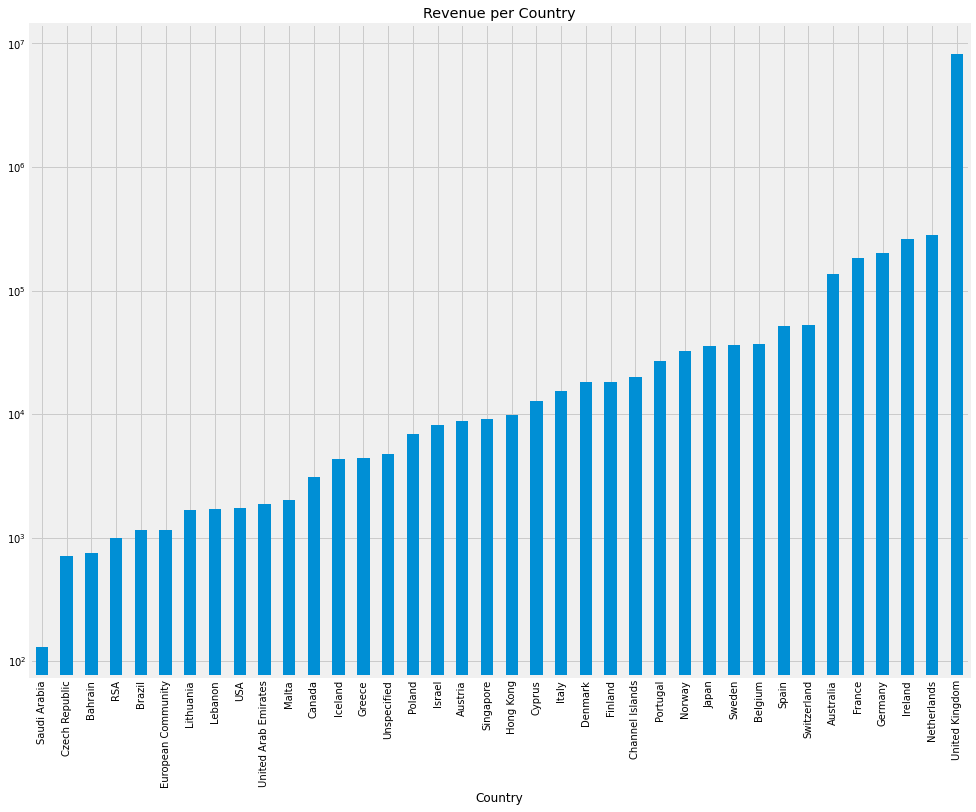

In [67]:
revenue_per_countries = df_cleaned.groupby(["Country"])["TotalPrice"].sum().sort_values()
revenue_per_countries.plot(kind='bar', figsize=(15,12))
plt.yscale('log')
plt.title("Revenue per Country")

Each entry of the dataframe indicates prices for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made during a single order to recover the total order price:

In [68]:
#___________________________________________
# sum of purchases / user and orders
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo', 'OneTimePurchaser'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# order date
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo', 'OneTimePurchaser'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of significant entries:
# basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('Basket Price', ascending=False)[:6]

CustomerID InvoiceNo  OneTimePurchaser  Basket Price         InvoiceDate
19774     574941    574941              True      52940.94 2011-11-07 17:42:00
19808     576365    576365              True      50653.91 2011-11-14 17:55:00
15744      17450    567423             False      27872.80 2011-09-20 11:05:00
158        12415    556917             False      22775.93 2011-06-15 13:37:00
17885      18102    572209             False      22206.00 2011-10-21 12:08:00
15741      17450    567381             False      22104.80 2011-09-20 10:12:00

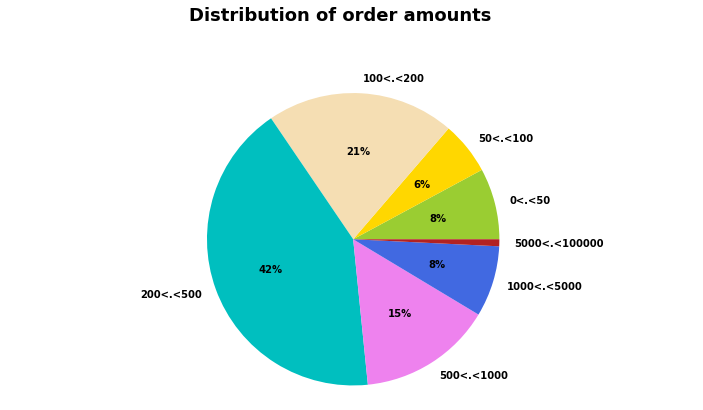

In [69]:
# Show distribution of basket prices in pie chart. 
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 100000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
# Representation of the number of purchases / amount        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

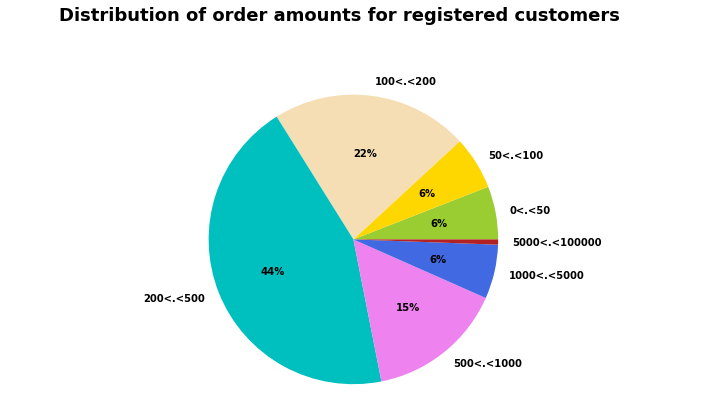

In [70]:
# Distribution of basket prices for registered customers
basket_price_wid = basket_price[basket_price['OneTimePurchaser']==False]
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 100000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price_wid[(basket_price_wid['Basket Price'] < price) &
                           (basket_price_wid['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
# Representation of the number of purchases / amount        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts for registered customers", ha='center', fontsize = 18);

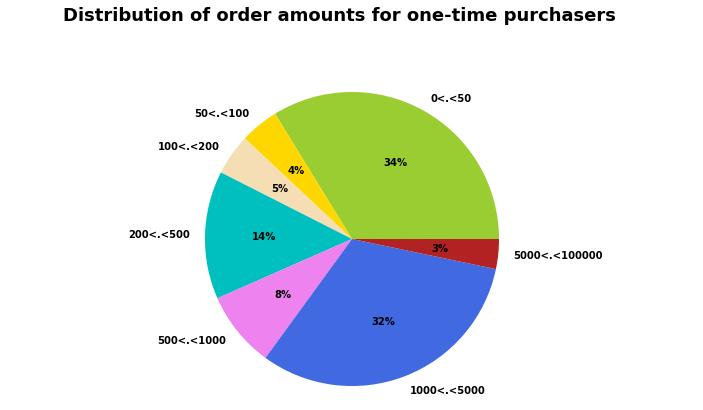

In [71]:
# Distribution of basket prices for one-time purchaser
basket_price_noid = basket_price[basket_price['OneTimePurchaser']]
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 100000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price_noid[(basket_price_noid['Basket Price'] < price) &
                           (basket_price_noid['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
# Representation of the number of purchases / amount        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts for one-time purchasers", ha='center', fontsize = 18);

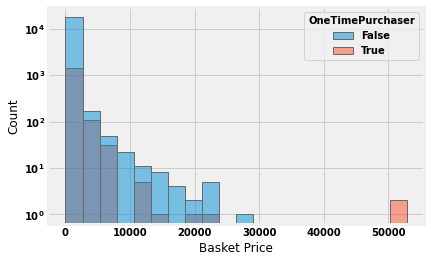

In [72]:
# make histogram distributions of the basket prices 
sns.histplot(basket_price, x='Basket Price', bins=20, hue='OneTimePurchaser')
plt.yscale('log')

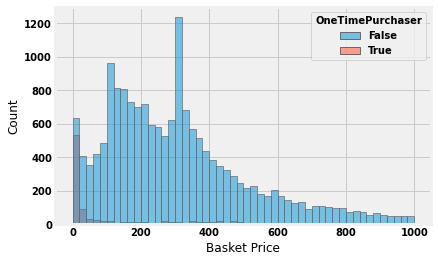

In [73]:
xmax = 1000
temp = basket_price[basket_price['Basket Price'] <= xmax]
sns.histplot(temp, x='Basket Price', bins=50, hue='OneTimePurchaser')
plt.show()

It can be seen that the vast majority of orders concern relatively large purchases given that $\sim$65% of purchases give prices in excess of £ 200. There's interesting aspects to this distribution, for example a spike arounf 300, and a rise around 100. 

Also, orders made by one-time purchasers have even higher amount (~35% of purchases give prices over £ 1000).

In [74]:
df_cleaned.Quantity.describe()

count    523076.000000
mean         10.708408
std         157.722964
min           1.000000
25%           1.000000
50%           4.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

## 3. Make Product Categories

In the dataframe, products are uniquely identified through the **StockCode** field. A short description of the products is given in the **Description** field. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

___
### Look at Products Description

As a first step, I extract from the **Description** field the information that will prove useful. To do this, I use the following function:

In [75]:
is_noun = lambda pos: pos[:2] == 'NN'
def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the **Description** column by performing the following operations:

- extract the names (proper, common) appearing in the products description
- for each name, I extract the root of the word and aggregate the set of names associated with this particular root
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [76]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [77]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1603


The execution of this function returns three values:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

At this point, I convert the `count_keywords` dictionary into a list, to sort the keywords according to their occurences:

In [78]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I create a representation of the most common keywords:

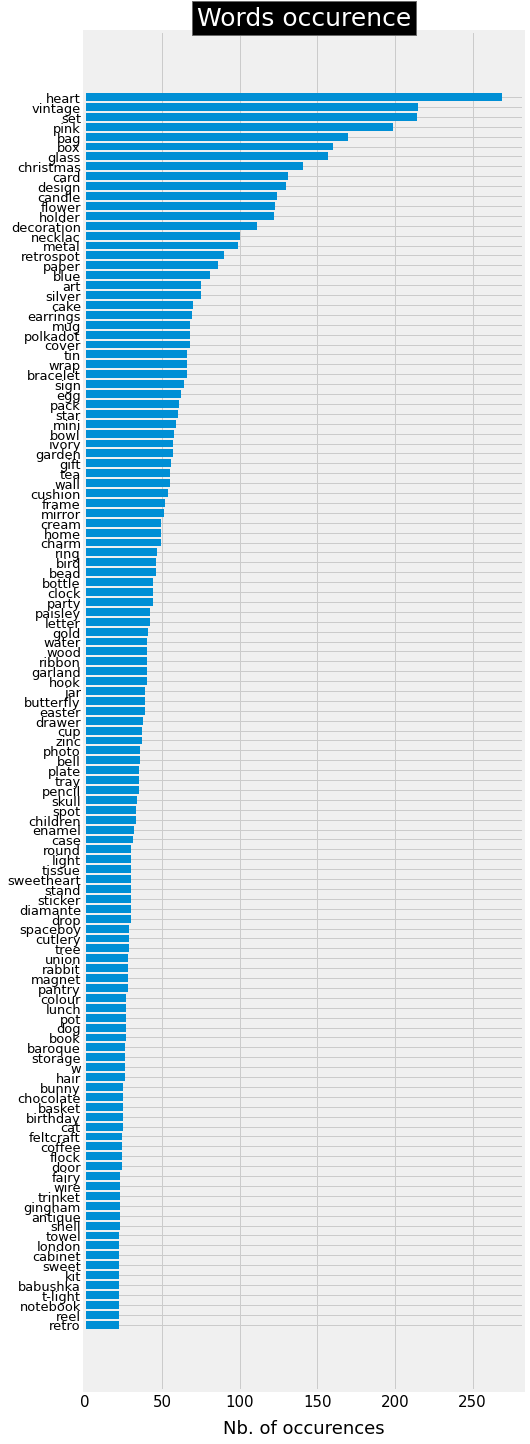

In [79]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

___
### Defining product categories 

###### The list that was obtained contains more than 1600 keywords and the most frequent ones appear in more than 200 products. However, while examinating the content of the list, I note that some names are useless. Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times.

In [80]:
# use predefined list of stopwords from NLTK package
nltk_stopwords = set(stopwords.words('english'))
# basic function that removes matched stopwords from a dictionary object
def remove_stopwords(corpus: dict):
    temp_dict = {} # create a temporary dictionary
    tokens = keywords_select.keys()
    filtered_tokens = list(filter(lambda token: token not in nltk_stopwords, tokens)) # filter for stopwords
    for i in filtered_tokens: # update the temporary dictionary
        temp_dict.update({i: i})
    print(f'{len(keywords_select.keys())-len(temp_dict.keys())} stopwords removed')
    return temp_dict

In [81]:
keywords_select = remove_stopwords(keywords_select) # also prints how many stopwords were removed

10 stopwords removed


In [82]:
# reflect the change on 'count_keywords' dict, too
count_keywords = {k: v for k, v in count_keywords.items() if k in keywords_select.keys()}

In [83]:
# remove some very common words
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange','candl','design','vintag',\
                'box', 'sign', 'vintage', 'glass', 'light', 'candle', 'flower']: continue
    if len(word) < 5 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('preserved words:', len(list_products))

preserved words: 121


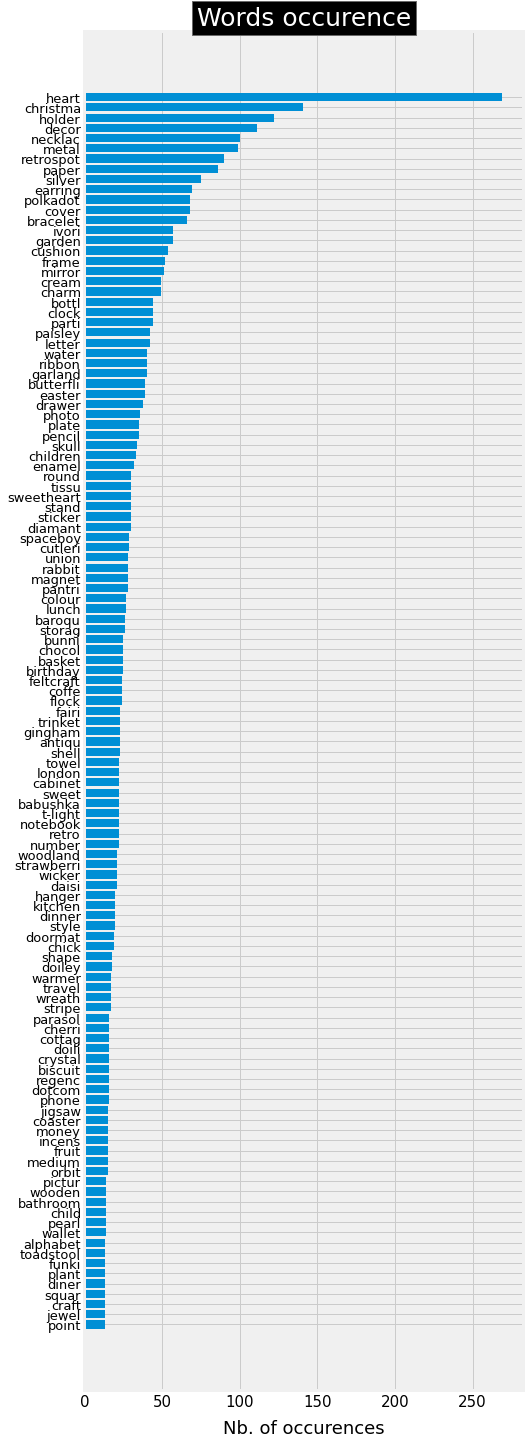

In [84]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

____
#### Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the $X$ matrix as:

   
|   | mot 1  |  ...  | mot j  | ...  | mot N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise. Here I have a row for each product and a column for each keyword. I fill in the entries with zero or 1, depending on whether that product has that keyword in its description.

In [85]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
X

heart  christma  holder  decor  necklac  metal  retrospot  paper  \
0         1         0       1      0        0      0          0      0   
1         0         0       0      0        0      1          0      0   
2         1         0       0      0        0      0          0      0   
3         0         0       0      0        0      0          0      0   
4         1         0       0      0        0      0          0      0   
...     ...       ...     ...    ...      ...    ...        ...    ...   
4050      0         0       0      0        0      0          0      0   
4051      0         0       0      0        0      0          0      0   
4052      0         0       0      0        0      0          0      0   
4053      1         0       1      0        0      0          0      0   
4054      0         0       0      0        0      0          0      1   

      silver  earring  ...  wallet  alphabet  toadstool  funki  plant  diner  \
0          0        0  ...       0         0          0      0      0      0   
1          0        0  ...       0         0          0      0      0      0   
2          0        0  ...       0         0          0      0      0      0   
3          0        0  ...       0         0          0      0      0      0   
4          0        0  ...       0         0          0      0      0      0   
...      ...      ...  ...     ...       ...        ...    ...    ...    ...   
4050       0        0  ...       0         0          0      0      0      0   
4051       0        0  ...       0         0          0      0      0      0   
4052       0        0  ...       0         0          0      0      0      0   
4053       0        0  ...       0         0          0      0      0      0   
4054       0        0  ...       0         0          0      0      0      0   

      squar  craft  jewel  point  
0         0      0      0      0  
1         0      0      0      0  
2         0      0      0      0  
3         0      0      0      0  
4         0      0      0      0  
...     ...    ...    ...    ...  
4050      0      0      0      0  
4051      0      0      0      0  
4052      0      0      0      0  
4053      0      0      0      0  
4054      0      1      0      0  

[4055 rows x 121 columns]

The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers.
Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [86]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

def categorize_price(price):
    j=0
    while price > threshold[j+1]:
        j+=1
        if j+1 == len(threshold): break
    return label_col[j]

prod_prices=df_cleaned[['Description','UnitPrice']].groupby('Description').mean()
prod_prices['PriceRange']=prod_prices['UnitPrice'].apply(categorize_price)
for col in label_col:
    prods=prod_prices[prod_prices['PriceRange']==col].index
    X.loc[[list(liste_produits).index(prod) for prod in prods],col]=1
X

heart  christma  holder  decor  necklac  metal  retrospot  paper  \
0         1         0       1      0        0      0          0      0   
1         0         0       0      0        0      1          0      0   
2         1         0       0      0        0      0          0      0   
3         0         0       0      0        0      0          0      0   
4         1         0       0      0        0      0          0      0   
...     ...       ...     ...    ...      ...    ...        ...    ...   
4050      0         0       0      0        0      0          0      0   
4051      0         0       0      0        0      0          0      0   
4052      0         0       0      0        0      0          0      0   
4053      1         0       1      0        0      0          0      0   
4054      0         0       0      0        0      0          0      1   

      silver  earring  ...  squar  craft  jewel  point  0<.<1  1<.<2  2<.<3  \
0          0        0  ...      0      0      0      0      0      0      0   
1          0        0  ...      0      0      0      0      0      0      0   
2          0        0  ...      0      0      0      0      0      0      0   
3          0        0  ...      0      0      0      0      0      0      0   
4          0        0  ...      0      0      0      0      0      0      0   
...      ...      ...  ...    ...    ...    ...    ...    ...    ...    ...   
4050       0        0  ...      0      0      0      0      0      0      1   
4051       0        0  ...      0      0      0      0      0      0      1   
4052       0        0  ...      0      0      0      0      1      0      0   
4053       0        0  ...      0      0      0      0      0      0      0   
4054       0        0  ...      0      1      0      0      0      0      1   

      3<.<5  5<.<10  .>10  
0         1       0     0  
1         1       0     0  
2         1       0     0  
3         0       1     0  
4         0       1     0  
...     ...     ...   ...  
4050      0       0     0  
4051      0       0     0  
4052      0       0     0  
4053      1       0     0  
4054      0       0     0  

[4055 rows x 127 columns]

and to choose the appropriate ranges, I check the number of products in the different groups:

In [87]:
X.iloc[:,-6:].sum()

0<.<1     775
1<.<2     995
2<.<3     736
3<.<5     737
5<.<10    593
.>10      219
dtype: int64

In [88]:
prod_prices.groupby('PriceRange').size()

PriceRange
.>10      219
0<.<1     775
1<.<2     995
2<.<3     736
3<.<5     737
5<.<10    593
dtype: int64

____
#### Create clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, cosine similarity/distance is a commonly-used measure of distance. Since **kmeans** method of sklearn uses a Euclidean distance, I defined my own functions to perform kmeans clustering using cosine distance. In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score as a measure of the "quality" of the segmentation.

In [89]:
def calculate_cosine_similarity(a,b):
    """Calculates the cosine similarity between two vectors"""
    dot_product=np.dot(a,b)
    len_a=np.sqrt(np.dot(a,a))
    len_b=np.sqrt(np.dot(b,b))
    return dot_product/(len_a*len_b+1e-9)

def get_closest_center(v,centers):
    """Find the center that given vector is closest to based on cosine similarity"""
    distances=[calculate_cosine_similarity(c,v) for c in centers]
    return distances.index(max(distances))

def get_center(c):
    """Calculate the center of a list of vectors by averaging the vectors after normalizing them to unit length"""
    return np.array([[i/np.sqrt(sum(i*i))] for i in c]).mean(axis=0)[0]

class KMeans_cosine(object):
    """KMeans clustering based on cosine distance"""
    def __init__(self,vectors,k,max_iter=30,min_sample=10,init_centers=None):
        self.vectors=vectors
        self.n=len(self.vectors)
        self.max_iter=max_iter
        self.min_sample=min_sample
        if init_centers is None:
            self.k=k
            self.centers=self.vectors[np.random.choice(self.n,self.k)]
        else:
            self.centers=init_centers
            self.k=len(init_centers)
        self.clusters=[[] for c in range(self.k)]
        self.labels=[]
        
    def update_cluster(self):
        """Assign vectors to the centers they are closest to"""
        labels=[]
        for v in self.vectors:
            index=get_closest_center(v,self.centers)
            labels.append(index)
            self.clusters[index].append(v)
        self.labels=labels
    
    def update_center(self):
        """Calculate the center of a list of vectors"""
        if min([len(c) for c in self.clusters])<self.min_sample:
            self.centers=self.vectors[np.random.choice(self.n,self.k)]
            self.clusters=[[] for c in range(self.k)]
            self.labels=[]
            return True
        
        new_centers=[]
        for c in self.clusters:
            center=get_center(c)
            new_centers.append(center)
        
        new_centers=np.array(new_centers)
        if (self.centers==new_centers).all():
            return False
        
        self.centers=new_centers
        self.clusters=[[] for c in range(self.k)]
        return True
        
    def fit(self):
        """Iteratively move centers until they have stabilized or the maximum number of iteration has reached"""
        self.update_cluster()
        count=0
        while self.update_center():
            self.update_cluster()
            count+=1
            if count==self.max_iter: 
                break

In [90]:
# generate the cosine distance matrix
dist_matrix=cdist(X,X,'cosine')

In [91]:
%%time
# this cell tries different # clusters for the products. It takes a while to run, and you can run it if you like

# iter_n=10
# avg_silhouette_scores={}
# for n_clusters in range(3,11):
#     tot_score=0
#     for i in range(iter_n):
#         kmeans = KMeans_cosine(X.values,k=n_clusters,min_sample=50)
#         kmeans.fit()
#         clusters = kmeans.labels
#         if pd.Series(clusters).nunique() == 1:
#             continue
#         silhouette_avg = silhouette_score(dist_matrix, clusters, metric='precomputed')
#         tot_score += silhouette_avg
#     avg_score = tot_score/iter_n
#     avg_silhouette_scores[n_clusters]=avg_score
#     print("For n_clusters =", n_clusters, "The average silhouette_score is:", avg_score)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 1.67 µs


###### Kmeans clustering starts with random locations for the k cluster centers and thus gets a diffrerent result each time it's run. So I performed many iterations for n_clusters from 3 to 10 to get a more statistically valid picture. Results are something like this:

For n_clusters = 3 The average silhouette_score is: 0.2751679459722236
For n_clusters = 4 The average silhouette_score is: 0.3318371500458421
For n_clusters = 5 The average silhouette_score is: 0.38268035608679263
For n_clusters = 6 The average silhouette_score is: 0.4022363207554388
For n_clusters = 7 The average silhouette_score is: 0.42185645237179764
For n_clusters = 8 The average silhouette_score is: 0.3888036122653111
For n_clusters = 9 The average silhouette_score is: 0.36044231876958566
For n_clusters = 10 The average silhouette_score is: 0.33404680276914245
CPU times: user 21min 4s, sys: 69.6 ms, total: 21min 4s
Wall time: 21min 3s

I chose 5 because it has a reasonably tight grouping with a reasonbly small number of clusters. After that, I run it a few times with k=5 to get a good clustering for that k.

You can run the above cell if you want to redo this calculation. 

###### I chose 5 because it has the highest average silhouette score across all iterations. After that, I ran a few more iterations with k=5 to find an near-optimal model with an average silhouette score above a particular threshold.

In [92]:
n_clusters=5
silhouette_avg=0
# init_centers=pd.read_csv('init_centers.csv').values

niter = 0
while silhouette_avg<0.51:
    #init_centers is provided to replicate one optimal solution I found through many iterations
#     kmeans = KMeans_cosine(X.values,n_clusters,min_sample=50,init_centers=init_centers)
    kmeans = KMeans_cosine(X.values,n_clusters,min_sample=50)
    kmeans.fit()
    clusters=kmeans.labels
    silhouette_avg = silhouette_score(dist_matrix, clusters, metric='precomputed')
    print(niter, "The average silhouette_score is :", silhouette_avg)
    niter = niter+1
clusters=np.array(clusters)

0 The average silhouette_score is : 0.25613191620853787
1 The average silhouette_score is : 0.3880511076856477
2 The average silhouette_score is : 0.36521146247673647
3 The average silhouette_score is : 0.3248306688606177
4 The average silhouette_score is : 0.3735538512178025
5 The average silhouette_score is : 0.5057582557969698
6 The average silhouette_score is : 0.4653793158723834
7 The average silhouette_score is : 0.5087830557345564
8 The average silhouette_score is : 0.20419794900696112
9 The average silhouette_score is : 0.42692599509388535
10 The average silhouette_score is : 0.34524314704781794
11 The average silhouette_score is : 0.3745449510263634
12 The average silhouette_score is : 0.37710348792338466
13 The average silhouette_score is : 0.2170054740039237
14 The average silhouette_score is : 0.5057582557969698
15 The average silhouette_score is : 0.3091813263793435
16 The average silhouette_score is : 0.2491006028015108
17 The average silhouette_score is : 0.5057582557969

#### Examine the clusters

I checked the number of elements in each class and did a sanity check by simply looking at the products in a cluster.

In [93]:
prods=pd.DataFrame([liste_produits,clusters]).T
prods.columns=['prod','cluster']
prods['cluster'].value_counts()

2    995
0    812
3    775
1    737
4    736
Name: cluster, dtype: int64

It's worth noting that because the majority of the matrix is sparse and a product must be categorized to one of the price baskets, the clustering result is dominated by the price range. In one extreme iteration, the six clusters are exactly separated by the price range.

In [94]:
prods[prods['cluster']==0].head(10)

prod cluster
3   KNITTED UNION FLAG HOT WATER BOTTLE       0
4        RED WOOLLY HOTTIE WHITE HEART.       0
5          SET 7 BABUSHKA NESTING BOXES       0
6     GLASS STAR FROSTED T-LIGHT HOLDER       0
15        BOX OF VINTAGE JIGSAW BLOCKS        0
16       BOX OF VINTAGE ALPHABET BLOCKS       0
17             HOME BUILDING BLOCK WORD       0
18             LOVE BUILDING BLOCK WORD       0
19          RECIPE BOX WITH METAL HEART       0
20                  DOORMAT NEW ENGLAND       0

In [95]:
prods[prods['cluster']==1].head(10)

prod cluster
0    WHITE HANGING HEART T-LIGHT HOLDER       1
1                   WHITE METAL LANTERN       1
2        CREAM CUPID HEARTS COAT HANGER       1
12    FELTCRAFT PRINCESS CHARLOTTE DOLL       1
14   BOX OF 6 ASSORTED COLOUR TEASPOONS       1
26            ALARM CLOCK BAKELIKE PINK       1
27            ALARM CLOCK BAKELIKE RED        1
28           ALARM CLOCK BAKELIKE GREEN       1
33      SET/2 RED RETROSPOT TEA TOWELS        1
34  ROUND SNACK BOXES SET OF4 WOODLAND        1

In [96]:
prods[prods['cluster']==2].head(10)

prod cluster
8             HAND WARMER RED POLKA DOT       2
9         ASSORTED COLOUR BIRD ORNAMENT       2
31          INFLATABLE POLITICAL GLOBE        2
32   VINTAGE HEADS AND TAILS CARD GAME        2
48                  SAVE THE PLANET MUG       2
49       VINTAGE BILLBOARD DRINK ME MUG       2
50      VINTAGE BILLBOARD LOVE/HATE MUG       2
61             STRAWBERRY CHARLOTTE BAG       2
73  CHARLIE & LOLA WASTEPAPER BIN FLORA       2
77               JAM MAKING SET PRINTED       2

In [97]:
prods[prods['cluster']==3].head(10)

prod cluster
29     PANDA AND BUNNIES STICKER SHEET       3
30                    STARS GIFT TAPE        3
38     CHARLOTTE BAG DOLLY GIRL DESIGN       3
42          MINI JIGSAW CIRCUS PARADE        3
43                MINI JIGSAW SPACEBOY       3
44             MINI PAINT SET VINTAGE        3
64       SET/6 RED SPOTTY PAPER PLATES       3
68     PACK OF 72 RETROSPOT CAKE CASES       3
69      PACK OF 60 DINOSAUR CAKE CASES       3
70  PACK OF 60 PINK PAISLEY CAKE CASES       3

In [98]:
prods[prods['cluster']==4].head(10)

prod cluster
7           HAND WARMER UNION JACK       4
10      POPPY'S PLAYHOUSE BEDROOM        4
11       POPPY'S PLAYHOUSE KITCHEN       4
13         IVORY KNITTED MUG COSY        4
35             SPACEBOY LUNCH BOX        4
36         LUNCH BOX I LOVE LONDON       4
37        CIRCUS PARADE LUNCH BOX        4
39   RED TOADSTOOL LED NIGHT LIGHT       4
58         JUMBO BAG PINK POLKADOT       4
59  JUMBO  BAG BAROQUE BLACK WHITE       4

In [99]:
cluster_price=X[['0<.<1', '1<.<2', '2<.<3', '3<.<5','5<.<10', '.>10']].copy()
cluster_price['cluster']=clusters
cluster_price.groupby('cluster').mean()

0<.<1  1<.<2  2<.<3  3<.<5    5<.<10      .>10
cluster                                                
0          0.0    0.0    0.0    0.0  0.730296  0.269704
1          0.0    0.0    0.0    1.0  0.000000  0.000000
2          0.0    1.0    0.0    0.0  0.000000  0.000000
3          1.0    0.0    0.0    0.0  0.000000  0.000000
4          0.0    0.0    1.0    0.0  0.000000  0.000000


**a / _Silhouette intra-cluster score_**

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

In [100]:
 def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
#     plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

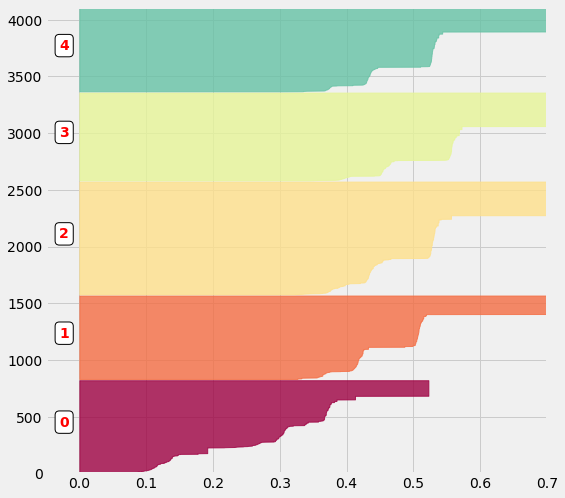

In [101]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(dist_matrix, clusters,metric="precomputed")
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.05, 0.7], len(X), sample_silhouette_values, clusters)

**b/ _Word Cloud_**

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [102]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]
occurence = [dict() for _ in range(n_clusters)]
for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag',]: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

and I output the result as wordclouds:

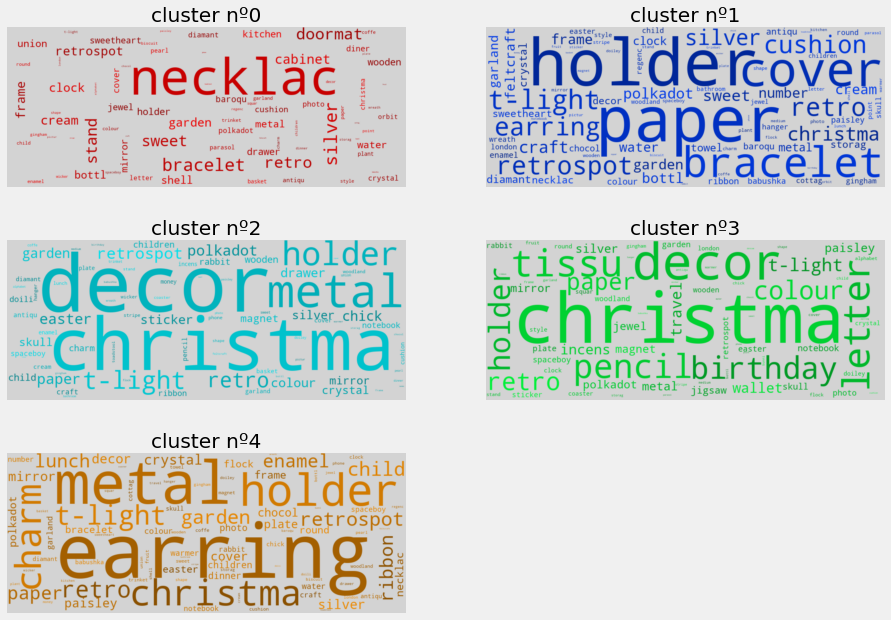

In [103]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

Even with fine tuning and many iterations, we can still find many words appearing in various clusters. This imperfect result is expected because at the end of the day machines can only do what we tell them to do, in our case here, that is to find similar words based on how they are spelled, not what they mean. The machine has no way to know "cushion" is closer to "cabinet" than it is to "bracelet". In real world, it's very unlikely a business will do unsupervised product segmentation like this.

**c / _Principal Component Analysis_**

In order to ensure that these clusters are reasonably distinct, I look at their composition in a relevant low dimensional space. Given the large number of variables of the initial matrix, I first perform a PCA:

In [104]:
# Perform PCA to subsequently check distinctness between clusters.
matrix=X.values
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

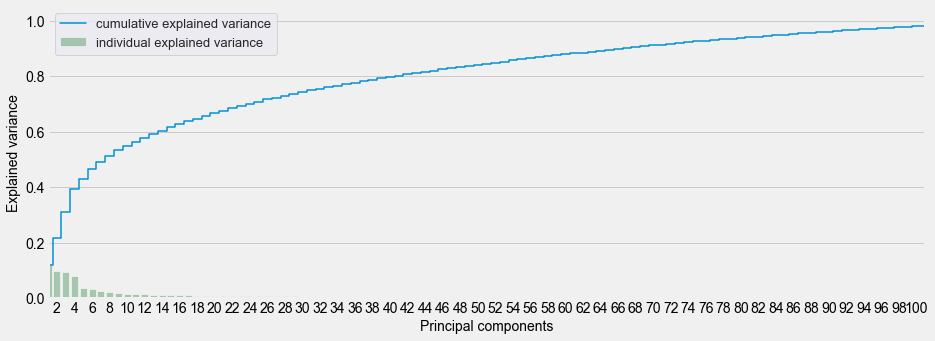

In [105]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])
plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. So we find that the space contains lots of variance in many non correlated directions, and PCA doesn't really help that much. In practice, I decide to keep only a limited number of components since this decomposition is only performed to visualize the data:

In [106]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

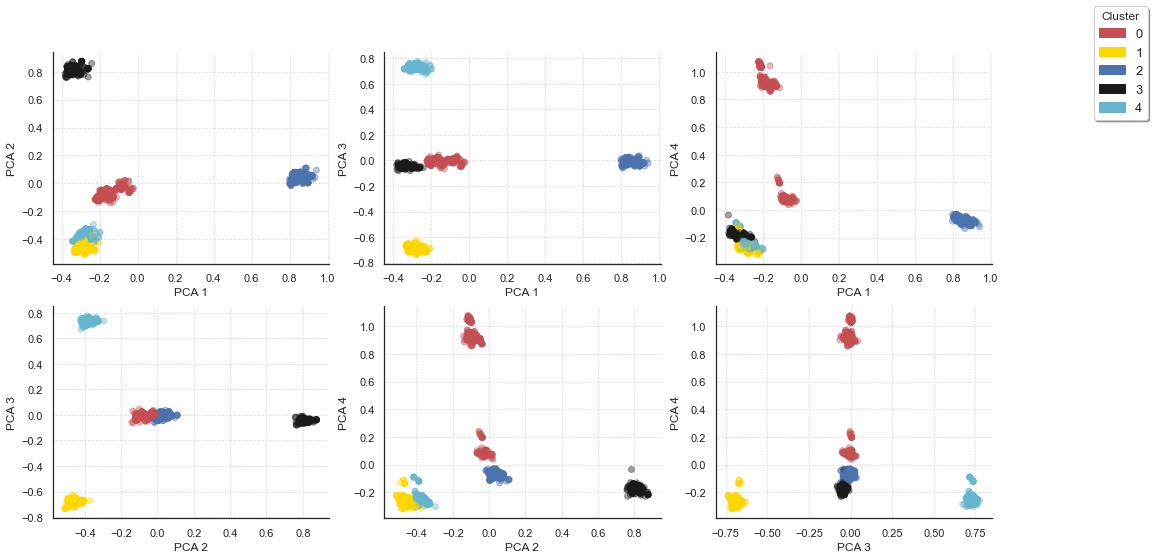

In [107]:
import matplotlib.patches as mpatches
sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]
fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

___
## 4. Make Customer Categories

### Formatting data

In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable **categ_product** where I indicate the cluster of each product :

In [108]:
# Append product category per above clustering to dataframe.
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  \
0      2010-12-01 08:26:00       2.55      17850  United Kingdom   
1      2010-12-01 08:26:00       3.39      17850  United Kingdom   
2      2010-12-01 08:26:00       2.75      17850  United Kingdom   
3      2010-12-01 08:26:00       3.39      17850  United Kingdom   
4      2010-12-01 08:26:00       3.39      17850  United Kingdom   
...                    ...        ...        ...             ...   
541904 2011-12-09 12:50:00       0.85      12680          France   
541905 2011-12-09 12:50:00       2.10      12680          France   
541906 2011-12-09 12:50:00       4.15      12680          France   
541907 2011-12-09 12:50:00       4.15      12680          France   
541908 2011-12-09 12:50:00       4.95      12680          France   

        OneTimePurchaser  QuantityCanceled  Month  Weekday  Day  Hour  \
0                  False                 0     12        2    1     8   
1                  False                 0     12        2    1     8   
2                  False                 0     12        2    1     8   
3                  False                 0     12        2    1     8   
4                  False                 0     12        2    1     8   
...                  ...               ...    ...      ...  ...   ...   
541904             False                 0     12        4    9    12   
541905             False                 0     12        4    9    12   
541906             False                 0     12        4    9    12   
541907             False                 0     12        4    9    12   
541908             False                 0     12        4    9    12   

        TotalPrice  categ_product  
0            15.30              1  
1            20.34              1  
2            22.00              1  
3            20.34              0  
4            20.34              0  
...            ...            ...  
541904       10.20              2  
541905       12.60              4  
541906       16.60              1  
541907       16.60              1  
541908       14.85              0  

[523076 rows x 16 columns]

___
#### Grouping products

In a second step, I decide to create the **categ_N** variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

In [109]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 
            'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

InvoiceNo                          Description  categ_product  categ_0  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER              1     0.00   
1    536365                  WHITE METAL LANTERN              1     0.00   
2    536365       CREAM CUPID HEARTS COAT HANGER              1     0.00   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE              0    20.34   
4    536365       RED WOOLLY HOTTIE WHITE HEART.              0    20.34   

   categ_1  categ_2  categ_3  categ_4  
0    15.30      0.0      0.0      0.0  
1    20.34      0.0      0.0      0.0  
2    22.00      0.0      0.0      0.0  
3     0.00      0.0      0.0      0.0  
4     0.00      0.0      0.0      0.0

By sales revenue, category 2, 4 and 0 are the top three categories.

In [110]:
df_cleaned[['categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']].sum().sort_values(ascending=False)

categ_0    2941973.72
categ_2    2070199.91
categ_1    2026290.45
categ_4    2024373.14
categ_3     698873.06
dtype: float64

Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [111]:
# Create dataframe which combines purchase information for each distinct Invoice Number. 
#___________________________________________
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# percentage of the price of the order / product category
for i in range(n_clusters):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp.loc[:, col]
#_____________________
# order date
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
1      12347    537626        711.79   137.59   351.00    147.6    23.40   
2      12347    542237        475.39    72.25   188.30     76.6    57.84   
3      12347    549222        636.25    89.25   117.10    310.2    50.40   
4      12347    556201        382.52    70.90   170.86     35.4    21.00   
5      12347    562032        584.91   187.05   213.36     94.8    52.80   

   categ_4                   InvoiceDate  
1    52.20 2010-12-07 14:57:00.000000000  
2    80.40 2011-01-26 14:29:59.999999744  
3    69.30 2011-04-07 10:43:00.000000000  
4    84.36 2011-06-09 13:01:00.000000000  
5    36.90 2011-08-02 08:48:00.000000000

#### Separation of data over time

The dataframe `basket_price` contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 9 months to develop the model and the following 3 months to test it:

In [112]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [113]:
print(basket_price['InvoiceDate'])

1       2010-12-07 14:57:00.000000000
2       2011-01-26 14:29:59.999999744
3       2011-04-07 10:43:00.000000000
4       2011-06-09 13:01:00.000000000
5       2011-08-02 08:48:00.000000000
                     ...             
19949   2011-12-08 16:14:00.000000000
19950   2011-12-08 16:30:00.000000000
19951   2011-12-09 10:03:00.000000000
19952   2011-12-09 10:23:00.000000000
19953   2011-12-09 10:26:00.000000000
Name: InvoiceDate, Length: 19646, dtype: datetime64[ns]


In [114]:
basket_price_train = basket_price[basket_price['InvoiceDate'] < np.datetime64(datetime(2011,9,1))]
basket_price_test  = basket_price[basket_price['InvoiceDate'] >= np.datetime64(datetime(2011,9,1))]

In [115]:
basket_price.head()

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
1      12347    537626        711.79   137.59   351.00    147.6    23.40   
2      12347    542237        475.39    72.25   188.30     76.6    57.84   
3      12347    549222        636.25    89.25   117.10    310.2    50.40   
4      12347    556201        382.52    70.90   170.86     35.4    21.00   
5      12347    562032        584.91   187.05   213.36     94.8    52.80   

   categ_4                   InvoiceDate  
1    52.20 2010-12-07 14:57:00.000000000  
2    80.40 2011-01-26 14:29:59.999999744  
3    69.30 2011-04-07 10:43:00.000000000  
4    84.36 2011-06-09 13:01:00.000000000  
5    36.90 2011-08-02 08:48:00.000000000

____
#### Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits. For each customer, I also added the total dollar value of all his or her cancelled items as a percentage of total purchase amount, as well as the number of distinct products bought.

In [116]:
# Group all relevent information together for each customer.
#________________________________________________________________
# number of visits and stats on the cart amount / users
transactions_per_user_train=basket_price_train.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(n_clusters):
    col = 'categ_{}'.format(i)
    transactions_per_user_train.loc[:,col] = basket_price_train.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user_train['sum']*100

df_cleaned['CanceledValue']=df_cleaned['QuantityCanceled']*df_cleaned['UnitPrice']
transactions_per_user_train=transactions_per_user_train.merge(
    df_cleaned[['CustomerID','CanceledValue']].groupby('CustomerID').sum(),
    left_index=True,right_index=True)
transactions_per_user_train['canceled%']=transactions_per_user_train['CanceledValue']/transactions_per_user_train['sum']*100
transactions_per_user_train['canceled%']=transactions_per_user_train['canceled%'].apply(lambda x: 100 if x>100 else x)

transactions_per_user_train=transactions_per_user_train.merge(
    df_cleaned[['Description','CustomerID']].groupby('CustomerID').nunique().\
    rename(columns={'Description':'unique_prod'}),
    left_index=True,right_index=True)

transactions_per_user_train.drop(columns='CanceledValue',inplace=True)
transactions_per_user_train.index.name = None
transactions_per_user_train.reset_index(drop = False, inplace = True)

# transactions_per_user_train.drop(columns='CustomerID', inplace=True)
transactions_per_user_train.rename(columns={'index':'CustomerID'}, inplace=True)
transactions_per_user_train.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      5  382.52  711.79  558.172000  2790.86  19.959439   
1      12348      3  187.44  652.80  389.080000  1167.24   0.000000   
2      12350      1  294.40  294.40  294.400000   294.40   0.000000   
3      12352      3  104.35  296.50  173.726667   521.18  45.838290   
4      12353      1   89.00   89.00   89.000000    89.00  67.078652   

     categ_1    categ_2    categ_3    categ_4  canceled%  unique_prod  
0  37.286714  23.813448   7.361172  11.579226   0.000000          103  
1   0.000000  40.454405  53.582811   5.962784   0.000000           21  
2   0.000000  49.558424   3.464674  46.976902   0.000000           16  
3  19.014544   9.186845   0.000000  25.960321  23.087993           57  
4  19.887640  13.033708   0.000000   0.000000   0.000000            4

Finally, I define two additional variables that give the number of days elapsed since the first purchase (**FirstPurchase**) and the number of days since the last purchase (**LastPurchase**):

In [117]:
last_date = basket_price_train['InvoiceDate'].max().date()
first_registration = pd.DataFrame(basket_price_train.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price_train.groupby(by=['CustomerID'])['InvoiceDate'].max())
test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)
transactions_per_user_train.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user_train.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']
transactions_per_user_train[:5]

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      5  382.52  711.79  558.172000  2790.86  19.959439   
1      12348      3  187.44  652.80  389.080000  1167.24   0.000000   
2      12350      1  294.40  294.40  294.400000   294.40   0.000000   
3      12352      3  104.35  296.50  173.726667   521.18  45.838290   
4      12353      1   89.00   89.00   89.000000    89.00  67.078652   

     categ_1    categ_2    categ_3    categ_4  canceled%  unique_prod  \
0  37.286714  23.813448   7.361172  11.579226   0.000000          103   
1   0.000000  40.454405  53.582811   5.962784   0.000000           21   
2   0.000000  49.558424   3.464674  46.976902   0.000000           16   
3  19.014544   9.186845   0.000000  25.960321  23.087993           57   
4  19.887640  13.033708   0.000000   0.000000   0.000000            4   

   LastPurchase  FirstPurchase  
0            29            267  
1           148            258  
2           210            210  
3           162            196  
4           104            104

95% customers returned less than 11% of their purchase in value, purchased less than 241 different products and visited the shop less than 9 times.

"Canceled %" 95 quantile: 10.565874357668148


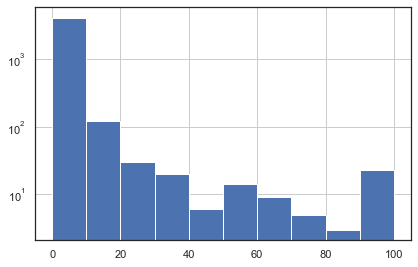

In [118]:
print('"Canceled %" 95 quantile:',transactions_per_user_train['canceled%'].quantile(0.95))
transactions_per_user_train['canceled%'].hist()
plt.yscale('log')

"Unique Products" 95 quantile: 241.0


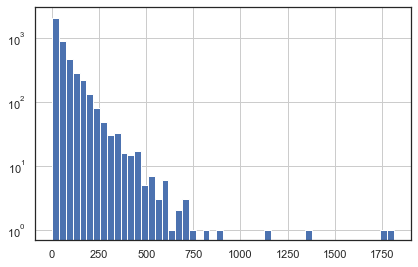

In [119]:
print('"Unique Products" 95 quantile:',transactions_per_user_train['unique_prod'].quantile(0.95))
transactions_per_user_train['unique_prod'].hist(bins=50)
plt.yscale('log')

"Count" 95 quantile: 9.0


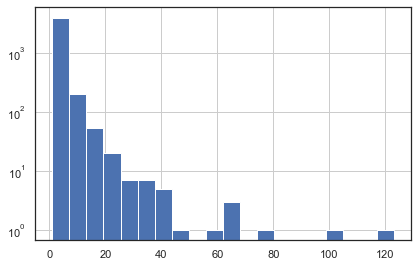

In [120]:
print('"Count" 95 quantile:',transactions_per_user_train['count'].quantile(0.95))
transactions_per_user_train['count'].hist(bins=20)
plt.yscale('log')

"Mean" 95 quantile: 1576.501000000001


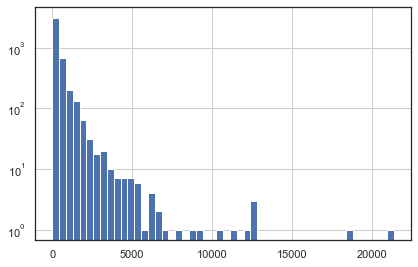

In [121]:
print('"Mean" 95 quantile:',transactions_per_user_train['mean'].quantile(0.95))
transactions_per_user_train['mean'].hist(bins=50)
plt.yscale('log')

In [122]:
transactions_per_user_train.describe()

count           min           max          mean            sum  \
count  4350.000000   4350.000000   4350.000000   4350.000000    4350.000000   
mean      2.828506    401.750271    607.336428    484.730693    1333.586062   
std       4.885209    878.774287   1202.848148    912.198666    4962.240830   
min       1.000000      0.420000      0.420000      0.420000       0.420000   
25%       1.000000     91.800000    171.685000    151.877500     203.890000   
50%       1.000000    190.550000    329.410000    279.128333     487.935000   
75%       3.000000    360.232500    608.982500    464.774688    1288.030000   
max     123.000000  21389.600000  22775.930000  21389.600000  175386.940000   

           categ_0      categ_1      categ_2      categ_3      categ_4  \
count  4350.000000  4350.000000  4350.000000  4350.000000  4350.000000   
mean     31.477908    20.173273    22.057111     8.407082    17.884626   
std      23.950112    17.080953    18.431681    13.482312    17.357086   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      13.922008     9.880059     9.329077     0.247144     6.121314   
50%      29.249801    18.351564    19.408064     4.697657    14.587804   
75%      43.371957    26.248942    29.795631    10.404444    24.416273   
max     100.000000   100.000000   100.000000   100.000000   100.000000   

         canceled%  unique_prod  LastPurchase  FirstPurchase  
count  4350.000000  4350.000000   4350.000000    4350.000000  
mean      2.409515    72.602299    104.290115     167.766667  
std       9.861000   100.128106     80.117266      79.274005  
min       0.000000     1.000000      0.000000       0.000000  
25%       0.000000    15.000000     34.000000     105.000000  
50%       0.000000    40.000000     85.000000     176.000000  
75%       0.604920    92.750000    163.000000     237.000000  
max     100.000000  1814.000000    273.000000     273.000000

In [123]:
transactions_per_user_train.quantile(0.97)

count              12.000000
min              1983.703800
max              2540.744700
mean             2058.225800
sum              5563.086000
categ_0           100.000000
categ_1            63.637319
categ_2            66.924079
categ_3            38.166519
categ_4            61.834600
canceled%          17.162010
unique_prod       303.530000
LastPurchase      266.000000
FirstPurchase     272.000000
Name: 0.97, dtype: float64

I capped the long tails at around 97% quantile.

In [124]:
transactions_per_user_train['count']=transactions_per_user_train['count'].clip(upper=15)
transactions_per_user_train['min']=transactions_per_user_train['min'].clip(upper=2000)
transactions_per_user_train['max']=transactions_per_user_train['max'].clip(upper=3000)
transactions_per_user_train['mean']=transactions_per_user_train['mean'].clip(upper=2500)
transactions_per_user_train['canceled%']=transactions_per_user_train['canceled%'].clip(upper=20)
transactions_per_user_train['unique_prod']=transactions_per_user_train['unique_prod'].clip(upper=350)

<AxesSubplot:xlabel='min', ylabel='max'>

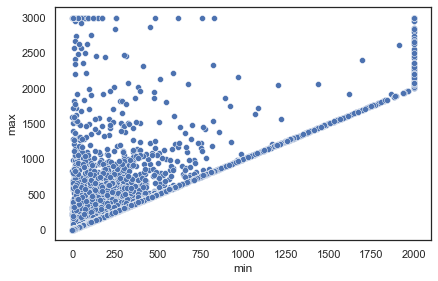

In [125]:
sns.scatterplot(data=transactions_per_user_train, x='min', y='max')

<AxesSubplot:xlabel='LastPurchase', ylabel='FirstPurchase'>

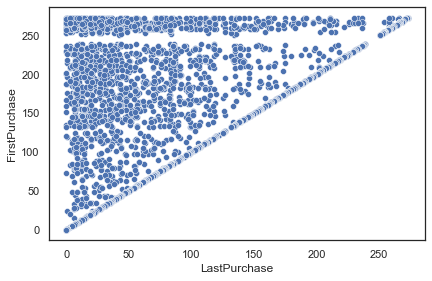

In [126]:
sns.scatterplot(data=transactions_per_user_train, x='LastPurchase', y='FirstPurchase')

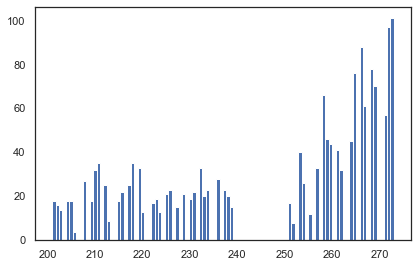

In [127]:
temp = transactions_per_user_train[transactions_per_user_train['FirstPurchase'] > 200]
fig = plt.hist(temp['FirstPurchase'], bins = 100)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='categ_0', ylabel='categ_1'>

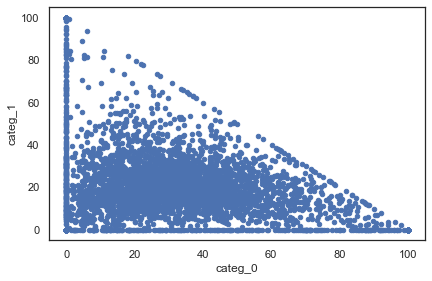

In [128]:
transactions_per_user_train.plot.scatter('categ_0','categ_1')

A customer category of particular interest is that of customers who make only one purchase. I find that this type of customer represents 1/3 of the customers listed. When doing customer segmentation, I'll put all these "one-time-buyers" into their own segment.

In [129]:
n1 = transactions_per_user_train[transactions_per_user_train['count'] == 1].shape[0]
n2 = transactions_per_user_train.shape[0]
print("number of customers with a single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))
print(f"number of customers with more than one purchases: {n2-n1}")

number of customers with a single purchase: 2424/4350  (55.72%)
number of customers with more than one purchases: 1926


Compared to multi-time buyers, one-time buyers have a lower canceled value percentage and slighly smaller average order size. In terms of product mix, there doesn't seem to be a big diffference.

In [130]:
selected_customers = transactions_per_user_train[transactions_per_user_train['count'] > 1].copy(deep = True)
single_buyers=transactions_per_user_train[transactions_per_user_train['count'] == 1]
customer_comparison=pd.DataFrame([single_buyers.mean().values,selected_customers.mean().values],
                                    columns=single_buyers.columns,
                                    index=['one_time_buyers','multi_time_buyers']).drop(columns='CustomerID')
customer_comparison

count         min         max        mean          sum  \
one_time_buyers    1.000000  462.588399  498.981984  483.029295   568.030540   
multi_time_buyers  4.587227  191.451064  575.179907  366.891167  2297.088962   

                     categ_0    categ_1    categ_2   categ_3    categ_4  \
one_time_buyers    32.845959  20.184721  21.268454  7.961745  17.739120   
multi_time_buyers  29.756123  20.158864  23.049690  8.967568  18.067755   

                   canceled%  unique_prod  LastPurchase  FirstPurchase  
one_time_buyers     0.930160    51.826320    139.849422     139.849422  
multi_time_buyers   2.318909    90.738837     59.536345     202.902388

___
### Creation of customers categories

#### Data encoding

The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [131]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4',
             'canceled%','unique_prod']
#_____________________________________________________________
matrix = selected_customers[list_cols].to_numpy()

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I  create a matrix where these data are standardized:

In [132]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  4.58722741 191.45106438 575.17990654 366.89116707  29.75612346
  20.15886358  23.04969021   8.96756817  18.06775458   2.3189091
  90.73883697]


In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [133]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:

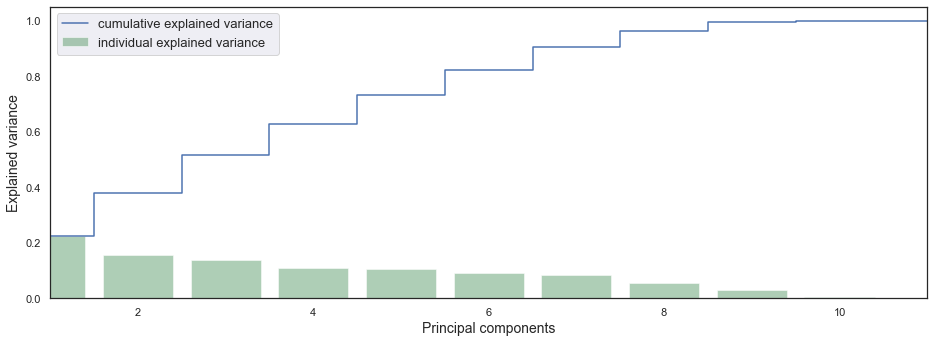

In [134]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13)

___
#### Creation of customer categories

In [135]:
# Try hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
for n in range(3,12):
    aggl = AgglomerativeClustering(n_clusters=n)
    #aggl.fit(scaled_matrix)
    clusters_clients = aggl.fit_predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
    print('number of clusters is ', n, '  silhouette score: {:<.3f}'.format(silhouette_avg))
    print(pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T,'\n')

number of clusters is  3   silhouette score: 0.194
                   0    1    2
nb. de clients  1580  193  153 

number of clusters is  4   silhouette score: 0.208
                   0    1    2    3
nb. de clients  1473  193  153  107 

number of clusters is  5   silhouette score: 0.172
                   0    1    4    2    3
nb. de clients  1290  193  183  153  107 

number of clusters is  6   silhouette score: 0.142
                   1    5    0    4    2    3
nb. de clients  1075  215  193  183  153  107 

number of clusters is  7   silhouette score: 0.153
                   0    5    1    6    4    3   2
nb. de clients  1075  215  183  153  124  107  69 

number of clusters is  8   silhouette score: 0.114
                  1    5    0    7    6    4    3   2
nb. de clients  894  215  183  181  153  124  107  69 

number of clusters is  9   silhouette score: 0.117
                  0    5    7    4    6    1    3   2   8
nb. de clients  894  215  181  169  153  124  107  69  14

I don't really like the results of using agglomerative clustering, so let's use kmeans instead.

In [136]:
for n in range(3,12):
    kmeans = KMeans(init='k-means++', n_clusters = n, n_init=100)
    kmeans.fit(scaled_matrix)
    clusters_clients = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
    print('number of clusters is ', n, '  silhouette score: {:<.3f}'.format(silhouette_avg))
    print(pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T,'\n')

number of clusters is  3   silhouette score: 0.124
                  2    0    1
nb. de clients  971  768  187 

number of clusters is  4   silhouette score: 0.143
                  0    1    2    3
nb. de clients  844  647  291  144 

number of clusters is  5   silhouette score: 0.150
                  2    1    0    3    4
nb. de clients  727  659  277  142  121 

number of clusters is  6   silhouette score: 0.164
                  0    5    2    4    3    1
nb. de clients  695  463  285  235  131  117 

number of clusters is  7   silhouette score: 0.162
                  1    0    2    3    4    5   6
nb. de clients  585  568  263  232  123  114  41 

number of clusters is  8   silhouette score: 0.161
                  2    6    0    3    1    5   4   7
nb. de clients  471  389  352  263  209  108  94  40 

number of clusters is  9   silhouette score: 0.169
                  3    4    1    5    7    8   2   0   6
nb. de clients  406  400  344  258  217  107  87  67  40 

number of c

It looks like k=6 is pretty good, so let's choose that. Redo it again and get a nice result with k=6.

In [137]:
n_clusters_cust= 6
kmeans = KMeans(init='k-means++', n_clusters = n_clusters_cust, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.164


At first, I look at the number of customers in each cluster:

In [138]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

2    1    5    4    3    0
nb. de clients  685  485  274  235  130  117

**a / Use PCA to visualise the segments**

There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

In [139]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

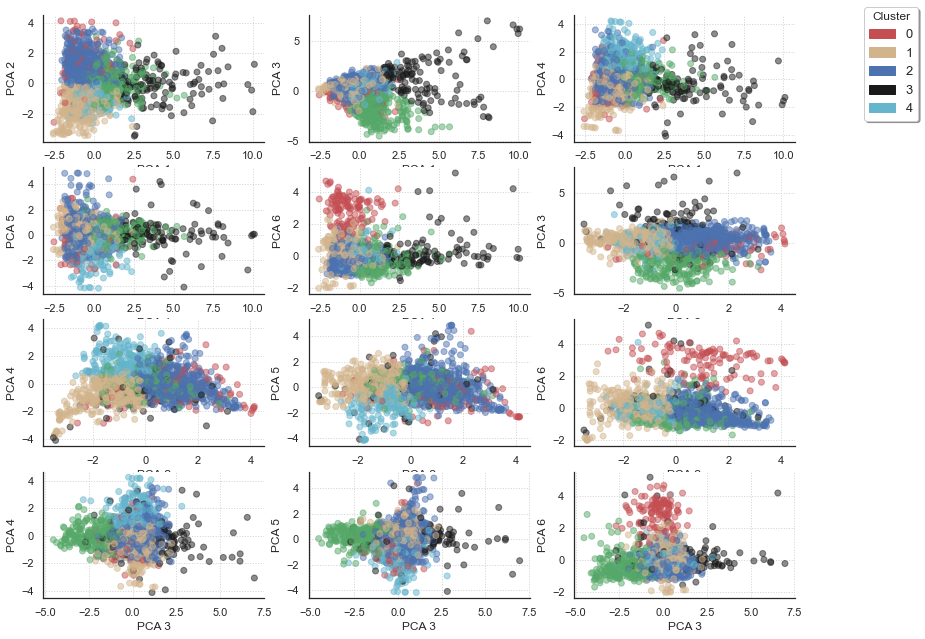

In [140]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', 
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

**b/ _Score de silhouette intra-cluster_**

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

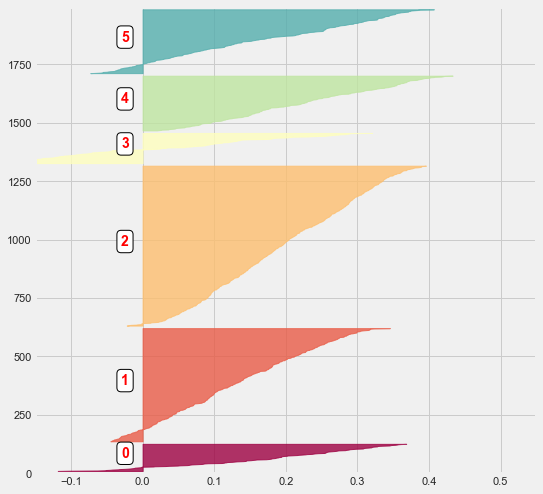

In [141]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters_cust, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

**c/ _Customers morphotype_**

At this stage, I have verified that the different clusters are reasonably disjoint (at least, in a global way). It remains to understand the behavior of the customers in each cluster. To do so, I start by adding to the `selected_customers` dataframe a variable that defines the cluster to which each client belongs:

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1926 samples in 0.001s...
[t-SNE] Computed neighbors for 1926 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1926
[t-SNE] Computed conditional probabilities for sample 1926 / 1926
[t-SNE] Mean sigma: 0.847095
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.977646
[t-SNE] KL divergence after 500 iterations: 1.310642


<AxesSubplot:xlabel='tsne-1', ylabel='tsne-2'>

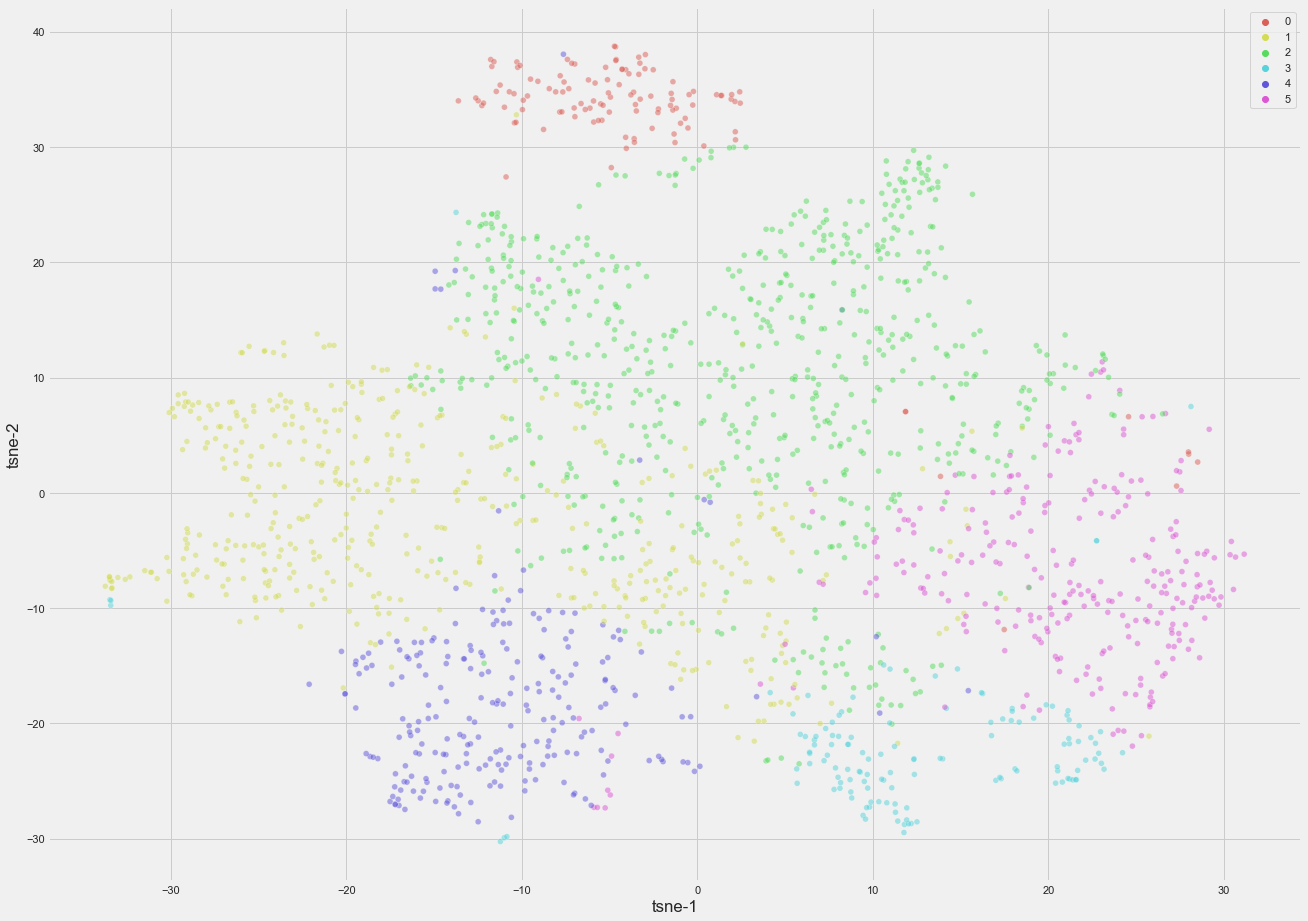

In [142]:
# We draw the TSNE plot to visualize the eight customer clusters.
plt.figure(figsize=(20,15))
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_ft = tsne.fit_transform(scaled_matrix)
km_data = pd.DataFrame(kmeans.predict(scaled_matrix), columns=['y'])
km_data['tsne-1'] = tsne_ft[:, 0]
km_data['tsne-2'] = tsne_ft[:, 1]
sns.scatterplot(x="tsne-1", y="tsne-2",hue=km_data["y"].tolist(), palette=sns.color_palette("hls", 6),
    data=km_data, legend="full", alpha=0.5)

In [143]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

In [144]:
merged_df = pd.DataFrame()
for i in range(n_clusters_cust):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 1926


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to canceled%, number of unique products, and the total amount spent:

In [145]:
liste_index = []
focused_cols=['categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 
              'canceled%', 'unique_prod','sum']
for col in focused_cols:
    idx=merged_df[col].idxmax()
    if idx not in liste_index:
        liste_index.append(idx)
liste_index_reordered = liste_index.copy()
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
merged_df['cluster']=merged_df['cluster'].astype(int)
merged_df

cluster      count         min          max         mean           sum  \
0        2   3.519708  170.541168   409.331766   281.427224    999.162263   
1        1   3.519588  178.266722   404.501938   284.381562   1000.862742   
2        4   3.685106  191.190894   448.456638   317.239285   1218.691915   
3        0   3.735043  133.135983   440.279915   273.458433   1163.904786   
4        5  10.153285  106.351569   828.183029   383.652655   5086.716168   
5        3   4.861538  583.135308  1903.066077  1263.561428  11061.685154   

     categ_0    categ_1    categ_2    categ_3    categ_4  canceled%  \
0  43.595809  24.401215  15.733943   5.161128  11.107903   1.169246   
1  16.235680  15.606724  37.874042  16.334693  13.948862   1.007308   
2  14.324663  16.031631  17.007988   6.030272  46.605445   1.296272   
3  37.781699  20.194620  20.299686   8.205063  13.518932  17.302921   
4  29.413122  20.245656  22.362517   8.517615  19.461089   2.176219   
5  28.668537  22.033568  21.136704   8.483881  19.677310   1.933777   

   unique_prod  LastPurchase  FirstPurchase  size  
0    61.617518     71.099270     199.408759   685  
1    69.940206     57.971134     187.804124   485  
2    63.948936     59.885106     199.089362   235  
3    61.991453     84.632479     198.820513   117  
4   215.412409     24.875912     243.083942   274  
5   133.307692     54.284615     203.515385   130

**d / _Customers morphology_**

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts" (which has been adapted from this [kernel](https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave -read-this)):

This allows to have a global view of the content of each cluster:

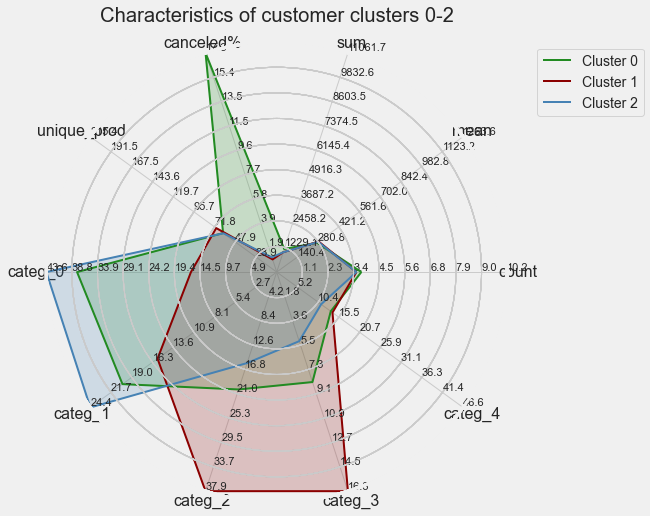

In [146]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]


class RadarChart():
    def __init__(self, fig, variables, ranges, n_ordinate_levels = 10):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.8,0.8], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]
        _, text = axes[0].set_thetagrids(angles, labels = variables, fontsize=16)
        
        for txt, angle in zip(text, angles):
            txt.set_rotation(angle - 90)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.1f}".format(x) for x in grid[1:]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)


attributes = ['count', 'mean', 'sum', 'canceled%','unique_prod',
               'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']

data_0_mean = merged_df[merged_df['cluster']==0][attributes].mean().values.reshape(1,-1)
data_1_mean = merged_df[merged_df['cluster']==1][attributes].mean().values.reshape(1,-1)
data_2_mean = merged_df[merged_df['cluster']==2][attributes].mean().values.reshape(1,-1)

datas = np.concatenate((data_0_mean,data_1_mean,data_2_mean),axis = 0)

ranges = [[0.01, merged_df[attr].max()] for attr in attributes]
colors = ["forestgreen", "darkred", "steelblue", "lightcoral", "goldenrod"]
cluster_types = ["Cluster 0", "Cluster 1", "Cluster 2"]

fig = plt.figure(figsize=(16, 8))
radar = RadarChart(fig, attributes, ranges)

for data, color, cluster_type in zip(datas, colors, cluster_types):
    radar.plot(data, color = color, label = cluster_type, linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = color)
    radar.legend(fontsize = 'medium', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Characteristics of customer clusters 0-2', pad=20)
plt.show()

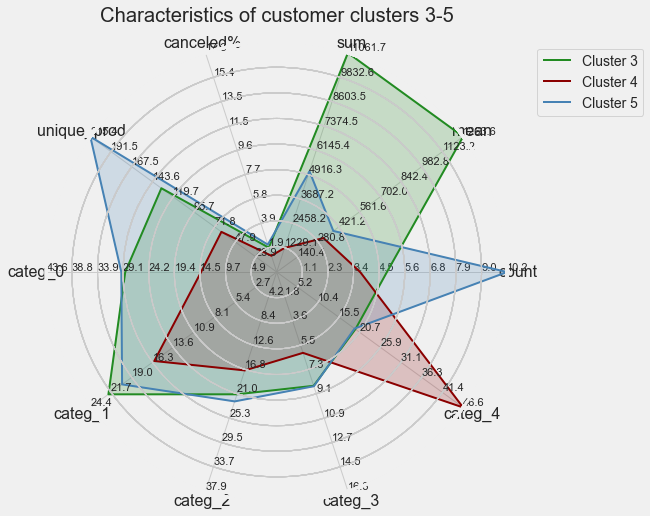

In [147]:
data_3_mean = merged_df[merged_df['cluster']==3][attributes].mean().values.reshape(1,-1)
data_4_mean = merged_df[merged_df['cluster']==4][attributes].mean().values.reshape(1,-1)
data_5_mean = merged_df[merged_df['cluster']==5][attributes].mean().values.reshape(1,-1)

datas = np.concatenate((data_3_mean,data_4_mean,data_5_mean),axis = 0)

cluster_types = ["Cluster 3", "Cluster 4", "Cluster 5"]

fig = plt.figure(figsize=(16, 8))
radar = RadarChart(fig, attributes, ranges)

for data, color, cluster_type in zip(datas, colors, cluster_types):
    radar.plot(data, color = color, label = cluster_type, linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = color)
    radar.legend(fontsize = 'medium', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Characteristics of customer clusters 3-5', pad=20)
plt.show()

It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (**mean**), the total sum spent by the clients (**sum**) or the total canceled value as a percent of total spent (**canceled%**).

## RFM Analysis

I use the lifetimes package to automatically generate RFM values.

In [148]:
from lifetimes.utils import summary_data_from_transaction_data
rfm = summary_data_from_transaction_data(
    basket_price_train, 'CustomerID', 'InvoiceDate', 'Basket Price', include_first_transaction=True
).reset_index()
rfm.head()

CustomerID  frequency  recency      T  monetary_value
0      12347        5.0    238.0  267.0      558.172000
1      12348        3.0    110.0  258.0      389.080000
2      12350        1.0      0.0  210.0      294.400000
3      12352        3.0     34.0  196.0      173.726667
4      12353        1.0      0.0  104.0       89.000000

In [149]:
# Merge with selected_customers dataset to get the cluster
rfm_merged = selected_customers.merge(rfm, how='left', on='CustomerID')
rfm_merged.head()

CustomerID  count     min      max         mean      sum    categ_0  \
0      12347      5  382.52   711.79   558.172000  2790.86  19.959439   
1      12348      3  187.44   652.80   389.080000  1167.24   0.000000   
2      12352      3  104.35   296.50   173.726667   521.18  45.838290   
3      12356      2  481.46  1947.62  1214.540000  2429.08  36.576811   
4      12359      3  547.50  1803.11  1153.310000  3459.93  69.063536   

     categ_1    categ_2    categ_3    categ_4  canceled%  unique_prod  \
0  37.286714  23.813448   7.361172  11.579226   0.000000          103   
1   0.000000  40.454405  53.582811   5.962784   0.000000           21   
2  19.014544   9.186845   0.000000  25.960321  20.000000           57   
3   5.775849  33.837502  10.366065  13.443773   0.000000           52   
4   9.396144   8.506530   2.524907  10.508883   4.900388          213   

   LastPurchase  FirstPurchase  cluster  frequency  recency      T  \
0            29            267        2        5.0    238.0  267.0   
1           148            258        1        3.0    110.0  258.0   
2           162            196        0        3.0     34.0  196.0   
3           145            225        3        2.0     80.0  225.0   
4            89            231        3        3.0    142.0  231.0   

   monetary_value  
0      558.172000  
1      389.080000  
2      173.726667  
3     1214.540000  
4     1153.310000

<AxesSubplot:xlabel='recency', ylabel='Count'>

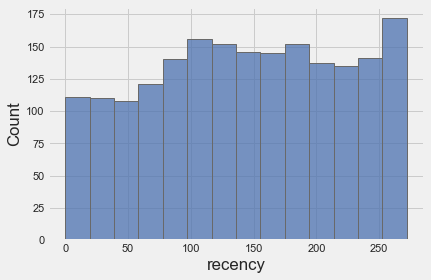

In [150]:
# Observe Recency distribution
sns.histplot(data=rfm_merged, x='recency') 

<AxesSubplot:xlabel='frequency', ylabel='Count'>

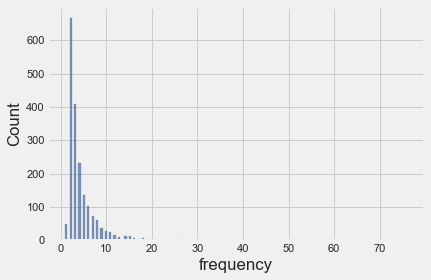

In [151]:
# Observe Recency distribution
sns.histplot(data=rfm_merged, x='frequency') 

<AxesSubplot:xlabel='log_frequency', ylabel='Count'>

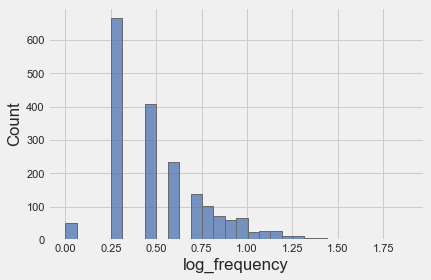

In [152]:
# Use log scale for better visualization
rfm_merged['log_frequency'] = rfm_merged['frequency'].apply(lambda x: math.log(x, 10))
sns.histplot(data=rfm_merged, x='log_frequency') 

<AxesSubplot:xlabel='monetary_value', ylabel='Count'>

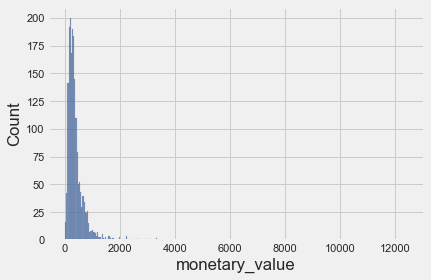

In [153]:
# Observe Monetary Value distribution
sns.histplot(data=rfm_merged, x='monetary_value') 

<AxesSubplot:xlabel='log_monetary_value', ylabel='Count'>

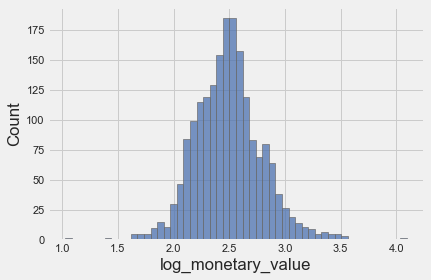

In [154]:
# Use log scale for better visualization
rfm_merged['log_monetary_value'] = rfm_merged['monetary_value'].apply(lambda x: math.log(x, 10))
sns.histplot(data=rfm_merged, x='log_monetary_value') 

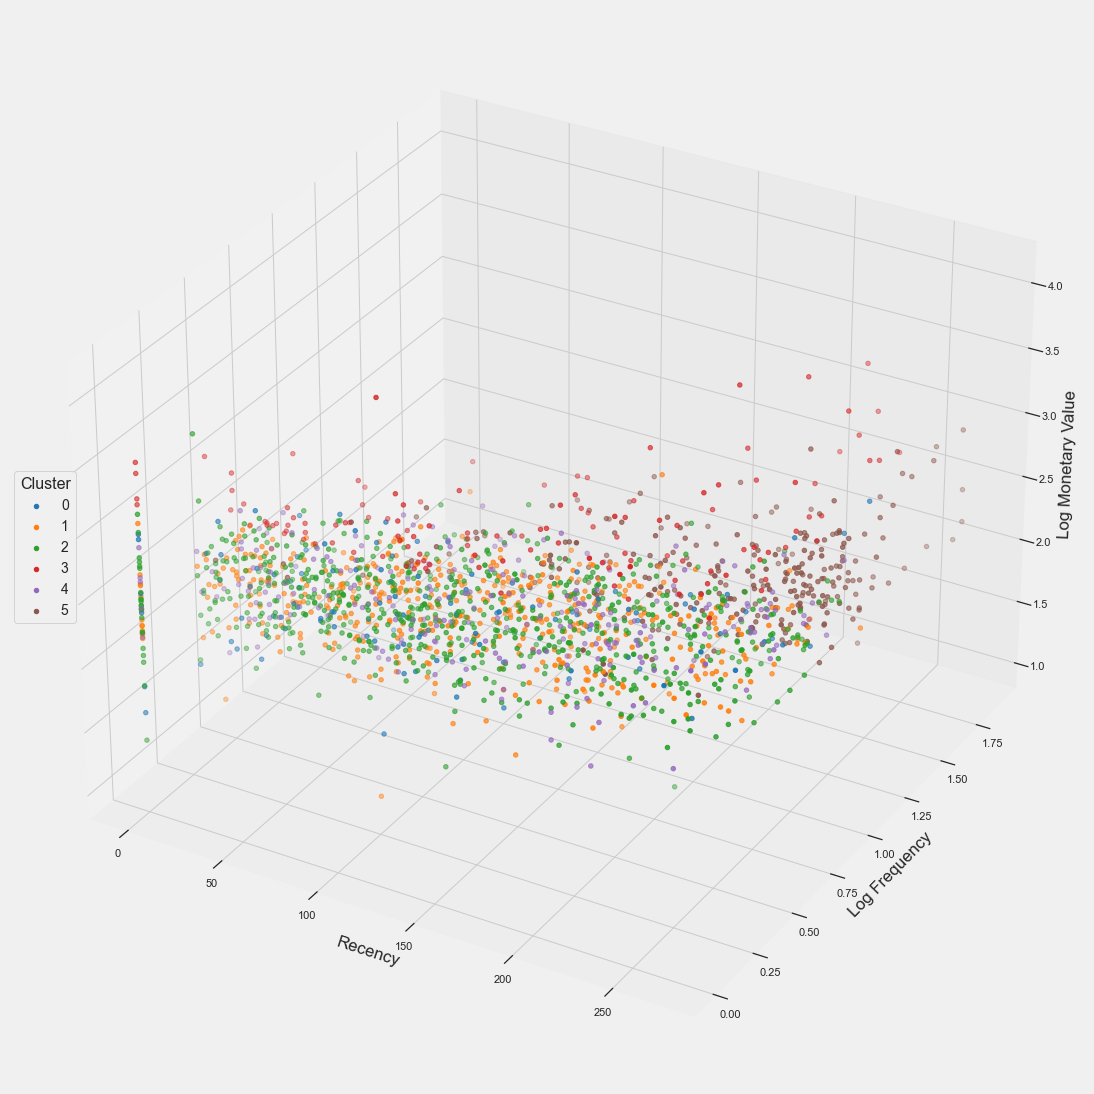

In [155]:
# Draw 3-D plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))
ax = Axes3D(
    fig, xlabel='Recency', ylabel='Log Frequency', zlabel='Log Monetary Value'
)
fig.add_axes(ax)

for cluster in range(0, 6):
    subset = rfm_merged[rfm_merged['cluster']==cluster]
    X, Y, Z = subset['recency'], subset['log_frequency'], subset['log_monetary_value']
    ax.scatter(
        X, Y, Z, color=plt.cm.get_cmap('tab10').colors[cluster], label=cluster
    )

ax.legend(title="Cluster", fontsize=14, title_fontsize=16, loc="center left")

plt.show()

It turned out that customers in cluster 2 (green) tend to have higher frequency and recency, whereas customers in cluster 4 have overall higher monetary value.

In [156]:
# Observe each dimension seperatly
rfm_cols = ['frequency', 'recency', 'monetary_value']
rfm_mean = rfm_merged.groupby('cluster').mean()[rfm_cols].reset_index()
rfm_mean

cluster  frequency     recency  monetary_value
0        0   3.478632  114.188034      315.214898
1        1   3.336082  129.832990      300.942354
2        2   3.286131  128.309489      306.846899
3        3   4.953846  149.230769     1665.437770
4        4   3.510638  139.204255      336.612733
5        5  11.459854  218.208029      452.097413

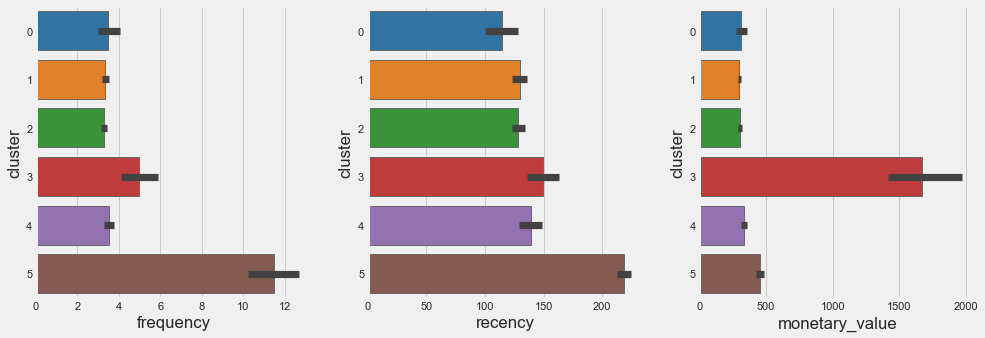

In [157]:
# Draw bar charts
fig = plt.figure(figsize=(15,5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.barplot(data=rfm_merged, x=rfm_cols[i], y='cluster', orient='h', palette='tab10')

plt.show()

## Cluster Analysis

In [158]:
# Make a normalized statistics table for customer clusters
stat_table = selected_customers.groupby('cluster').mean()
norm_table = stat_table / stat_table.mean()
norm_table

count       min       max      mean       sum   categ_0   categ_1  \
cluster                                                                         
0        0.760333  0.586235  0.595802  0.585205  0.340140  1.333319  1.022397   
1        0.716473  0.784958  0.547386  0.608580  0.292493  0.572958  0.790124   
2        0.716498  0.750940  0.553922  0.602258  0.291996  1.538499  1.235365   
3        0.989651  2.567706  2.575296  2.704039  3.232674  1.011715  1.115497   
4        0.750168  0.841866  0.606867  0.678896  0.356151  0.505518  0.811636   
5        2.066878  0.468295  1.120726  0.821022  1.486545  1.037991  1.024980   

          categ_2   categ_3   categ_4  canceled%  unique_prod  LastPurchase  \
cluster                                                                       
0        0.906136  0.933584  0.652461   4.171767     0.613556      1.439538   
1        1.690618  1.858586  0.673210   0.242864     0.692228      0.986048   
2        0.702330  0.587241  0.536098   0.281907     0.609855      1.209348   
3        0.943498  0.965309  0.949681   0.466237     1.319403      0.923342   
4        0.759201  0.686133  2.249306   0.312534     0.632930      1.018603   
5        0.998216  0.969147  0.939245   0.524690     2.132028      0.423121   

         FirstPurchase  
cluster                 
0             0.968500  
1             0.914837  
2             0.971366  
3             0.991370  
4             0.969810  
5             1.184117

<AxesSubplot:xlabel='cluster'>

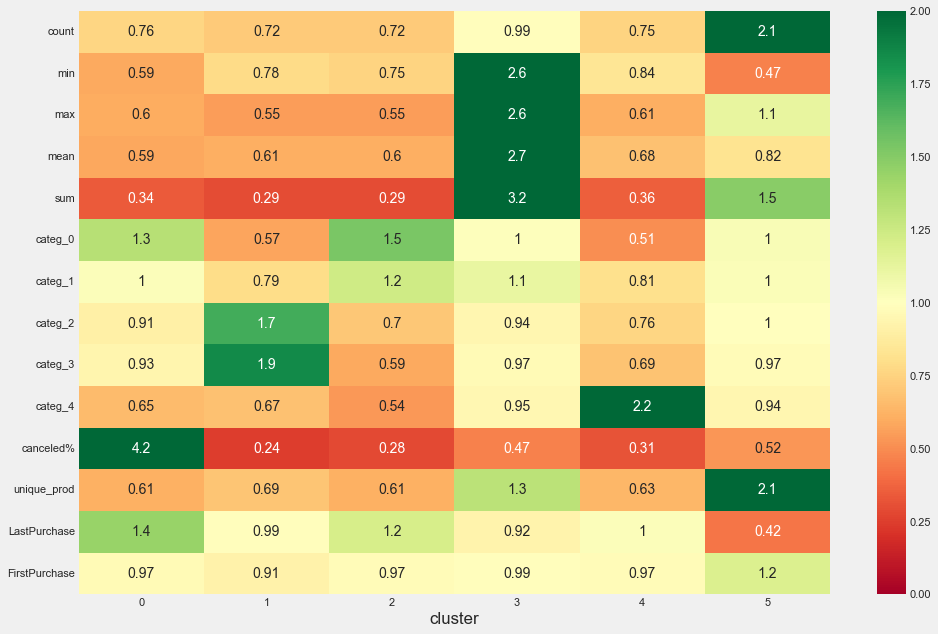

In [159]:
# Visualize segment attributes in customer clusters.
norm_table_transpose = norm_table.transpose()
plt.figure(figsize=(15,10))
sns.heatmap(norm_table_transpose, cmap='RdYlGn', annot=True, vmin=0, vmax=2)

#### - **Cluster 0**: Cancels many orders
- **Cluster 1**: Buys mostly category 2 products
- **Cluster 2**: likes category 0 and 3 products
- **Cluster 3**: likes category 1 and 2 products
- **Cluster 4**: buys many inexpensive products across many categories
- **Cluster 5**: buys expensive products across all categories

# 5. Make Customer Value Measures

### We want to build a Customer Value Measure using total spend as the base value and then modify this with four expert factors. We look at the distributions to decide on the shape parameters for the four expert factors.

In [160]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(n_clusters):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

df_cleaned['CanceledValue']=df_cleaned['QuantityCanceled']*df_cleaned['UnitPrice']
transactions_per_user=transactions_per_user.merge(
    df_cleaned[['CustomerID','CanceledValue']].groupby('CustomerID').sum(),
    left_index=True,right_index=True)
transactions_per_user['canceled%']=transactions_per_user['CanceledValue']/transactions_per_user['sum']*100
transactions_per_user['canceled%']=transactions_per_user['canceled%'].apply(lambda x: 100 if x>100 else x)

transactions_per_user=transactions_per_user.merge(
    df_cleaned[['Description','CustomerID']].groupby('CustomerID').nunique().\
    rename(columns={'Description':'unique_prod'}),
    left_index=True,right_index=True)

transactions_per_user.drop(columns='CanceledValue',inplace=True)
transactions_per_user.index.name = None
transactions_per_user.reset_index(drop = False, inplace = True)

transactions_per_user.rename(columns={'index':'CustomerID'}, inplace=True)

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

In [161]:
transactions_per_user['count']=transactions_per_user['count'].clip(upper=20)
transactions_per_user['min']=transactions_per_user['min'].clip(upper=2500)
transactions_per_user['max']=transactions_per_user['max'].clip(upper=3500)
transactions_per_user['mean']=transactions_per_user['mean'].clip(upper=3000)
transactions_per_user['canceled%']=transactions_per_user['canceled%'].clip(upper=15)
transactions_per_user['unique_prod']=transactions_per_user['unique_prod'].clip(upper=350)

In [162]:
cvm=transactions_per_user[['sum','count','max','unique_prod','canceled%']].copy()
cvm.rename(columns={'count':'num_visits','max':'max_order'},inplace=True)
print("Number of customers:",len(cvm))
cvm.describe()

Number of customers: 5695


sum   num_visits    max_order  unique_prod    canceled%
count    5695.000000  5695.000000  5695.000000  5695.000000  5695.000000
mean     1714.084334     3.141703   603.672014    65.755399     0.935067
std      7339.028818     3.803356   726.152027    78.689289     2.744697
min         0.420000     1.000000     0.420000     1.000000     0.000000
25%       230.900000     1.000000   185.425000    13.000000     0.000000
50%       601.560000     1.000000   358.380000    36.000000     0.000000
75%      1543.195000     4.000000   679.375000    85.000000     0.000000
max    278742.020000    20.000000  3500.000000   350.000000    15.000000

In [163]:
def f_score(x,mid,c,max_f):
    return 1+(max_f-1)/(1+math.e**(-(x-mid)/c))

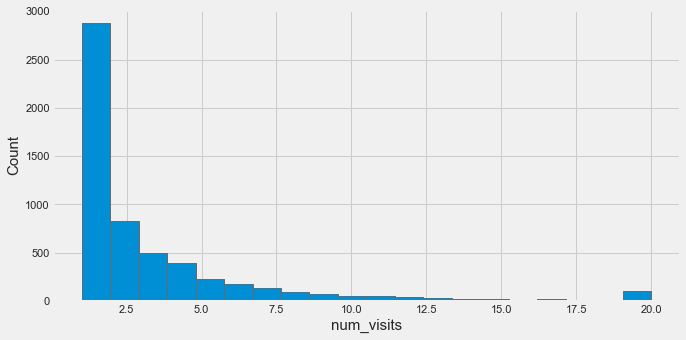

In [164]:
var='num_visits'
plt.figure(figsize=(10,5))
plt.hist(cvm[var],bins=20)
# cvm[var].hist(bins=20)
plt.xlabel(var,fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

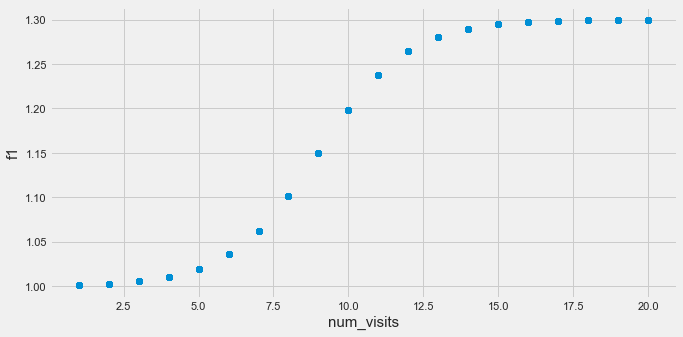

In [165]:
var='num_visits'
mid=9
c=1.5
max_f=1.3
cvm['f1']=cvm[var].apply(lambda x:f_score(x,mid,c,max_f))
plt.figure(figsize=(10,5))
plt.scatter(data=cvm,x=var,y='f1')
plt.xlabel(var,fontsize=15)
plt.ylabel('f1',fontsize=15)
# cvm.plot.scatter(var,'f1')
plt.show()

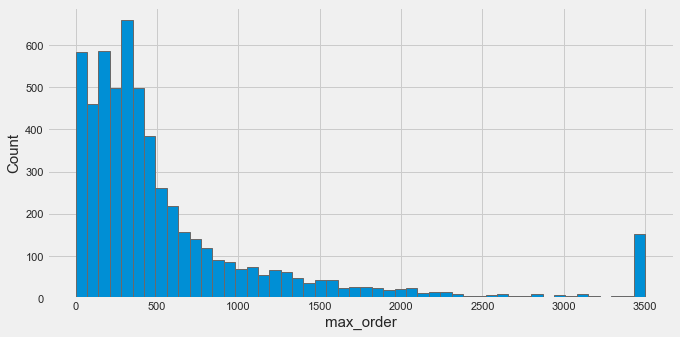

In [166]:
var='max_order'
plt.figure(figsize=(10,5))
plt.hist(cvm[var],bins=50)
plt.xlabel(var,fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

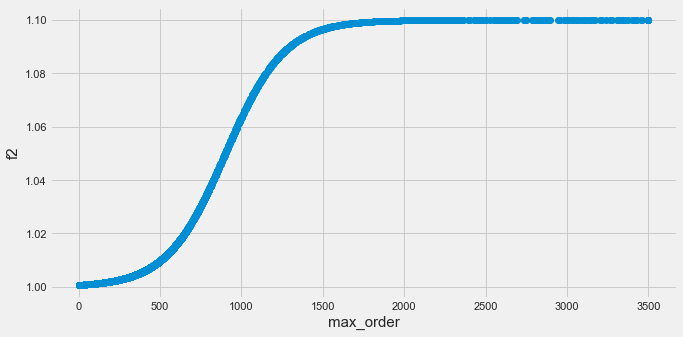

In [167]:
var='max_order'
mid=900
c=180
max_f=1.1
cvm['f2']=cvm[var].apply(lambda x:f_score(x,mid,c,max_f))
plt.figure(figsize=(10,5))
plt.scatter(data=cvm,x=var,y='f2')
plt.xlabel(var,fontsize=15)
plt.ylabel('f2',fontsize=15)
plt.show()

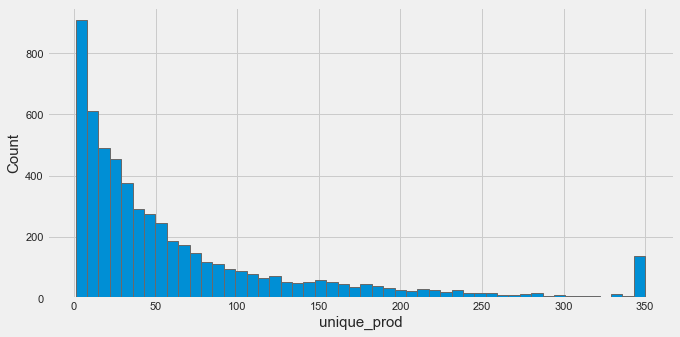

In [168]:
var='unique_prod'
plt.figure(figsize=(10,5))
plt.hist(cvm[var],bins=50)
plt.xlabel(var,fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

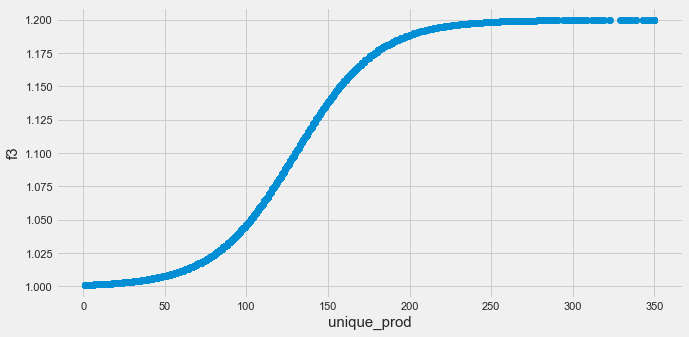

In [169]:
var='unique_prod'
mid=130
c=25
max_f=1.2
cvm['f3']=cvm[var].apply(lambda x:f_score(x,mid,c,max_f))
plt.figure(figsize=(10,5))
plt.scatter(data=cvm,x=var,y='f3')
plt.xlabel(var,fontsize=15)
plt.ylabel('f3',fontsize=15)
plt.show()

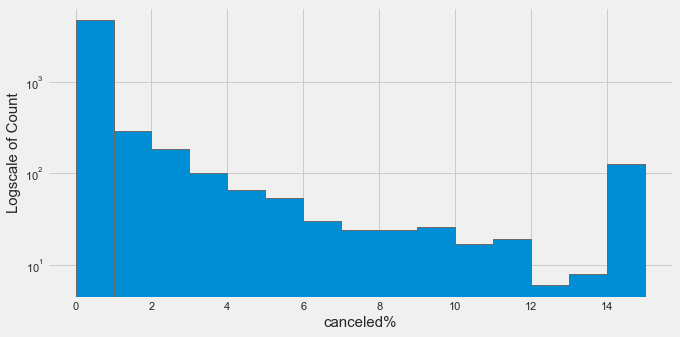

In [170]:
var='canceled%'
plt.figure(figsize=(10,5))
plt.hist(cvm[var],bins=15)
plt.xlabel(var,fontsize=15)
plt.ylabel('Logscale of Count',fontsize=15)
plt.yscale('log')
plt.show()

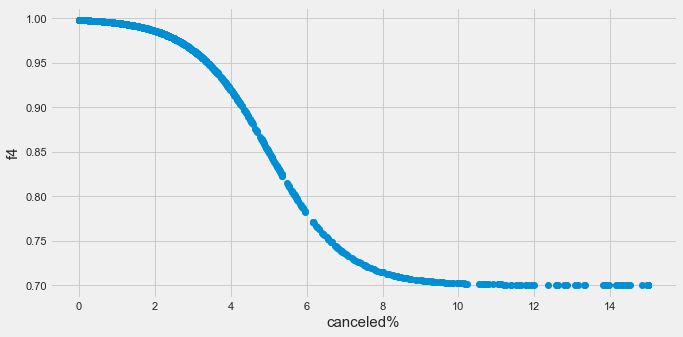

In [171]:
var='canceled%'
mid=5
c=1
max_f=0.7
cvm['f4']=cvm[var].apply(lambda x:f_score(x,mid,c,max_f))
plt.figure(figsize=(10,5))
plt.scatter(data=cvm,x=var,y='f4')
plt.xlabel(var,fontsize=15)
plt.ylabel('f4',fontsize=15)
plt.show()

In [172]:
cvm['CVM']=cvm['sum']*cvm['f1']*cvm['f2']*cvm['f3']*cvm['f4']
cvm.describe()

sum   num_visits    max_order  unique_prod    canceled%  \
count    5695.000000  5695.000000  5695.000000  5695.000000  5695.000000   
mean     1714.084334     3.141703   603.672014    65.755399     0.935067   
std      7339.028818     3.803356   726.152027    78.689289     2.744697   
min         0.420000     1.000000     0.420000     1.000000     0.000000   
25%       230.900000     1.000000   185.425000    13.000000     0.000000   
50%       601.560000     1.000000   358.380000    36.000000     0.000000   
75%      1543.195000     4.000000   679.375000    85.000000     0.000000   
max    278742.020000    20.000000  3500.000000   350.000000    15.000000   

                f1           f2           f3           f4            CVM  
count  5695.000000  5695.000000  5695.000000  5695.000000    5695.000000  
mean      1.027382     1.022213     1.036243     0.978733    2221.373002  
std       0.069647     0.033388     0.062624     0.065541   11707.803206  
min       1.001441     1.000671     1.001142     0.700014       0.420522  
25%       1.001441     1.001853     1.001839     0.997992     227.603373  
50%       1.001441     1.004702     1.004551     0.997992     600.444643  
75%       1.010334     1.022694     1.028370     0.997992    1745.138174  
max       1.299804     1.100000     1.199970     0.997992  477131.510538

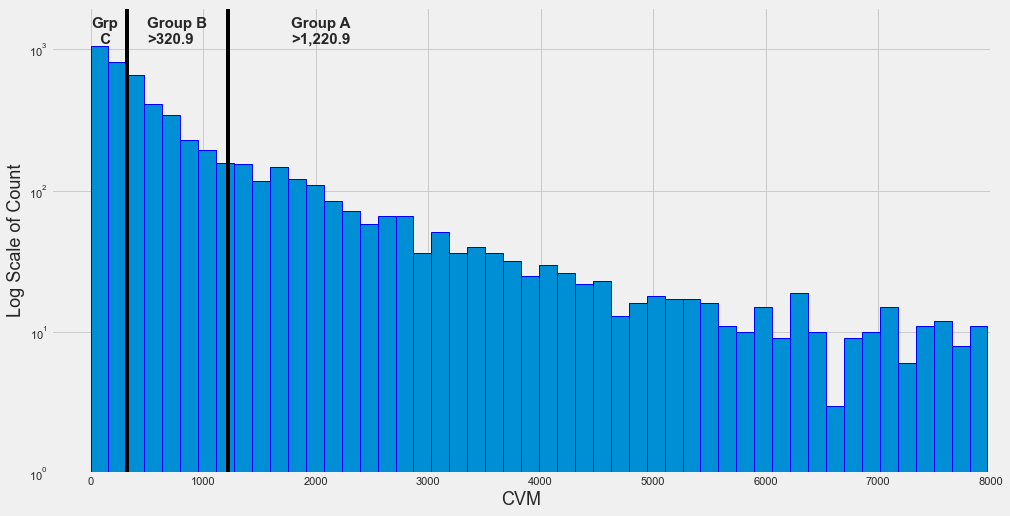

In [173]:
xhigh=8000
temp=cvm[cvm['CVM']<xhigh]['CVM']
plt.figure(figsize=(15,8))
plt.hist(temp,bins=50,edgecolor='blue')
plt.yscale('log')
plt.ylim(1,2000)
plt.xlim(-350,xhigh)
plt.axvline(cvm['CVM'].quantile(0.33),color='black',linewidth=4)
plt.axvline(cvm['CVM'].quantile(0.67),color='black',linewidth=4)
plt.annotate('Grp\n  C',(10, 1100),fontweight='bold',fontsize=15)
plt.annotate(f"Group B\n>{cvm['CVM'].quantile(0.33):.1f}",
             (500,1100),fontweight='bold',fontsize=15)
plt.annotate(f"Group A\n>{cvm['CVM'].quantile(0.67):,.1f}",
             (1780,1100),fontweight='bold',fontsize=15)
plt.xlabel('CVM',fontsize=18)
plt.ylabel('Log Scale of Count',fontsize=18)
plt.savefig('value_groups.png')
plt.show()

In [174]:
df_cleaned['InvoiceDateNew'] = df_cleaned['InvoiceDate'].dt.date

In [175]:
groupby=df_cleaned.groupby('CustomerID').count()['InvoiceNo']

In [176]:
df_cleaned['Adjusted_Quantity']=df_cleaned['Quantity']-df_cleaned['QuantityCanceled']
df_cleaned.sort_values('Adjusted_Quantity').head()

InvoiceNo StockCode                          Description  Quantity  \
180064    552299     22841         ROUND CAKE TIN VINTAGE GREEN         2   
100888    544885     37495       FAIRY CAKE BIRTHDAY CANDLE SET         4   
448049    575007     23118         PARISIENNE JEWELLERY DRAWER          2   
212038    555406     22166  WALL MIRROR RECTANGLE DIAMANTE PINK         1   
2083      536557     84685                BEACH HUT KEY CABINET         1   

               InvoiceDate  UnitPrice CustomerID         Country  \
180064 2011-05-08 14:44:00       7.95      15827  United Kingdom   
100888 2011-02-24 11:38:00       3.75      14243  United Kingdom   
448049 2011-11-08 11:20:00       7.50      14140  United Kingdom   
212038 2011-06-02 19:50:00       7.95      17231  United Kingdom   
2083   2010-12-01 14:41:00       3.75      17841  United Kingdom   

        OneTimePurchaser  QuantityCanceled  ...  TotalPrice  categ_product  \
180064             False                 2  ...         0.0              0   
100888             False                 4  ...         0.0              1   
448049             False                 2  ...         0.0              0   
212038             False                 1  ...         0.0              0   
2083               False                 1  ...         0.0              0   

        categ_0  categ_1  categ_2  categ_3  categ_4  CanceledValue  \
180064      0.0      0.0      0.0      0.0      0.0          15.90   
100888      0.0      0.0      0.0      0.0      0.0          15.00   
448049      0.0      0.0      0.0      0.0      0.0          15.00   
212038      0.0      0.0      0.0      0.0      0.0           7.95   
2083        0.0      0.0      0.0      0.0      0.0           3.75   

        InvoiceDateNew  Adjusted_Quantity  
180064      2011-05-08                  0  
100888      2011-02-24                  0  
448049      2011-11-08                  0  
212038      2011-06-02                  0  
2083        2010-12-01                  0  

[5 rows x 24 columns]

In [177]:
df_cleaned['Total']=df_cleaned['Adjusted_Quantity']*df_cleaned['UnitPrice']
Cancellation=df_cleaned[df_cleaned['InvoiceNo'].str.contains('C')].groupby('CustomerID').count()['InvoiceNo'].reset_index().rename(columns={'InvoiceNo':'Cancels'})
Cancellation.head()

Empty DataFrame
Columns: [CustomerID, Cancels]
Index: []

In [178]:
frequency=pd.DataFrame(df_cleaned.groupby('CustomerID').nunique()['InvoiceNo']).reset_index().rename(columns={'InvoiceNo':'Frequency'})
frequencyadj=pd.merge(frequency,Cancellation,how='left').fillna(0)
frequencyadj['Adjusted_Frequency']=frequencyadj['Frequency']-frequencyadj['Cancels']
frequencyadj['Adjusted_Frequency']=frequencyadj['Adjusted_Frequency'].replace(1,0)
frequencyadj.sort_values('Adjusted_Frequency')

CustomerID  Frequency  Cancels  Adjusted_Frequency
0         12346          1      0.0                 0.0
4362     537240          1      0.0                 0.0
4363     537252          1      0.0                 0.0
4364     537253          1      0.0                 0.0
4365     537411          1      0.0                 0.0
...         ...        ...      ...                 ...
2177      15311         91      0.0                91.0
562       13089         97      0.0                97.0
4008      17841        124      0.0               124.0
1880      14911        198      0.0               198.0
326       12748        206      0.0               206.0

[5884 rows x 4 columns]

Text(0.5, 1.0, 'Adjusted Frequency Histogram\nin Log Scale')

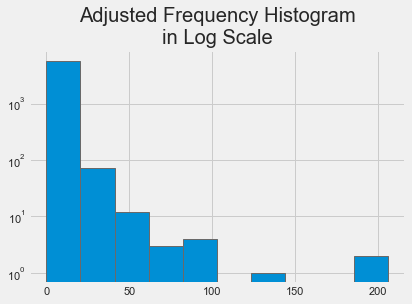

In [179]:
frequencyadj['Adjusted_Frequency'].hist()
plt.yscale('log')
plt.title('Adjusted Frequency Histogram\nin Log Scale')

In [180]:
frequencyadj.describe()

Frequency  Cancels  Adjusted_Frequency
count  5884.000000   5884.0         5884.000000
mean      3.391230      0.0            2.872026
std       6.708437      0.0            6.909146
min       1.000000      0.0            0.000000
25%       1.000000      0.0            0.000000
50%       1.000000      0.0            0.000000
75%       4.000000      0.0            4.000000
max     206.000000      0.0          206.000000

In [181]:
from datetime import datetime, timedelta
age=pd.DataFrame((max(df_cleaned['InvoiceDate'])+timedelta(1))-df_cleaned.groupby('CustomerID').min()['InvoiceDate']).reset_index().rename(columns={'InvoiceDate':'Customer_Age'})
age['Customer_Age']=pd.to_numeric(age['Customer_Age'].dt.days, downcast='integer')
age

CustomerID  Customer_Age
0         12346           326
1         12347           367
2         12348           358
3         12349            19
4         12350           310
...         ...           ...
5879     581435             1
5880     581439             1
5881     581492             1
5882     581497             1
5883     581498             1

[5884 rows x 2 columns]

In [182]:
recency=pd.DataFrame(df_cleaned['CustomerID'].unique()).rename(columns={0:'Customer_ID'})
recency

Customer_ID
0          17850
1          13047
2          12583
3          13748
4          15100
...          ...
5879      581439
5880      581492
5881      581497
5882      581498
5883       12713

[5884 rows x 1 columns]

In [183]:
%%time
# this cell is slow, about 5 minutes, depending on the machine
result={}
result
for n in recency['Customer_ID']:
    try:
        outcome=(df_cleaned[df_cleaned['CustomerID']==str(n)]['InvoiceDateNew'].unique()[-1]-df_cleaned[df_cleaned['CustomerID']==str(n)]['InvoiceDateNew'].unique()[-2]).days
        result[n]=outcome
    except:
        result[n]=0

CPU times: user 2min 29s, sys: 337 ms, total: 2min 29s
Wall time: 2min 29s


In [184]:
recency1 = pd.DataFrame(list(result.items()),columns = ['CustomerID','Recency']) 
recency1.describe()

Recency
count  5884.000000
mean     35.380014
std      63.624916
min       0.000000
25%       0.000000
50%       0.000000
75%      44.000000
max     366.000000

In [185]:
from datetime import datetime, timedelta
temp=pd.DataFrame((max(df_cleaned['InvoiceDate'])+timedelta(1))-df_cleaned.groupby('CustomerID').max()['InvoiceDate']).reset_index().rename(columns={'InvoiceDate':'Days_Since_Purchase'})
temp2=pd.DataFrame((max(df_cleaned['InvoiceDate'])+timedelta(1))-df_cleaned.groupby('CustomerID').min()['InvoiceDate']).reset_index().rename(columns={'InvoiceDate':'First_Purchase'})
recency=pd.merge(temp,temp2,how='left')
recency['Days_Since_Purchase'] = pd.to_numeric(recency['Days_Since_Purchase'].dt.days, downcast='integer')
recency['First_Purchase'] = pd.to_numeric(recency['First_Purchase'].dt.days, downcast='integer')
recency=pd.merge(recency1,recency,how='inner')

In [186]:
recency=pd.merge(recency1,recency[['CustomerID','First_Purchase']])

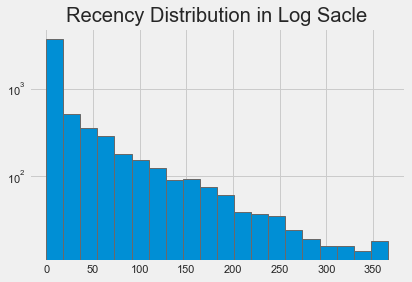

In [187]:
recency['Recency'].hist(bins=20)
plt.title('Recency Distribution in Log Sacle')
plt.yscale('log')

In [188]:
cancelation=df_cleaned[df_cleaned['InvoiceNo'].str.contains('C')].groupby('CustomerID').count()['InvoiceNo'].reset_index()

In [189]:
cancel_order=df_cleaned[df_cleaned['InvoiceNo'].str.contains('C')]['InvoiceNo']
non_cancel=df_cleaned[df_cleaned['InvoiceNo'].isin(cancel_order)==False]
canceled=df_cleaned[df_cleaned['InvoiceNo'].isin(cancel_order)==True]
non_cancel=non_cancel.groupby('CustomerID').sum()['Total'].reset_index().rename(columns={'Total':'Non_Cancel_Total'})
canceled=canceled.groupby('CustomerID').sum()['Total'].reset_index().rename(columns={'Total':'Cancel_Total'})
totaldf=pd.merge(non_cancel,canceled,how='left').fillna(0)
totaldf['Adjusted_Total']=totaldf['Non_Cancel_Total']-totaldf['Cancel_Total']
totaldf=totaldf[['CustomerID','Adjusted_Total']]
totaldf.describe()

Adjusted_Total
count     5884.000000
mean      1659.026220
std       7226.501763
min          0.000000
25%        204.000000
50%        569.420000
75%       1503.542500
max     278742.020000

Text(0.5, 1.0, 'Adjusted Total Amount Distribution')

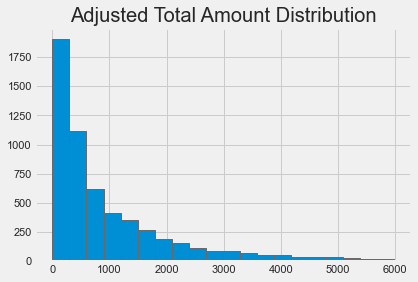

In [190]:
plt.hist(totaldf[totaldf['Adjusted_Total']<=6000]['Adjusted_Total'],bins=20)
plt.title('Adjusted Total Amount Distribution')

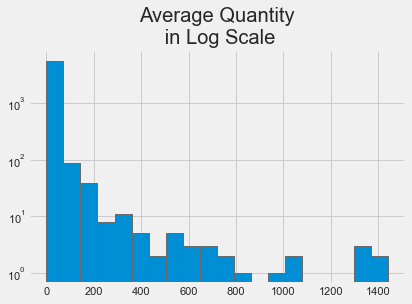

In [191]:
quantity=df_cleaned.groupby('CustomerID').mean()['Adjusted_Quantity'].reset_index().rename(columns={'Adjusted_Quantity':'Average_Quantity'})
quantity.describe()
quantity[quantity['Average_Quantity']<1500].hist('Average_Quantity',bins=20)
plt.title('Average Quantity\n in Log Scale')
plt.yscale("log")

Text(0.5, 1.0, 'Average Quantity Distribution')

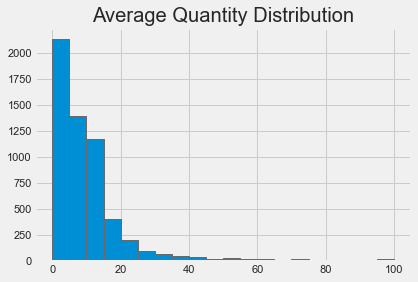

In [192]:
quantity[quantity['Average_Quantity']<=100].hist('Average_Quantity',bins=20)
plt.title('Average Quantity Distribution')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'F(Recency) Transition Graph\nMidpoint 125 Spread 25')

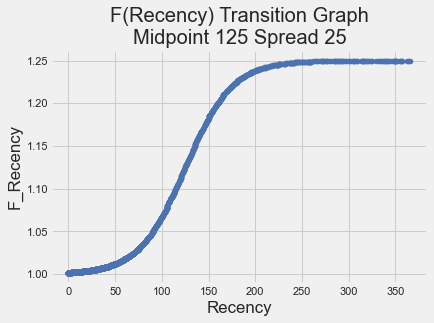

In [193]:
nmid_f1=125
c_f1=25
recency['F_Recency']=1+(1.25-1)/(1+np.exp(-(recency['Recency']-nmid_f1)/c_f1))
recency[recency['Recency']<=500].plot.scatter('Recency','F_Recency')
plt.title('F(Recency) Transition Graph\nMidpoint 125 Spread 25')

In [194]:
frequency=df_cleaned.groupby('CustomerID').nunique('InvoiceNo')['InvoiceNo'].reset_index().rename(columns={'InvoiceNo':'Frequency'})
frequency['Frequency']=frequency['Frequency']-1
frequency
recency=recency[['CustomerID','Recency','F_Recency']]
recency.max()

CustomerID      581498
Recency            366
F_Recency     1.249984
dtype: object

In [195]:
frequency.describe()

Frequency
count  5884.000000
mean      2.391230
std       6.708437
min       0.000000
25%       0.000000
50%       0.000000
75%       3.000000
max     205.000000

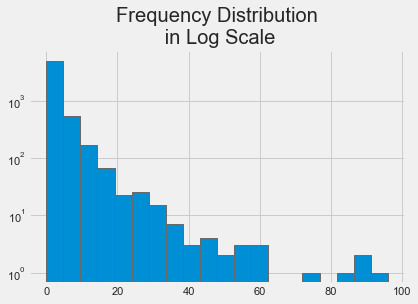

In [196]:
frequency[frequency['Frequency']<=100].hist(bins=20)
plt.title('Frequency Distribution\n in Log Scale')
plt.yscale('log')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'F(Frequency) Transition Graph\nMidpoint 20 Spread 5')

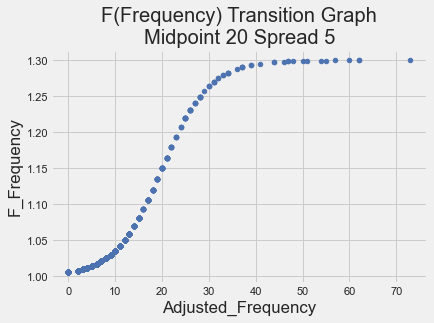

In [197]:
nmid_f1=20
c_f1=5
frequencyadj['F_Frequency']=1+(1.3-1)/(1+np.exp(-(frequencyadj['Adjusted_Frequency']-nmid_f1)/c_f1))
frequencyadj[frequencyadj['Adjusted_Frequency']<=80].plot.scatter('Adjusted_Frequency','F_Frequency')
plt.title('F(Frequency) Transition Graph\nMidpoint 20 Spread 5')

In [198]:
data=pd.merge(frequency[['CustomerID','Frequency']],recency)
data=pd.DataFrame(data)
data=pd.merge(data,totaldf,how='inner')
data=pd.merge(data,frequencyadj[['CustomerID','Adjusted_Frequency','F_Frequency']],how='inner')
data

CustomerID  Frequency  Recency  F_Recency  Adjusted_Total  \
0         12346          0        0   1.001673            0.00   
1         12347          6       37   1.007187         4310.00   
2         12348          3      173   1.218035         1437.24   
3         12349          0        0   1.001673         1457.55   
4         12350          0        0   1.001673          294.40   
...         ...        ...      ...        ...             ...   
5879     581435          0        0   1.001673            3.35   
5880     581439          0        0   1.001673         5699.00   
5881     581492          0        0   1.001673         6756.06   
5882     581497          0        0   1.001673         3217.20   
5883     581498          0        0   1.001673         3950.72   

      Adjusted_Frequency  F_Frequency  
0                    0.0     1.005396  
1                    7.0     1.020742  
2                    4.0     1.011750  
3                    0.0     1.005396  
4                    0.0     1.005396  
...                  ...          ...  
5879                 0.0     1.005396  
5880                 0.0     1.005396  
5881                 0.0     1.005396  
5882                 0.0     1.005396  
5883                 0.0     1.005396  

[5884 rows x 7 columns]

count    5884.000000
mean        2.391230
std         6.708437
min         0.000000
25%         0.000000
50%         0.000000
75%         3.000000
max       205.000000
Name: Frequency, dtype: float64
0.5192046227056424


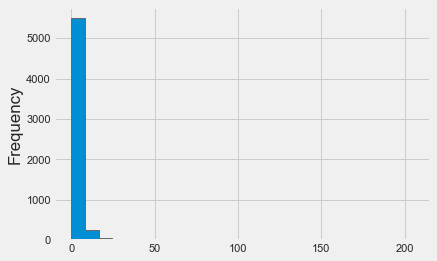

In [199]:
data['Frequency'].plot(kind='hist', bins=25)
print(data['Frequency'].describe())
print(sum(data['Frequency'] == 0)/float(len(data)))

In [200]:
data=pd.merge(data,age,how='inner')
data['F_Frequency'].max()

1.3

In [201]:
frequencyadj=frequencyadj[['CustomerID','Adjusted_Frequency']]
frequencyadj['Adjusted_Frequency']=frequencyadj['Adjusted_Frequency'].replace(1,0)

In [202]:
data=pd.merge(data,quantity,how='inner')

In [203]:
data['CVM'] = cvm['CVM']
data.head(10)

CustomerID  Frequency  Recency  F_Recency  Adjusted_Total  \
0      12346          0        0   1.001673            0.00   
1      12347          6       37   1.007187         4310.00   
2      12348          3      173   1.218035         1437.24   
3      12349          0        0   1.001673         1457.55   
4      12350          0        0   1.001673          294.40   
5      12352          6       36   1.006913         1265.41   
6      12353          0        0   1.001673           89.00   
7      12354          0        0   1.001673         1079.40   
8      12355          0        0   1.001673          459.40   
9      12356          2      223   1.245136         2487.43   

   Adjusted_Frequency  F_Frequency  Customer_Age  Average_Quantity  \
0                 0.0     1.005396           326          0.000000   
1                 7.0     1.020742           367         13.505495   
2                 4.0     1.011750           358         86.370370   
3                 0.0     1.005396            19          8.750000   
4                 0.0     1.005396           310         12.250000   
5                 7.0     1.020742           297          6.012987   
6                 0.0     1.005396           204          5.000000   
7                 0.0     1.005396           232          9.137931   
8                 0.0     1.005396           214         18.461538   
9                 3.0     1.009689           326         27.120690   

           CVM  
0  5234.186886  
1  1482.192229  
2  1624.661423  
3   295.827190  
4   934.326163  
5    89.161074  
6  1169.885596  
7   463.644207  
8  2767.889478  
9  7520.651265

In [204]:
data['CVM_Group']=np.nan
for n in range(0,len(data)):
    if data['CVM'][n]<=data['CVM'].quantile(0.33):
        data['CVM_Group'][n]=1
    elif data['CVM'][n]<=data['CVM'].quantile(0.67):
        data['CVM_Group'][n]=2
    else:
        data['CVM_Group'][n]=3

<AxesSubplot:xlabel='CVM_Group'>

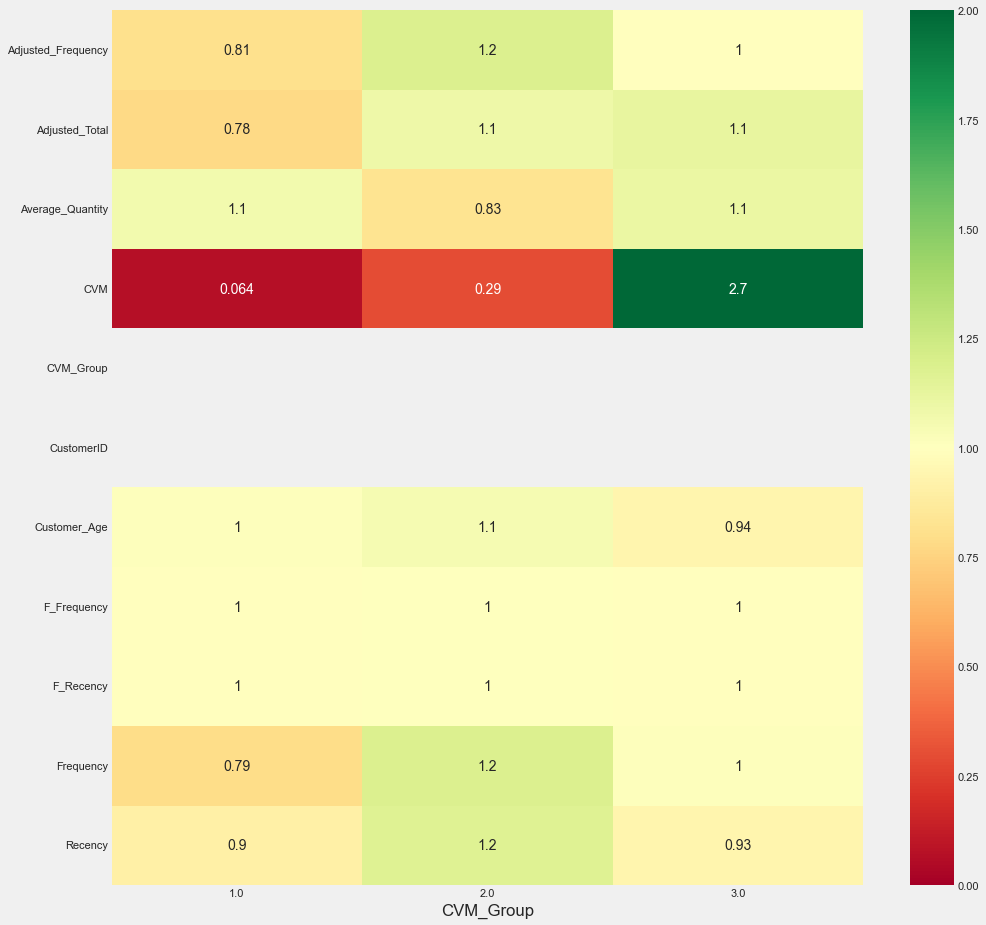

In [205]:
field_means = data.mean()
Knn_table = data.groupby('CVM_Group').mean()
Knn_norm_table = Knn_table / field_means
Knn_norm_table_transpose = Knn_norm_table.transpose()
plt.figure(figsize=(15,15))
sns.heatmap(Knn_norm_table_transpose, cmap='RdYlGn', annot=True, vmin=0, vmax=2)

In [206]:
len(data[data['Recency']==0])/len(data)

0.5282121006118287

In [207]:
for n in range(0,len(data)):
    if data['Adjusted_Frequency'][n]==0:
        data['Recency'][n]=0

In [208]:
from lifetimes import BetaGeoFitter
from scipy.special import logsumexp
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['Adjusted_Frequency'], data['Recency'], data['Customer_Age'],)
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 5884 subjects, a: 10.70, alpha: 0.25, b: 64.91, r: 0.10>


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

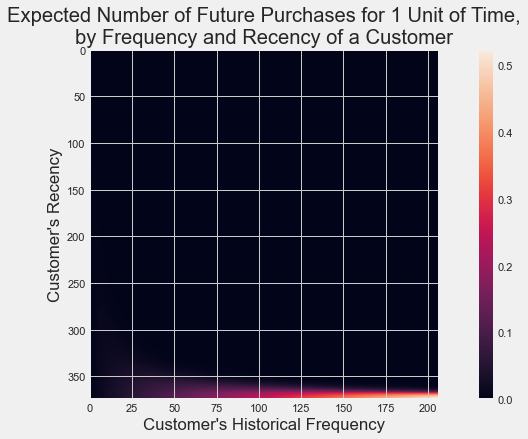

In [209]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

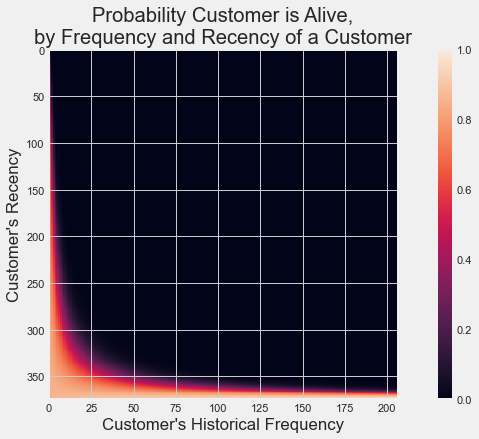

In [210]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,6))
plot_probability_alive_matrix(bgf)

In [211]:
from lifetimes.plotting import *
from lifetimes.utils import *
# from lifetimes.estimation import *

In [212]:
cancel_order=df_cleaned[df_cleaned['InvoiceNo'].str.contains('C')]
non_cancel=df_cleaned[df_cleaned['InvoiceNo'].isin(cancel_order)==False]
temp=non_cancel.groupby('CustomerID').count()['InvoiceNo'].reset_index()
temp['One_Timer']=np.nan
for n in range(0,len(temp)):
    if temp['InvoiceNo'][n]==1:
        temp['One_Timer'][n]='One_Time'
    else:
        temp['One_Timer'][n]='Repeat'
temp=temp[['CustomerID','One_Timer']]
data=pd.merge(data,temp,how='inner')

Text(0.5, 1.0, 'One Time Purchaser v.s. Repeat Customers\nTotal Amount Comparison')

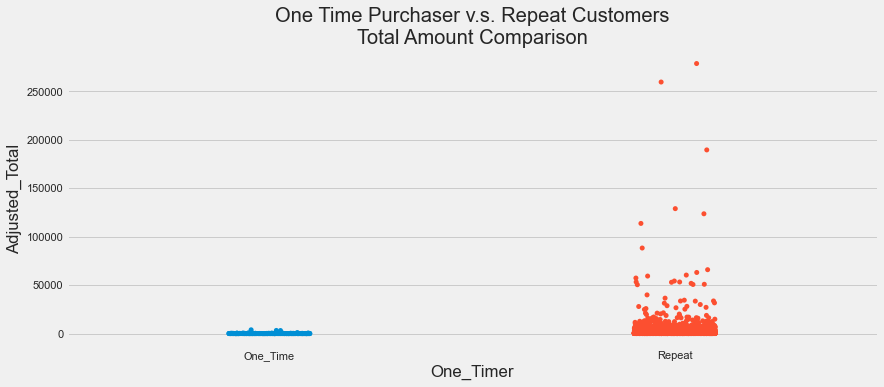

In [213]:
a=sns.catplot(x="One_Timer", y="Adjusted_Total", data=data)
a.fig.set_figwidth(15)
a.fig.set_figheight(5)
plt.title('One Time Purchaser v.s. Repeat Customers\nTotal Amount Comparison')

In [214]:
df_new=pd.merge(df_cleaned,temp,how='left')
df_new['Weekday']=df_new['InvoiceDate'].dt.day_name()
weekday=df_new.groupby(['CustomerID','Weekday']).sum().reset_index()

Text(0.5, 1.0, 'One Time Customer v.s. Repeat Customer\nComparison (without Returns)')

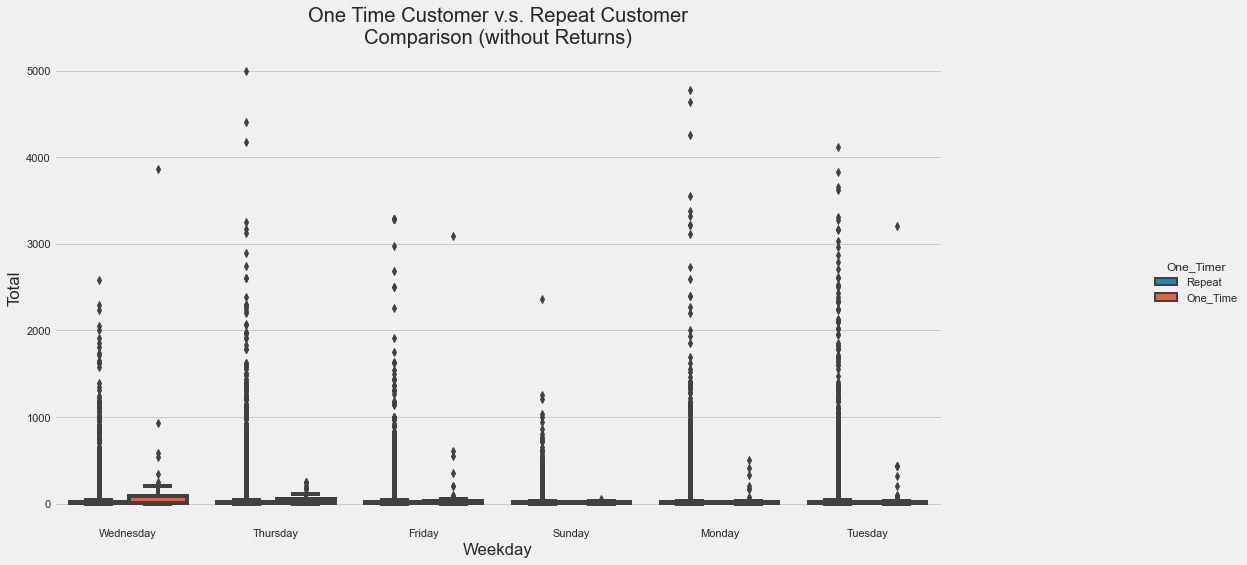

In [215]:
df_new=df_new[df_new['Total']>0]
df_new=df_new[df_new['Total']<=6000]
g=sns.catplot(x="Weekday", y="Total", hue="One_Timer", kind="box", data=df_new)

g.fig.set_figwidth(20)
g.fig.set_figheight(8)
plt.title('One Time Customer v.s. Repeat Customer\nComparison (without Returns)')

In [216]:
citizen=df_cleaned[['CustomerID','Country']].drop_duplicates()
data_citizen=pd.merge(citizen,data,how='right')

In [217]:
top10=pd.DataFrame(df_new.groupby('Country').count()['InvoiceNo'].reset_index().sort_values('InvoiceNo',ascending=False)[:6]['Country'])
df_top10=pd.merge(data_citizen,top10,how='inner')

Text(0.5, 1.0, 'Customer Value Distribution Among Top 6 Countries\nwith Most Orders Placed')

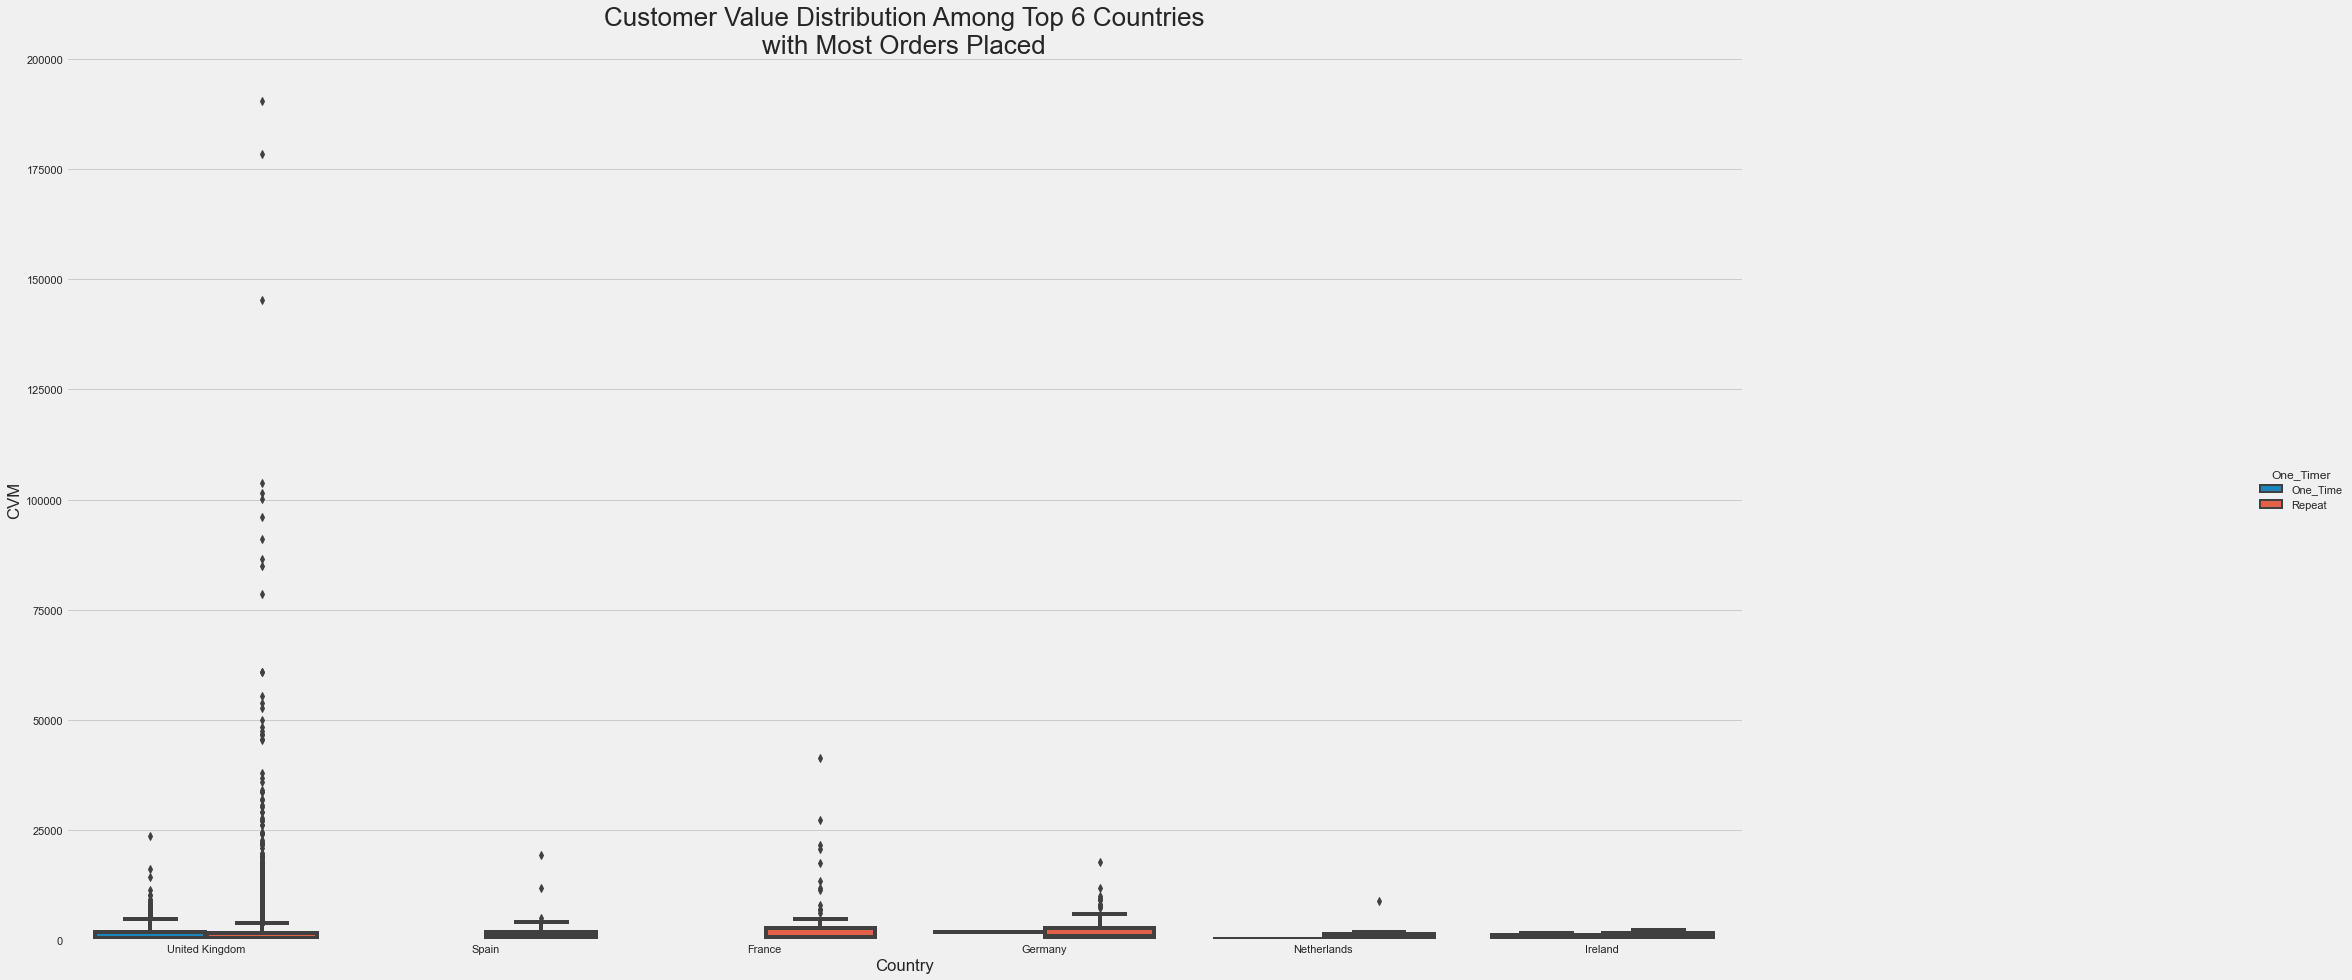

In [218]:
g = sns.catplot(data=df_top10, x='Country', kind="box",
                y='CVM', hue='One_Timer')
g.fig.set_figwidth(40)
g.fig.set_figheight(15)
plt.ylim(0,200000)
plt.title('Customer Value Distribution Among Top 6 Countries\nwith Most Orders Placed',fontsize=26)

In [219]:
df_cleaned[df_cleaned['Country']=='EIRE'].groupby('CustomerID').count()

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, Country, OneTimePurchaser, QuantityCanceled, Month, Weekday, Day, Hour, TotalPrice, categ_product, categ_0, categ_1, categ_2, categ_3, categ_4, CanceledValue, InvoiceDateNew, Adjusted_Quantity, Total]
Index: []

[0 rows x 24 columns]

In [220]:
top10=pd.DataFrame(df_new.groupby('Country').nunique()['CustomerID'].reset_index().sort_values('CustomerID',ascending=False)[:6]['Country'])
df_top10=pd.merge(data_citizen,top10,how='inner')

Text(0.5, 1.0, 'Customer Value Distribution Among Top 6 Countries\nwith Most Customers Capped at $20,000 CVM')

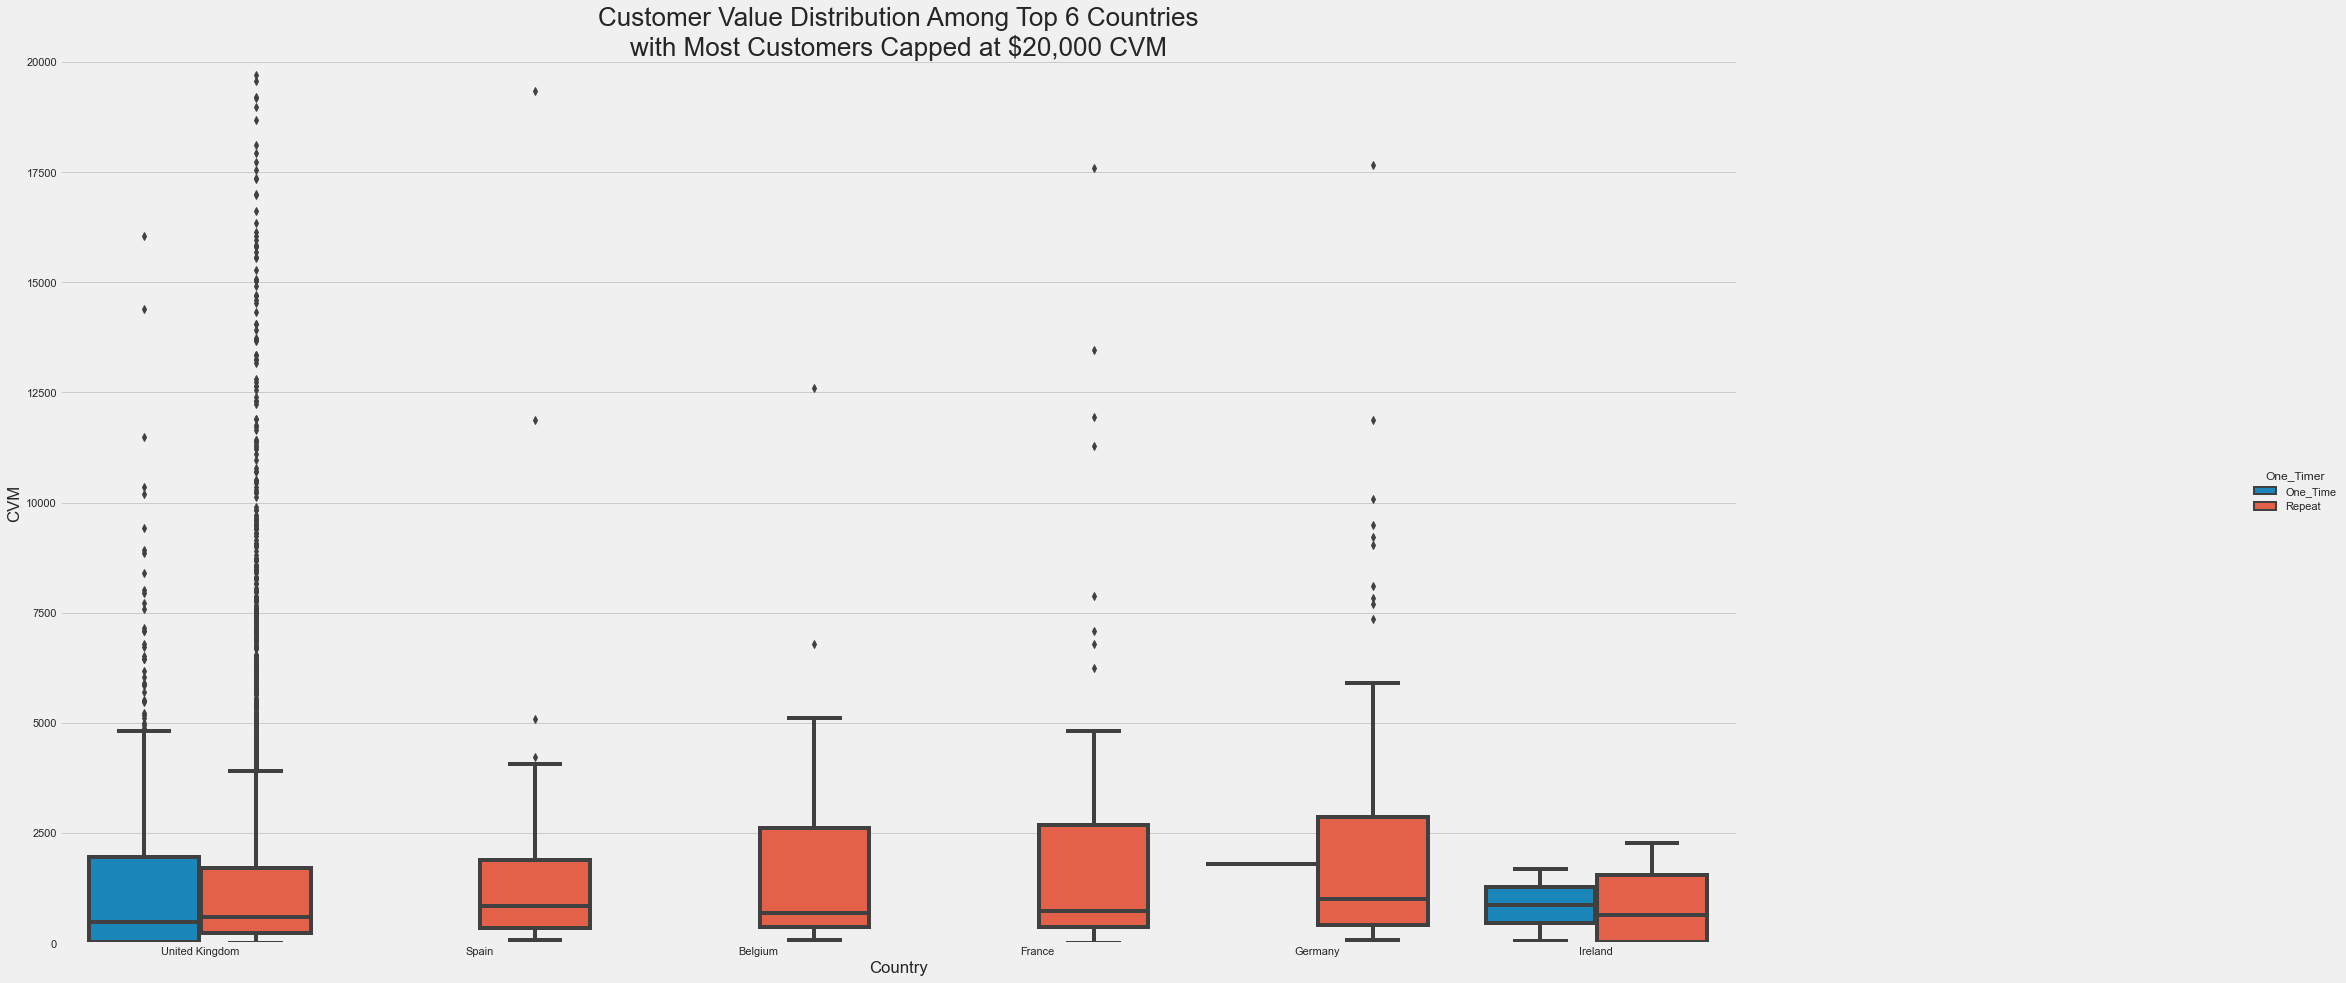

In [221]:
g = sns.catplot(data=df_top10, x='Country', kind="box",
                y='CVM', hue='One_Timer')
plt.ylim(0,20000)
g.fig.set_figwidth(40)
g.fig.set_figheight(15)
plt.title('Customer Value Distribution Among Top 6 Countries\nwith Most Customers Capped at $20,000 CVM',fontsize=26)

In [222]:
data.groupby(['CVM_Group','One_Timer']).mean()['Adjusted_Total']

CVM_Group  One_Timer
1.0        One_Time       33.976937
           Repeat       1408.615337
2.0        One_Time      119.650968
           Repeat       1862.068938
3.0        One_Time       58.034100
           Repeat       2047.498818
Name: Adjusted_Total, dtype: float64

Text(0.5, 1.0, 'Customer Value Measure by 33% Percentile')

<Figure size 720x360 with 0 Axes>

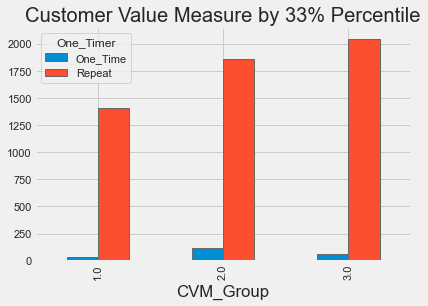

In [223]:
plt.figure(figsize=(10,5))
p=data.groupby(['CVM_Group','One_Timer']).mean()['Adjusted_Total'].unstack().plot(kind='bar')
plt.title('Customer Value Measure by 33% Percentile')

In [224]:
df_new.groupby(['Weekday','One_Timer']).sum()['Total']

Weekday    One_Timer
Friday     One_Time        5922.23
           Repeat       1518295.80
Monday     One_Time        2232.79
           Repeat       1646793.13
Sunday     One_Time         141.70
           Repeat        785941.30
Thursday   One_Time        2141.70
           Repeat       2077313.61
Tuesday    One_Time        5810.42
           Repeat       1946318.45
Wednesday  One_Time        8212.65
           Repeat       1748902.38
Name: Total, dtype: float64

## 6. Examine Item Co-occurence and Make Recommendation
inspired by https://pbpython.com/market-basket-analysis.html#:~:text=Association%20rules%20are%20normally%20written,%7BBeer%7D%20is%20the%20consequent.

The goal of constructing an association rules framework is to find interesting sales relations between various items within the transaction dataset. Ultimately, it will help us discover items people will most likely to buy given the goods in the previous purchase. Consider a scenario where the transaction data is organized into a large matrix which contains the transaction IDs and the names of purchased item. In each entry a value of 1 is assigned if the item is present in the corresponding transaction, 0 if otherwise. For example, if an association rule is defined as {Lamps, Bedside Tables} => {Beds}, indicating that if lamps and bedside tables are purchased, customers will also buy beds.

### Association Rules Metrics
Support: indicates how frequently an antecedent X (i.e.,{Lamps & Bedside Tables}) has appeared in the whole dataset. 

Confidence: indicates how often the rule turns out to be true, in our case, what proportion of the antecedent X {Lamps & Bedside Tables} has resulted in the purchase of Y (Beds). 

Lift: denotes the ratio of: observed Support/expected Support if X and Y are independent. If Lift = 1, this would mean that no rule can be applied since the occurrences of the two events are independent. If Lift > 1, it implies the degree to which the Y is dependent on X. If Lift < 1, then it means X and Y are substitute to each other (i.e., the presence of one itemset negatively impacts the presence of the other)

Conviction: can be interpreted as the ratio of the expected frequency that X occurs without Y (i.e, the frequency that the rule makes an incorrect prediction) if X and Y were independent divided by the observed frequency of incorrect predictions.

### A simple implementation on the dataset

In [225]:
ar_df = (df_cleaned.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))

def encoding(x):
    if x <= 0:return 0      
    if x >= 1:return 1
        
itemsets = ar_df.applymap(encoding)
frequent_sets = apriori(itemsets, min_support=0.025, use_colnames=True)
assoc_rules = association_rules(frequent_sets, min_threshold=0.4)

In [226]:
frequent_sets

support                                           itemsets
0    0.047860                           (6 RIBBONS RUSTIC CHARM)
1    0.030971                  (60 CAKE CASES VINTAGE CHRISTMAS)
2    0.041495                      (60 TEATIME FAIRY CAKE CASES)
3    0.030821                   (72 SWEETHEART FAIRY CAKE CASES)
4    0.049113                       (ALARM CLOCK BAKELIKE GREEN)
..        ...                                                ...
217  0.030019  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...
218  0.025358  (RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOT...
219  0.026311  (ROSES REGENCY TEACUP AND SAUCER , REGENCY CAK...
220  0.027012  (WOODEN FRAME ANTIQUE WHITE , WOODEN PICTURE F...
221  0.027162  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...

[222 rows x 2 columns]

In [227]:
#the following item antecedent and consequents pairs ordered by confidence
#can be of help to formulate sales strategies such as item bundling
assoc_rules

antecedents  \
0                        (ALARM CLOCK BAKELIKE GREEN)   
1                         (ALARM CLOCK BAKELIKE RED )   
2                       (CHARLOTTE BAG PINK POLKADOT)   
3                       (RED RETROSPOT CHARLOTTE BAG)   
4                       (RED RETROSPOT CHARLOTTE BAG)   
5                         (CHARLOTTE BAG SUKI DESIGN)   
6                              (DOLLY GIRL LUNCH BOX)   
7                               (SPACEBOY LUNCH BOX )   
8                 (GARDENERS KNEELING PAD KEEP CALM )   
9                (GARDENERS KNEELING PAD CUP OF TEA )   
10                   (PINK REGENCY TEACUP AND SAUCER)   
11                  (GREEN REGENCY TEACUP AND SAUCER)   
12                  (GREEN REGENCY TEACUP AND SAUCER)   
13                 (ROSES REGENCY TEACUP AND SAUCER )   
14                  (GREEN REGENCY TEACUP AND SAUCER)   
15                   (JUMBO  BAG BAROQUE BLACK WHITE)   
16                                 (JUMBO BAG APPLES)   
17                          (JUMBO BAG PINK POLKADOT)   
18                          (JUMBO BAG PINK POLKADOT)   
19                           (JUMBO STORAGE BAG SUKI)   
20                   (JUMBO BAG PINK VINTAGE PAISLEY)   
21                             (JUMBO BAG STRAWBERRY)   
22                       (JUMBO BAG WOODLAND ANIMALS)   
23                (JUMBO SHOPPER VINTAGE RED PAISLEY)   
24                           (JUMBO STORAGE BAG SUKI)   
25                (JUMBO SHOPPER VINTAGE RED PAISLEY)   
26                           (JUMBO STORAGE BAG SUKI)   
27                          (LUNCH BAG  BLACK SKULL.)   
28                              (LUNCH BAG CARS BLUE)   
29                          (LUNCH BAG PINK POLKADOT)   
30                          (LUNCH BAG  BLACK SKULL.)   
31                          (LUNCH BAG  BLACK SKULL.)   
32                          (LUNCH BAG RED RETROSPOT)   
33                       (LUNCH BAG SPACEBOY DESIGN )   
34                          (LUNCH BAG  BLACK SKULL.)   
35                          (LUNCH BAG  BLACK SKULL.)   
36                           (LUNCH BAG SUKI DESIGN )   
37                          (LUNCH BAG PINK POLKADOT)   
38                              (LUNCH BAG CARS BLUE)   
39                              (LUNCH BAG CARS BLUE)   
40                          (LUNCH BAG PINK POLKADOT)   
41                       (LUNCH BAG SPACEBOY DESIGN )   
42                           (LUNCH BAG SUKI DESIGN )   
43                               (LUNCH BAG WOODLAND)   
44                (PAPER CHAIN KIT VINTAGE CHRISTMAS)   
45                  (PAPER CHAIN KIT 50'S CHRISTMAS )   
46                 (ROSES REGENCY TEACUP AND SAUCER )   
47                   (PINK REGENCY TEACUP AND SAUCER)   
48                      (RED RETROSPOT CHARLOTTE BAG)   
49                           (WOODLAND CHARLOTTE BAG)   
50                 (ROSES REGENCY TEACUP AND SAUCER )   
51                      (WOODEN FRAME ANTIQUE WHITE )   
52                (WOODEN PICTURE FRAME WHITE FINISH)   
53  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...   
54  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
55  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
56                 (ROSES REGENCY TEACUP AND SAUCER )   
57                   (PINK REGENCY TEACUP AND SAUCER)   
58                  (GREEN REGENCY TEACUP AND SAUCER)   

                                          consequents  antecedent support  \
0                         (ALARM CLOCK BAKELIKE RED )            0.049113   
1                        (ALARM CLOCK BAKELIKE GREEN)            0.052671   
2                       (RED RETROSPOT CHARLOTTE BAG)            0.037236   
3                       (CHARLOTTE BAG PINK POLKADOT)            0.051819   
4                         (CHARLOTTE BAG SUKI DESIGN)            0.051819   
5                       (RED RETROSPOT CHARLOTTE BAG)            0.044202   
6                               (SPACEBOY LUNCH BOX )            0.042598   
7    

### Building Recommender System Using Scikit-Surprise

In this section, we use the lifetime quantity a customer buys an item as the metric to build a recommender system that gives recommendation based on the items a customer buys. Specifically we use the scikit-surprise package for this task. More info on the package can be found at http://surpriselib.com/

In [228]:
from surprise import SVD,accuracy, Dataset, Reader
from surprise.model_selection import cross_validate,train_test_split

In [229]:
rs_df = pd.DataFrame(df_cleaned.groupby(['CustomerID','StockCode'])['Quantity'].sum()).reset_index()
rs_df

CustomerID StockCode  Quantity
0           12346     23166     74215
1           12347     16008        24
2           12347     17021        36
3           12347     20665         6
4           12347     20719        40
...           ...       ...       ...
397668     581498    85049e         4
397669     581498    85099B         5
397670     581498    85099C         4
397671     581498     85150         1
397672     581498     85174         1

[397673 rows x 3 columns]

In [230]:
reader = Reader()
rs_df_matrix = Dataset.load_from_df(rs_df[['CustomerID', 'StockCode', 'Quantity']], reader)

In [231]:
trainset, testset = train_test_split(rs_df_matrix, test_size=0.25)

In [232]:
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

In [233]:
accuracy.rmse(predictions)

RMSE: 274.6125


274.6124914838779

In [234]:
#let's take a close look at how this can make recommendations for a specific customer
#for the sake of illustration, we will use customer id 13268
iids = rs_df['StockCode'].unique()
iids13268 = rs_df.loc[rs_df.CustomerID=='13268','StockCode']
#remove the items that 13268 has already purchased
iids_to_pred = np.setdiff1d(iids, iids13268)
test_df = [['13268',iid, 5] for iid in iids_to_pred] #
predictions = algo.test(testset)
predictions[0]

Prediction(uid='15570', iid='22483', r_ui=7.0, est=5, details={'was_impossible': False})

In [235]:
pred_ratings = np.array([pred.est for pred in predictions])
#find the index of the max predicted rating
i_max = pred_ratings.argmax()
#use this to find the corresponding iid
iid = iids_to_pred[i_max]
print("Top item for customer 13268 has stockcode {0}, with predicted rating {1}".format(iid, pred_ratings[i_max]))

Top item for customer 13268 has stockcode 10002, with predicted rating 5


# Itemsets Analysis and Customer Buying Habits

### Association Rules Mining
This data mining method will find the top co-occurance items and find provide metrics on how strong the found pairs are based on a measure. For example how confident are you, based on the dataset that if a customer buys beer he/she will also buy diapers?

In [236]:
invoices = (df_cleaned.groupby(['InvoiceNo', 'Description'])['Quantity']
                      .sum().unstack().reset_index().fillna(0)
                      .set_index('InvoiceNo'))

#### Formulas for metrics
- support(A->C) = support(A+C) [aka 'support'], range: [0, 1]

- confidence(A->C) = support(A+C) / support(A), range: [0, 1]

- lift(A->C) = confidence(A->C) / support(C), range: [0, inf]

- leverage(A->C) = support(A->C) - support(A)*support(C),
range: [-1, 1]

- conviction = [1 - support(C)] / [1 - confidence(A->C)],
range: [0, inf]

In [237]:
print('time to here: ', datetime.now() - start_time)

time to here:  0:04:34.626185


In [238]:
%%time
# this cell might take about 9 minutes, dependine on the machine memory
basket_sets = invoices.applymap(lambda x: 1 if x >= 1 else 0)
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)

CPU times: user 14 s, sys: 2.09 s, total: 16.1 s
Wall time: 17 s


In [239]:
# below is a list of all frequent itemsets bought by customers
frequent_itemsets

support                                           itemsets
0    0.023454                         (3 STRIPEY MICE FELTCRAFT)
1    0.024256                      (4 TRADITIONAL SPINNING TOPS)
2    0.047860                           (6 RIBBONS RUSTIC CHARM)
3    0.021900                  (60 CAKE CASES DOLLY GIRL DESIGN)
4    0.030971                  (60 CAKE CASES VINTAGE CHRISTMAS)
..        ...                                                ...
370  0.020447  (WHITE HANGING HEART T-LIGHT HOLDER, WOODEN PI...
371  0.027012  (WOODEN FRAME ANTIQUE WHITE , WOODEN PICTURE F...
372  0.027162  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...
373  0.020447  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...
374  0.020698  (JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SU...

[375 rows x 2 columns]

In [240]:
# below is a list of all frequent itemsets that are a combination of 2 or more items
# bought by customers
frequent_itemsets[frequent_itemsets.itemsets.apply(len) > 1]

support                                           itemsets
294  0.022702  (60 TEATIME FAIRY CAKE CASES, PACK OF 72 RETRO...
295  0.020948  (ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL...
296  0.032074  (ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL...
297  0.023554  (ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...
298  0.020547  (CHARLOTTE BAG PINK POLKADOT, CHARLOTTE BAG SU...
..        ...                                                ...
370  0.020447  (WHITE HANGING HEART T-LIGHT HOLDER, WOODEN PI...
371  0.027012  (WOODEN FRAME ANTIQUE WHITE , WOODEN PICTURE F...
372  0.027162  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...
373  0.020447  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...
374  0.020698  (JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SU...

[81 rows x 2 columns]

a list of item antecedent and consequents paired rank ordered by confidence store might employ strategies for either bundle these items, or make the pair  of items physically far away from each other instore so customers looking for the second item (to complete the set) needs to walk across the whole store therefore more chances to "accidentally" find new items to buy.

In [241]:
rules = association_rules(frequent_itemsets, min_threshold=0.5)
rules

antecedents  \
0                       (60 TEATIME FAIRY CAKE CASES)   
1                         (ALARM CLOCK BAKELIKE PINK)   
2                        (ALARM CLOCK BAKELIKE GREEN)   
3                         (ALARM CLOCK BAKELIKE RED )   
4                         (ALARM CLOCK BAKELIKE PINK)   
5                       (CHARLOTTE BAG PINK POLKADOT)   
6                       (CHARLOTTE BAG PINK POLKADOT)   
7                       (RED RETROSPOT CHARLOTTE BAG)   
8                         (CHARLOTTE BAG SUKI DESIGN)   
9                          (STRAWBERRY CHARLOTTE BAG)   
10                           (WOODLAND CHARLOTTE BAG)   
11                        (CHARLOTTE BAG SUKI DESIGN)   
12                             (DOLLY GIRL LUNCH BOX)   
13                              (SPACEBOY LUNCH BOX )   
14                (GARDENERS KNEELING PAD KEEP CALM )   
15               (GARDENERS KNEELING PAD CUP OF TEA )   
16                   (PINK REGENCY TEACUP AND SAUCER)   
17                  (GREEN REGENCY TEACUP AND SAUCER)   
18                  (GREEN REGENCY TEACUP AND SAUCER)   
19                 (ROSES REGENCY TEACUP AND SAUCER )   
20                  (GREEN REGENCY TEACUP AND SAUCER)   
21                            (HEART OF WICKER LARGE)   
22                   (JUMBO  BAG BAROQUE BLACK WHITE)   
23                                  (JUMBO BAG PEARS)   
24                                 (JUMBO BAG APPLES)   
25                          (JUMBO BAG PINK POLKADOT)   
26                   (JUMBO BAG PINK VINTAGE PAISLEY)   
27              (JUMBO BAG SCANDINAVIAN BLUE PAISLEY)   
28                        (JUMBO BAG SPACEBOY DESIGN)   
29                             (JUMBO BAG STRAWBERRY)   
30                       (JUMBO BAG WOODLAND ANIMALS)   
31                (JUMBO SHOPPER VINTAGE RED PAISLEY)   
32                         (JUMBO STORAGE BAG SKULLS)   
33                           (JUMBO STORAGE BAG SUKI)   
34                         (RECYCLING BAG RETROSPOT )   
35                       (JUMBO BAG WOODLAND ANIMALS)   
36                          (LUNCH BAG  BLACK SKULL.)   
37                          (LUNCH BAG PINK POLKADOT)   
38                           (LUNCH BAG SUKI DESIGN )   
39                               (LUNCH BAG WOODLAND)   
40                (PAPER CHAIN KIT VINTAGE CHRISTMAS)   
41                 (ROSES REGENCY TEACUP AND SAUCER )   
42                   (PINK REGENCY TEACUP AND SAUCER)   
43                 (RED HANGING HEART T-LIGHT HOLDER)   
44                         (STRAWBERRY CHARLOTTE BAG)   
45                           (WOODLAND CHARLOTTE BAG)   
46                         (STRAWBERRY CHARLOTTE BAG)   
47                      (WOODEN FRAME ANTIQUE WHITE )   
48  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...   
49  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
50  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
51                 (ROSES REGENCY TEACUP AND SAUCER )   
52                   (PINK REGENCY TEACUP AND SAUCER)   
53                  (GREEN REGENCY TEACUP AND SAUCER)   
54  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
55  (ROSES REGENCY TEACUP AND SAUCER , REGENCY CAK...   
56  (GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...   
57  (JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SUKI)   
58  (JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS...   
59  (JUMBO STORAGE BAG SUKI, JUMBO BAG RED RETROSPOT)   

                                          consequents  antecedent support  \
0                   (PACK OF 72 RETROSPOT CAKE CASES)            0.041495   
1                        (ALARM CLOCK BAKELIKE GREEN)            0.039240   
2                         (ALARM CLOCK BAKELIKE RED )            0.049113   
3                        (ALARM CLOCK BAKELIKE GREEN)            0.052671   
4                         (ALARM CLOCK BAKELIKE RED )            0.039240   
5                         (CHARLOTTE BAG SUKI DESIGN)            0.037236   
6                       (

### Explicit recommender systems
Using the quantity customers buy as an explicit measure of "rating", this factorization model will recommend items based on given customerID.

This recommendation model can help pinpoint specific items to recommend to specific customer.

In [242]:
items = df_cleaned['StockCode'].unique()
items2idx = dict(zip(items, range(len(items))))
idx2item = dict(zip(range(len(items)), items))

In [243]:
# # I couldn't get spotlight to run so I commented out the next 6 cells
# interactions = spotlight.Interactions(df_cleaned.CustomerID.values.astype(int),
#                             df_cleaned.StockCode.map(items2idx).values.astype(int),
#                             df_cleaned.Quantity.values.astype(float))

In [244]:
# model = ExplicitFactorizationModel(loss='regression',
#                                    embedding_dim=128,  # latent dimensionality
#                                    n_iter=10,  # number of epochs of training
#                                    batch_size=1024,  # minibatch size
#                                    l2=1e-9,  # strength of L2 regularization
#                                    learning_rate=1e-3,
#                                    use_cuda=torch.cuda.is_available())

In [245]:
# train, test = random_train_test_split(interactions)
# model.fit(train, verbose=True)

In [246]:
# train_rmse = rmse_score(model, train)
# test_rmse = rmse_score(model, test)

# print('Train RMSE {:.3f}, test RMSE {:.3f}'.format(train_rmse, test_rmse))

In [247]:
# Checking for the top 10 predicted items that CustomerID=333 will buy (descending)
# Customer_ID = 333
# probabilities = model.predict(Customer_ID)
# top_10_items = np.argsort(-probabilities)[:10]
# for item in top_10_items:
#   group = idx2item[item]
#   print(df_cleaned.groupby('StockCode')['Description'].get_group(group).iloc[0].title())

In [248]:
# It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (** mean ), the total sum spent by the clients ( sum ) or the total number of visits made ( count **).

____
## 7. Classification of Customers - still under construction

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in `scikit-learn`. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers.

NOTE - there are design issues around these models. Did we do proper training/testing? what are we predicting? Caution is needed to beiieve anything beyond here, but it's good examples of using predictive models on this data.

In [249]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

I regroup reformat this data according to the same procedure as used on the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables **count** and **sum** to obtain an equivalence with the training set:

In [250]:
transactions_per_user_test = basket_price_test.groupby(by=['CustomerID'])['Basket Price']\
.agg(['mean','sum', 'min', 'max','count'])
for i in range(n_clusters):
    col = 'categ_{}'.format(i)
    transactions_per_user_test.loc[:,col] = basket_price_test\
    .groupby(by=['CustomerID'])[col].sum() / transactions_per_user_test['sum']*100
transactions_per_user_test = transactions_per_user_test.reset_index()
#_______________________
# Correcting time range
transactions_per_user_test['count'] = 3 * transactions_per_user_test['count']
transactions_per_user_test['sum']   = transactions_per_user_test['count'] * transactions_per_user_test['mean']

In [251]:
selected_customers_test = transactions_per_user_test[transactions_per_user_test['count']>1]\
.copy(deep = True)

Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

In [252]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user_test[list_cols]
matrix_test['dummy1'] =matrix_test['count']
matrix_test['dummy2'] =matrix_test['count']
matrix_test.head()

count      min      max         mean     categ_0    categ_1     categ_2  \
0      6   224.82  1294.32   759.570000   14.054004  37.042011   10.873257   
1      3   270.00   270.00   270.000000    0.000000   0.000000  100.000000   
2      3  1457.55  1457.55  1457.550000   41.075778  14.015986   29.981819   
3      9   226.25   286.25   248.076667   42.849657  22.311651   19.644465   
4      3    58.35    58.35    58.350000  100.000000   0.000000    0.000000   

    categ_3    categ_4  dummy1  dummy2  
0  8.689127  29.341601       6       6  
1  0.000000   0.000000       3       3  
2  1.975918  12.950499       3       3  
3  2.794835  12.399393       9       9  
4  0.000000   0.000000       3       3

In [253]:
matrix_test.to_numpy()
scaler = StandardScaler()
scaler.fit(matrix_test)
scaled_test_matrix = scaler.transform(matrix_test)
matrix_test = matrix_test[list_cols]
matrix_test

count      min      max         mean     categ_0    categ_1     categ_2  \
0         6   224.82  1294.32   759.570000   14.054004  37.042011   10.873257   
1         3   270.00   270.00   270.000000    0.000000   0.000000  100.000000   
2         3  1457.55  1457.55  1457.550000   41.075778  14.015986   29.981819   
3         9   226.25   286.25   248.076667   42.849657  22.311651   19.644465   
4         3    58.35    58.35    58.350000  100.000000   0.000000    0.000000   
...     ...      ...      ...          ...         ...        ...         ...   
3282      3     3.35     3.35     3.350000    0.000000   0.000000    0.000000   
3283      3  5699.00  5699.00  5699.000000   25.649237  24.490788   21.290753   
3284      3  6756.06  6756.06  6756.060000   27.343896  25.778338   21.049251   
3285      3  3217.20  3217.20  3217.200000   44.276079  14.753823   30.079261   
3286      3  3950.72  3950.72  3950.720000   35.386208  31.729153   11.489551   

       categ_3     categ_4  
0     8.689127   29.341601  
1     0.000000    0.000000  
2     1.975918   12.950499  
3     2.794835   12.399393  
4     0.000000    0.000000  
...        ...         ...  
3282  0.000000  100.000000  
3283  6.508510   22.060712  
3284  6.719597   19.108919  
3285  0.452567   10.438269  
3286  1.665772   19.729315  

[3287 rows x 9 columns]

In [254]:
Y_test = kmeans.predict(scaled_test_matrix)

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [255]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X_train = selected_customers[columns]
X_test = selected_customers_test[columns]
Y_train = selected_customers['cluster']

___
### Support Vector Machine Classifier (SVC)

The first classifier I use is the SVC classifier. In order to use it, I create an instance of the `Class_Fit` class and then call` grid_search()`. When calling this method, I provide as parameters:
- the hyperparameters for which I will seek an optimal value
- the number of folds to be used for cross-validation

In [256]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 3)
# svc.grid.best_params_

Once this instance is created, I adjust the classifier to the training data:

In [257]:
svc.grid_fit(X = X_train, Y = Y_train)

then I can test the quality of the prediction with respect to the test data:

In [258]:
svc.grid_predict(X_test, Y_test)

Precision: 69.15 % 


___
#### Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them, I use the code of the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [259]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from which I create the following representation:

Confusion matrix, without normalization


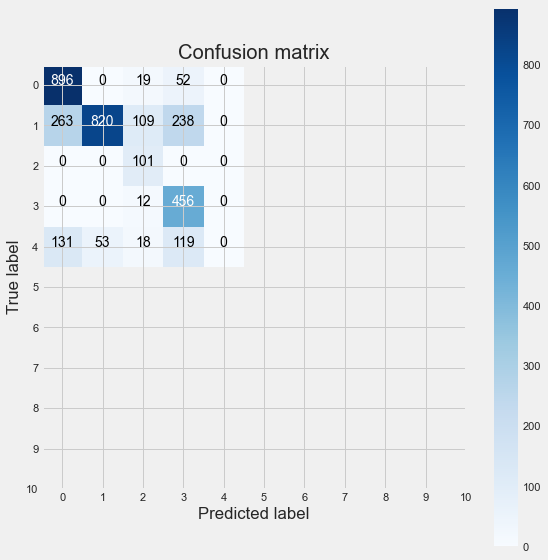

In [260]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

___
#### Learning curve

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample. In order to draw this curve, I use the [scikit-learn documentation code again](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr- self-examples-model-selection-pad-learning-curve-py)

In [261]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

from which I represent the leanring curve of the SVC classifier:

/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

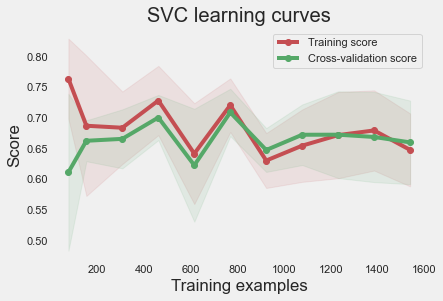

In [262]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, #ylim = [1.01, 0.35],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

___
### Logistic Regression

I now consider the logistic regression classifier. As before, I create an instance of the `Class_Fit` class, adjust the model on the training data and see how the predictions compare to the real values:

In [263]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 3)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)
lr.grid.best_params_

Precision: 75.60 % 


{'C': 0.01}

Then, I plot the learning curve to have a feeling of the quality of the model:

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

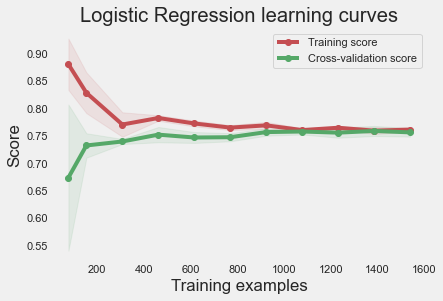

In [264]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        #ylim = [1.01, 0.4],
                        cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### k-Nearest Neighbors

In [265]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(5,25,1)}], Kfold = 3)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)
knn.grid.best_params_

Precision: 71.25 % 


{'n_neighbors': 18}

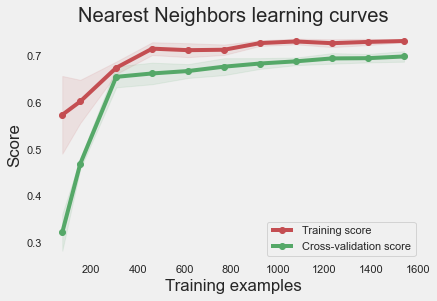

In [266]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        #ylim = [1.01, 0.6],
                        cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Decision Tree

In [267]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 3)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)
tr.grid.best_params_

Precision: 61.70 % 


{'criterion': 'gini', 'max_features': 'sqrt'}

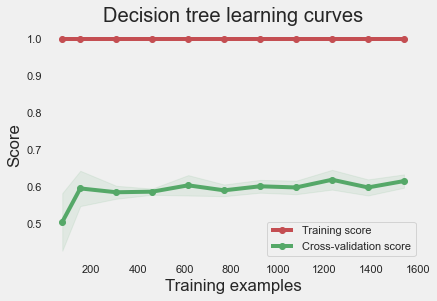

In [268]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        #ylim = [1.01, 0.5],
                        cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Random Forest

In [269]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [100, 125, 150],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 3)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)
rf.grid.best_params_

Precision: 73.47 % 


{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 125}

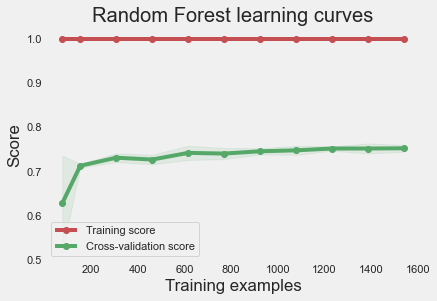

In [270]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        #ylim = [1.01, 0.6],
                        cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### AdaBoost Classifier

In [271]:
# from sklearn.tree import DecisionTreeClassifier
ada = Class_Fit(clf = AdaBoostClassifier)
# ada = Class_Fit(clf = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=3)))
param_grid = {'n_estimators' : [40,60,80]}
ada.grid_search(parameters = param_grid, Kfold = 3)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)
ada.grid.best_params_

Precision: 67.51 % 


{'n_estimators': 40}

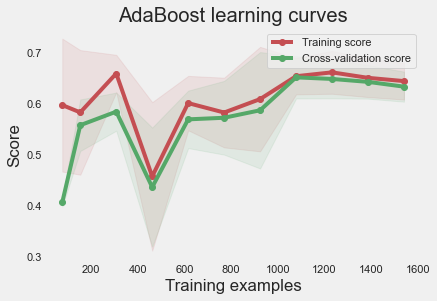

In [272]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        #ylim = [1.01, 0.3],
                        cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Gradient Boosting Classifier

In [273]:
%%time
# takes about 2 minutes, depending on the machine
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [1000], 'max_depth' : [4]}
gb.grid_search(parameters = param_grid, Kfold = 3)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)
gb.grid.best_params_

Precision: 70.79 % 
CPU times: user 48.8 s, sys: 415 ms, total: 49.2 s
Wall time: 48.8 s


{'max_depth': 4, 'n_estimators': 1000}

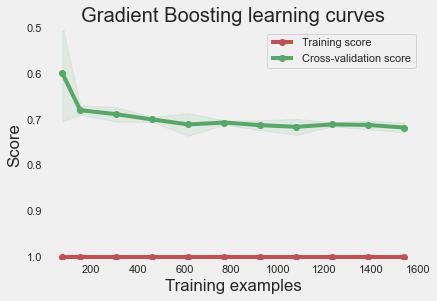

In [274]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.5], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

___
### Let's vote !

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, I use the `VotingClassifier` method of the `sklearn` package. As a first step, I adjust the parameters of the various classifiers using the *best* parameters previously found:

In [275]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, I define a classifier that merges the results of the various classifiers:

In [276]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('lr', lr_best)], voting='soft') 

and train it:

In [277]:
votingC = votingC.fit(X_train, Y_train)

Finally, we can create a prediction for this model:

In [278]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 73.47 % 


Note that when defining the `votingC` classifier, I only used a sub-sample of the whole set of classifiers defined above and only retained the *Random Forest*, the *Logistic Regression* and the *Gradient Boosting* classifiers. In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

___
## Testing predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 10 months. In this section, I test the model  the last two months of the dataset, that has been stored in the `set_test` dataframe:

In [279]:
#basket_price_test = set_test.copy(deep = True)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. ** At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself**. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables ** count **, ** min **, ** max ** and ** sum **). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the `kmeans` method used in section 4. The` predict` method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories:

In [280]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

In [281]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = transactions_per_user_test[columns]

It remains only to examine the predictions of the different classifiers that have been trained in section 5:

In [282]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 69.15 % 
______________________________ 
Logostic Regression
Precision: 75.60 % 
______________________________ 
k-Nearest Neighbors
Precision: 71.25 % 
______________________________ 
Decision Tree
Precision: 61.70 % 
______________________________ 
Random Forest
Precision: 73.47 % 
______________________________ 
Gradient Boosting
Precision: 70.79 % 


Finally, I found that combining the respective predictions of different classifiers did not improve the quality.

In [283]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 73.47 % 


###### ___
## Conclusions

The work described in this notebook is based on a database providing details on purchases made on an E-commerce platform over a period of one year. Each entry in the dataset describes the purchase of a product, by a particular customer and at a given date. In total, approximately $\sim$4000 clients appear in the database. Given the available information, I decided to develop a classifier that allows to anticipate the type of purchase that a customer will make, as well as the number of visits that he will make during a year, and this from its first visit to the E-commerce site.

The first stage of this work consisted in describing the different products sold by the site, which was the subject of a first classification. There, I grouped the different products into 6 main categories of goods. In a second step, I performed a classification of the customers by analyzing their consumption habits over a period of 10 months. I have classified clients into 11 major categories based on the type of products they usually buy, the number of visits they make and the amount they spent during the 10 months. Once these categories established, I finally trained several classifiers whose objective is to be able to classify consumers in one of these 8 categories and this from their first purchase. For this, the classifier is based on variables which are:
- ** mean **: amount of the basket of the current purchase
- ** categ_N ** with $N \in [0: 4]$: percentage spent in product category with index $N$

Finally, the quality of the predictions of the different classifiers was tested over the last two months of the dataset. The data were then processed in two steps: first, all the data was considered (ober the 2 months) to define the category to which each client belongs, and then, the classifier predictions were compared with this category assignment. I then found that 75% of clients are awarded the right classes.
The performance of the classifier therefore seems correct given the potential shortcomings of the current model. In particular, a bias that has not been dealt with concerns the seasonality of purchases and the fact that purchasing habits will potentially depend on the time of year (for example, Christmas ). In practice, this seasonal effect may cause the categories defined over a 10-month period to be quite different from those extrapolated from the last two months. In order to correct such bias, it would be beneficial to have data that would cover a longer period of time.

In [284]:
stop_time = pd.datetime.now()
print('duration: ', stop_time - start_time)

duration:  0:07:21.513216
